In [1]:
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')  
client

<Client: 'tcp://203.247.189.224:43818' processes=5 threads=90, memory=419.10 GiB>

# Import modules

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import seaborn as sns
import matplotlib.patches as patches
from scipy import stats
import cmocean
import glob
from cmcrameri import cm
from tqdm.notebook import tqdm_notebook
import warnings
warnings.simplefilter(action='ignore')
import os
import subprocess
import re
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time

# Configurations for reading data (years, vars, time_freq, ...)

In [3]:
# # VAR=['U', 'V', 'PSL', 'PRECT']
# # VAR=['SST']
# VAR=['photoC_TOT_zint_100m']

# # scenarios=('HISTsmbb','SSP370smbb','SSP370smbbext')
# # members=('1011.001','1031.002','1051.003','1071.004','1091.005',
# #          '1111.006','1131.007','1151.008','1171.009','1191.010')

# years= list(range(1960, 2021))


# LE_rootdir='/proj/jedwards/archive'
# ODA_rootdir='/mnt/lustre/proj/earth.system.predictability/ASSM_EXP_timeseries/archive'


# tfreq='month_1'
# resolution='f09_g17'
# # comp,model='atm','cam.h0'
# comp,model='ocn','pop.h'
# scenarios = r'\.(BHISTsmbb|BSSP370smbb)\.'

# if comp=='ocn':
#     ds_grid = pop_tools.get_grid('POP_gx1v7')

In [5]:
# exceptcv=['time','lon','lat','lev', *VAR]
# def process_coords(ds, drop=True, except_coord_vars=exceptcv):
#     """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
#     coord_vars = []
#     for v in np.array(ds.coords) :
#         if not v in except_coord_vars:
#             coord_vars += [v]
#     for v in np.array(ds.data_vars) :
#         if not v in except_coord_vars:
#             coord_vars += [v]
#     # ds=ds.sel(lon=slice(30,120), lat=slice(-40,45)).isel(lev=25)
#     # ds=ds.sel(lon=slice(0,360), lat=slice(-90,90)).isel(lev=1)
#     # ds=ds.sel(lon=slice(0,360), lat=slice(-90,90))


#     if drop:
#         return ds.drop(coord_vars)
#     else:
#         return ds.set_coords(coord_vars)

In [97]:
import cftime
import datetime

# VAR='SH'
# comp='wav'
FDA_rootdir = '/mnt/lustre/proj/kimyy/Observation/ERA5/tak/era5_daily_sst_30N-60N/regridded_1x1_30N-60N'
command='ls ' + FDA_rootdir + '/*moving_avg*.nc'
FDA_files_raw = subprocess.check_output(command, shell=True, text=True)
FDA_files= [entry for entry in FDA_files_raw.split('\n') if entry]
FDA_files = sorted(FDA_files)

DA_ds = xr.open_mfdataset(FDA_files, 
                            combine='nested', 
                            concat_dim=['time'])


start_date = cftime.DatetimeNoLeap(1940, 1, 1)
n_days = DA_ds.dims['time']  # = 30660
dates = [start_date + datetime.timedelta(days=i) for i in range(n_days)]
DA_ds = DA_ds.assign_coords(time=("time", dates))

DA_ds=DA_ds.compute()

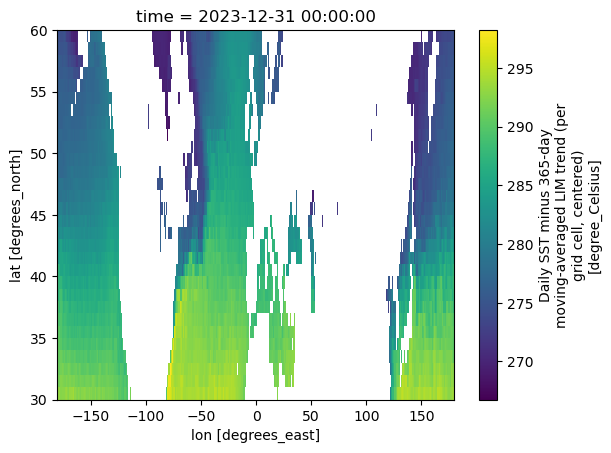

In [19]:
DA_ds['sst_LIM'].isel(time=30659).plot.pcolormesh()


In [22]:
from scipy.ndimage import uniform_filter1d

def calculate_mhw_climatology_noleap(da, vWindowHalfWidth=11, vThreshold=90, vsmoothPercentileWidth=11):
    """
    Calculate daily climatology and percentile threshold for Marine Heatwave detection,
    assuming a no-leap calendar (365 days per year).

    Parameters:
    - da: xarray.DataArray with dims (time, lat, lon), no-leap daily data
    - vWindowHalfWidth: half-width of the moving window for climatology (e.g., ±11 days)
    - vThreshold: percentile threshold (e.g., 90 for 90th percentile)
    - vsmoothPercentileWidth: smoothing window width (must be odd, e.g., 11)

    Returns:
    - mclim: daily climatological mean [lat, lon, doy=1~365]
    - m90: daily threshold (e.g., 90th percentile) [lat, lon, doy=1~365]
    """

    assert 'time' in da.dims and 'lat' in da.dims and 'lon' in da.dims

    # Extract dimensions and day-of-year (DOY)
    doy = da['time'].dt.dayofyear.values
    doy[doy > 365] = 365  # Make sure leap days are excluded

    lat = da['lat']
    lon = da['lon']
    nlat, nlon = len(lat), len(lon)

    mclim = np.full((nlat, nlon, 365), np.nan)
    m90 = np.full((nlat, nlon, 365), np.nan)

    da_np = da.transpose('time', 'lat', 'lon').values  # shape: (time, lat, lon)

    # Loop over each day of year (1–365)
    for d in range(1, 366):
        lower = d - vWindowHalfWidth
        upper = d + vWindowHalfWidth

        # Handle wrap-around (e.g., window spans December–January)
        valid_doy = ((doy >= lower) & (doy <= upper)) | \
                    ((lower < 1) & ((doy >= (365 + lower)) | (doy <= upper))) | \
                    ((upper > 365) & ((doy >= lower) | (doy <= (upper - 365))))

        temp_sel = da_np[valid_doy, :, :]  # shape: (n_days, lat, lon)

        # Compute mean and percentile over time axis
        mclim[:, :, d-1] = np.nanmean(temp_sel, axis=0)
        m90[:, :, d-1] = np.nanpercentile(temp_sel, vThreshold, axis=0)

    # Apply running mean smoothing with wrap-around
    def smooth(data_365):
        # Concatenate three copies to handle edge effects
        padded = np.concatenate([data_365, data_365, data_365], axis=2)
        smoothed = uniform_filter1d(padded, size=vsmoothPercentileWidth, axis=2, mode='nearest')
        center = smoothed[:, :, 365:2*365]
        return center

    mclim = smooth(mclim)
    m90 = smooth(m90)

    # Create xarray outputs
    doy_coords = np.arange(1, 366)
    mclim_da = xr.DataArray(mclim, coords=[lat, lon, doy_coords], dims=['lat', 'lon', 'doy'])
    m90_da = xr.DataArray(m90, coords=[lat, lon, doy_coords], dims=['lat', 'lon', 'doy'])

    return mclim_da, m90_da


In [23]:
DA_ds_mclim, DA_ds_m90 = calculate_mhw_climatology_noleap(
    DA_ds['sst_LIM'],
    vWindowHalfWidth=11,
    vThreshold=90,
    vsmoothPercentileWidth=11
)

In [24]:
DA_ds_mclim

<xarray.DataArray (lat: 30, lon: 360, doy: 365)> Size: 32MB
array([[[292.78962014, 292.73021629, 292.67071811, ..., 292.96748491,
         292.90825584, 292.84895741],
        [292.73692183, 292.67791193, 292.61893255, ..., 292.91364913,
         292.85483066, 292.79590399],
        [292.72272283, 292.66632912, 292.60978005, ..., 292.89024769,
         292.83471125, 292.77885853],
        ...,
        [292.92824485, 292.86682961, 292.80531727, ..., 293.1118275 ,
         293.05075628, 292.98956576],
        [292.96467174, 292.90233265, 292.839644  , ..., 293.1499939 ,
         293.08851485, 293.02674172],
        [292.84858287, 292.78684581, 292.72503385, ..., 293.03379683,
         292.97203758, 292.91030051]],

       [[291.97358287, 291.90857766, 291.84391646, ..., 292.16949185,
         292.10415649, 292.03881559],
        [291.90027965, 291.84233232, 291.78471513, ..., 292.07533958,
         292.01682628, 291.9584517 ],
        [291.93311102, 291.87697255, 291.82098666, ..., 292.10226718,
         292.0457514 , 291.98937711],
...
        [275.27987671, 275.25833407, 275.23730469, ..., 275.3476507 ,
         275.3245378 , 275.30197144],
        [275.37356567, 275.35172341, 275.33034169, ..., 275.44223577,
         275.41881214, 275.39593783],
        [275.54784601, 275.52628673, 275.50497437, ..., 275.61497081,
         275.59214644, 275.56977983]],

       [[275.54534635, 275.53098644, 275.51690119, ..., 275.59167203,
         275.57561424, 275.56017234],
        [275.72250089, 275.70909812, 275.69565929, ..., 275.76498968,
         275.75020807, 275.73606179],
        [275.6559365 , 275.64535522, 275.63473788, ..., 275.689639  ,
         275.67782038, 275.66660656],
        ...,
        [274.89919767, 274.88135875, 274.86421065, ..., 274.95691473,
         274.93696733, 274.91776622],
        [275.16573542, 275.14770508, 275.13029619, ..., 275.22406838,
         275.20390736, 275.18447321],
        [275.36368075, 275.3481806 , 275.33313266, ..., 275.41398482,
         275.39656206, 275.37979681]]])
Coordinates:
  * lat      (lat) float32 120B 30.5 31.5 32.5 33.5 34.5 ... 56.5 57.5 58.5 59.5
  * lon      (lon) float32 1kB -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * doy      (doy) int64 3kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365

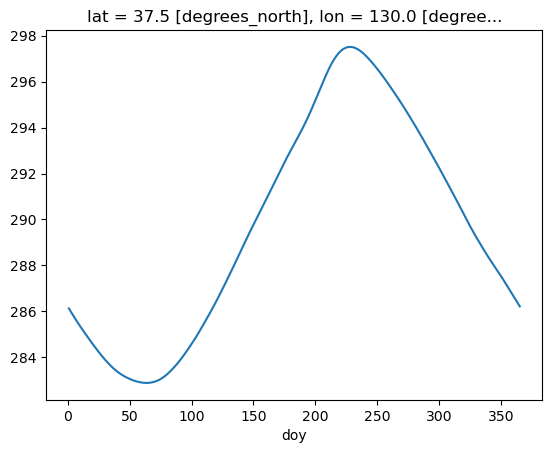

In [26]:
DA_ds_mclim.sel(lon=130,lat=37,method='nearest').plot()

In [27]:
def extract_filtered_yearly_seasonal_cycles(da, vWindowHalfWidth=11, vsmoothPercentileWidth=11):
    """
    Extract yearly seasonal cycles using the same logic as mclim:
    - Apply ±window filtering per DOY
    - Apply running mean smoothing
    Output: (year, lat, lon, doy)
    """
    da = da.sortby('time')
    da = da.load()  # force into memory if dask-backed

    doy = da['time'].dt.dayofyear.values
    doy[doy > 365] = 365
    years = np.unique(da['time'].dt.year.values)

    da_np = da.transpose('time', 'lat', 'lon').values
    nlat = len(da['lat'])
    nlon = len(da['lon'])

    output = np.full((len(years), nlat, nlon, 365), np.nan)

    for y_idx, y in enumerate(years):
        # mask for this year
        year_mask = (da['time'].dt.year == y).values

        for d in range(1, 366):
            lower = d - vWindowHalfWidth
            upper = d + vWindowHalfWidth

            # build DOY-based mask (same as before)
            doy_mask = ((doy >= lower) & (doy <= upper)) | \
                       ((lower < 1) & ((doy >= (365 + lower)) | (doy <= upper))) | \
                       ((upper > 365) & ((doy >= lower) | (doy <= (upper - 365))))

            # restrict to current year
            idx = np.where(year_mask & doy_mask)[0]

            if len(idx) > 0:
                temp_sel = da_np[idx, :, :]
                output[y_idx, :, :, d-1] = np.nanmean(temp_sel, axis=0)

        # optional: apply smoothing across DOY for this year
        output[y_idx] = uniform_filter1d(output[y_idx], size=vsmoothPercentileWidth, axis=2, mode='nearest')

    return xr.DataArray(
        output,
        coords=[years, da['lat'], da['lon'], np.arange(1, 366)],
        dims=['year', 'lat', 'lon', 'doy']
    )

In [30]:
DA_ds_filtered_yearly_clim = extract_filtered_yearly_seasonal_cycles(
    DA_ds['sst_LIM'],
    vWindowHalfWidth=11,
    vsmoothPercentileWidth=11
)

In [34]:
def compute_sst_rise_fraction_safe(da):
    """
    Safely compute the fraction of the year it takes to go from coldest to warmest SST,
    handling all-NaN slices by returning NaN for those locations.
    
    Parameters:
    - da: xarray.DataArray of shape (year, lat, lon, doy)

    Returns:
    - xarray.DataArray of shape (year, lat, lon)
    """

    # Mask all-NaN along DOY
    valid_mask = da.notnull().any(dim='doy')

    # Replace all-NaN slices with temporary filler (e.g., 9999)
    da_safe = da.where(valid_mask, other=9999)

    # Compute argmin and argmax
    doy_min = da_safe.argmin(dim='doy')
    doy_max = da_safe.argmax(dim='doy')

    # Restore to NaN where original was all-NaN
    doy_min = doy_min.where(valid_mask, other=np.nan)
    doy_max = doy_max.where(valid_mask, other=np.nan)

    # Compute rise days (handle wrap-around)
    rise_days = doy_max - doy_min
    rise_days = rise_days.where(rise_days >= 0, 365 + rise_days)

    # Normalize to fraction
    rise_fraction = rise_days / 365.0

    return rise_fraction


In [36]:
DA_ds_rise_fraction = compute_sst_rise_fraction_safe(DA_ds_filtered_yearly_clim)


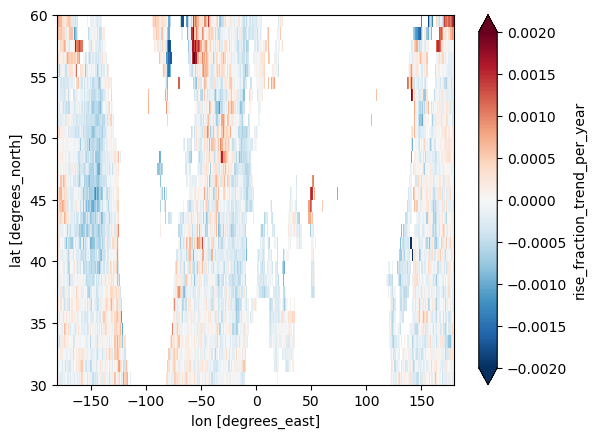

In [41]:
def linear_trend_over_years(da):
    """
    Compute linear trend over 'year' dimension for each lat-lon grid.

    Parameters:
    - da: xarray.DataArray of shape (year, lat, lon)

    Returns:
    - slope: xarray.DataArray of shape (lat, lon), trend per year
    """
    years = da['year'].values
    years = years - years.mean()  # center time to improve numerical stability

    def compute_slope(y, x=years):
        mask = np.isfinite(y)
        if mask.sum() < 2:
            return np.nan
        return np.polyfit(x[mask], y[mask], deg=1)[0]

    # Apply over (year) dimension
    slope = xr.apply_ufunc(
        compute_slope,
        da,
        input_core_dims=[['year']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )

    slope.name = 'rise_fraction_trend_per_year'
    return slope


rise_trend = linear_trend_over_years(DA_ds_rise_fraction)
rise_trend.plot(cmap='RdBu_r', vmin=-0.002, vmax=0.002)

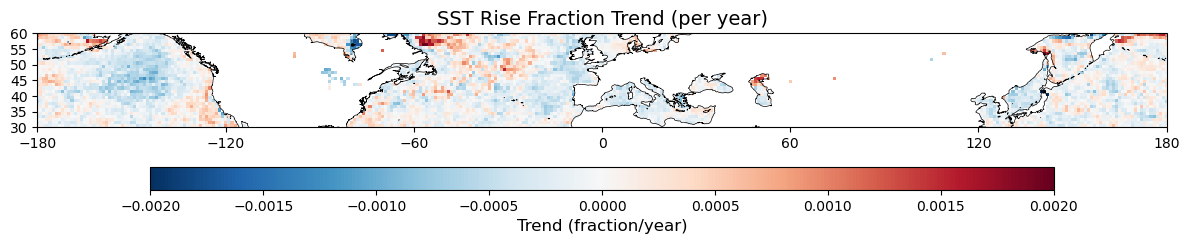

In [53]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Value range and title
vmin, vmax = -0.002, 0.002
cmap = 'RdBu_r'
title = 'SST Rise Fraction Trend (per year)'

# Data extent
lat_min, lat_max = 30, 60
lon_min = float(rise_trend.lon.min())
lon_max = float(rise_trend.lon.max())

# Create larger figure
fig = plt.figure(figsize=(12, 6))  # taller height
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the data with NO land, and horizontal colorbar
im = rise_trend.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,  # draw it manually below
    add_labels=False,
    zorder=1
)

# Add coastlines only
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2)

# Set ticks and title
ax.set_title(title, fontsize=14)
ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(30, 61, 5), crs=ccrs.PlateCarree())
ax.tick_params(labelsize=10)

# Gridlines
# gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
# gl.right_labels = False
# gl.top_labels = False

# Add horizontal colorbar BELOW the plot
cbar = plt.colorbar(im, orientation='horizontal', pad=0.07, shrink=0.8, aspect=40)
cbar.set_label('Trend (fraction/year)', fontsize=12)

plt.tight_layout()
plt.show()


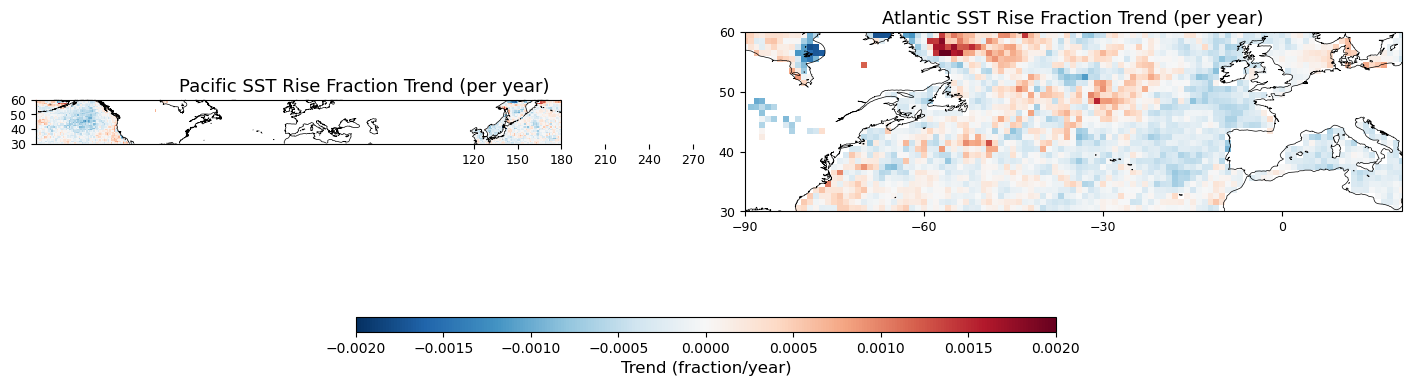

In [65]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr  # 필요한 경우 추가

# ---------------- Settings ----------------
vmin, vmax = -0.002, 0.002
cmap = 'RdBu_r'
title1 = 'Pacific SST Rise Fraction Trend (per year)'
title2 = 'Atlantic SST Rise Fraction Trend (per year)'
lat_min, lat_max = 30, 60

# ---------------- Longitude Adjustments ----------------
# Convert lon from -180–180 to 0–360
rise_trend2 = rise_trend.copy()
rise_trend2['lon'] = xr.where(rise_trend2.lon < 0, rise_trend2.lon + 360, rise_trend2.lon)

# Roll to ensure longitude is ordered from 0 to 360 (not 180–360, 0–180)
roll_index = rise_trend2.lon.argsort().values
rise_trend2 = rise_trend2.isel(lon=roll_index)

# ---------------- Create Subplots ----------------
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(14, 5),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=True  # Avoid overlapping layout
)

# -------- Pacific Panel --------
ax = axes[0]
ax.set_extent([120, 270, lat_min, lat_max], crs=ccrs.PlateCarree())
pacific_data = rise_trend2.sel(lon=slice(120, 270))
im1 = pacific_data.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
    add_labels=False,
    zorder=1
)
ax.set_title(title1, fontsize=13)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2)
ax.set_xticks(np.arange(120, 271, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_min, lat_max+1, 10), crs=ccrs.PlateCarree())
ax.tick_params(labelsize=9)

# -------- Atlantic Panel --------
ax = axes[1]
ax.set_extent([-90, 20, lat_min, lat_max], crs=ccrs.PlateCarree())
atlantic_data = rise_trend.sel(lon=slice(-90, 20))
im2 = atlantic_data.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
    add_labels=False,
    zorder=1
)
ax.set_title(title2, fontsize=13)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2)
ax.set_xticks(np.arange(-90, 21, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_min, lat_max+1, 10), crs=ccrs.PlateCarree())
ax.tick_params(labelsize=9)

# ---------------- Colorbar: place below both panels ----------------
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Trend (fraction/year)', fontsize=12)

plt.show()


In [66]:
print(rise_trend2.lon.values)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

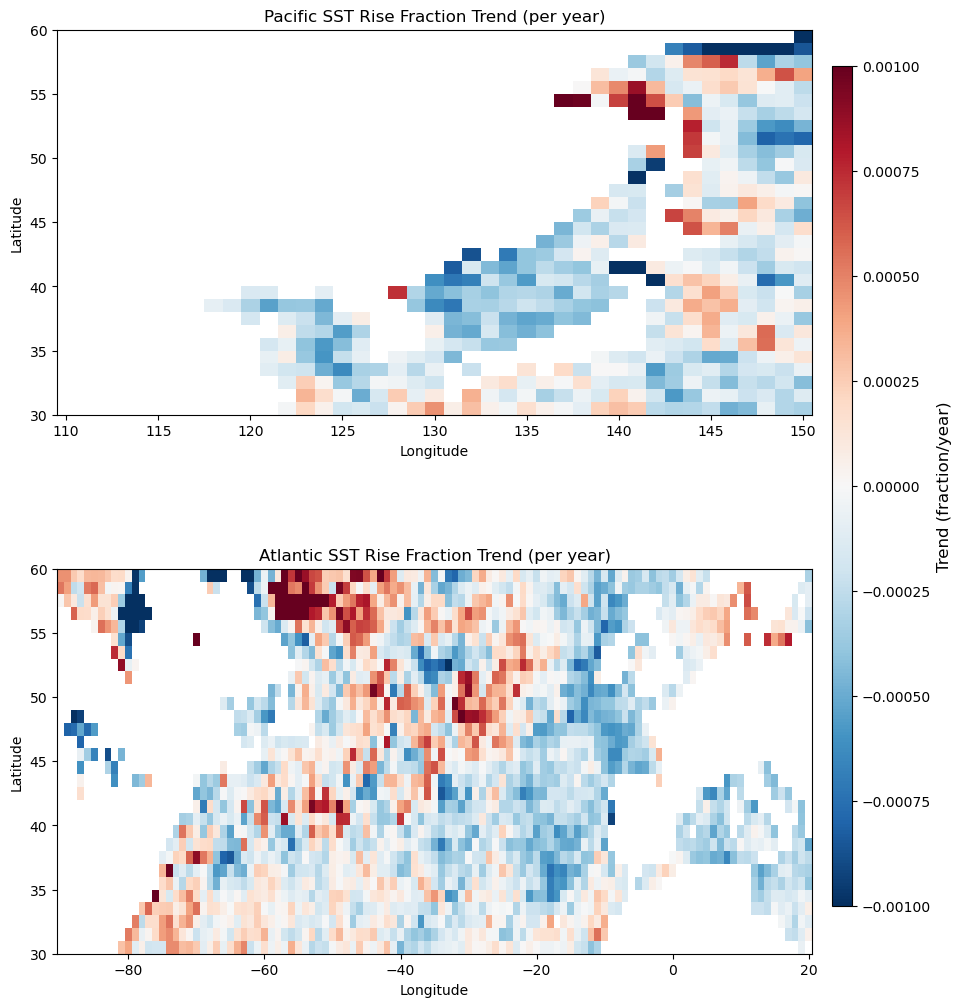

In [286]:
import matplotlib.pyplot as plt
import xarray as xr

# ---------------- Settings ----------------
vmin, vmax = -0.001, 0.001
cmap = 'RdBu_r'
lat_min, lat_max = 30, 60
title1 = 'Pacific SST Rise Fraction Trend (per year)'
title2 = 'Atlantic SST Rise Fraction Trend (per year)'

# ---------------- Prepare Pacific Data ----------------
rise_trend2 = rise_trend.copy()
rise_trend2['lon'] = xr.where(rise_trend2.lon < 0, rise_trend2.lon + 360, rise_trend2.lon)
rise_trend2 = rise_trend2.sortby('lon')
pacific = rise_trend2.sel(lon=slice(110, 150), lat=slice(lat_min, lat_max))

# ---------------- Prepare Atlantic Data ----------------
atlantic = rise_trend.sel(lon=slice(-90, 20), lat=slice(lat_min, lat_max))

# ---------------- Create Subplots ----------------
fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 12), dpi=100,
    gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.4, 'right': 0.88}  # <- hspace 추가!
)

# -------- Pacific Panel --------
im1 = pacific.plot.pcolormesh(
    ax=axes[0],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
    add_labels=False
)
axes[0].set_title(title1, fontsize=12)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# -------- Atlantic Panel --------
im2 = atlantic.plot.pcolormesh(
    ax=axes[1],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
    add_labels=False
)
axes[1].set_title(title2, fontsize=12)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# ---------------- Colorbar (Vertical, Right Side) ----------------
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend (fraction/year)', fontsize=12)

# Adjust layout to avoid colorbar overlap
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()


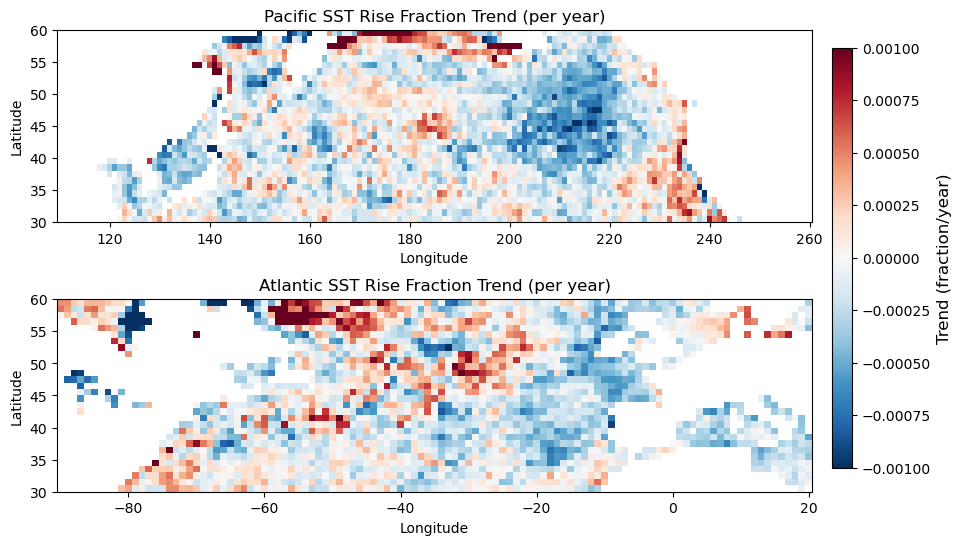

In [109]:
import matplotlib.pyplot as plt
import xarray as xr

# ---------------- Settings ----------------
vmin, vmax = -0.001, 0.001
cmap = 'RdBu_r'
lat_min, lat_max = 30, 60
title1 = 'Pacific SST Rise Fraction Trend (per year)'
title2 = 'Atlantic SST Rise Fraction Trend (per year)'

# ---------------- Prepare Pacific Data ----------------
rise_trend2 = rise_trend.copy()
rise_trend2['lon'] = xr.where(rise_trend2.lon < 0, rise_trend2.lon + 360, rise_trend2.lon)
rise_trend2 = rise_trend2.sortby('lon')
pacific = rise_trend2.sel(lon=slice(110, 260), lat=slice(lat_min, lat_max))

# ---------------- Prepare Atlantic Data ----------------
atlantic = rise_trend.sel(lon=slice(-90, 20), lat=slice(lat_min, lat_max))

# ---------------- Create Subplots ----------------
fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 6), dpi=100,
    gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.4, 'right': 0.88}  # <- hspace 추가!
)

# -------- Pacific Panel --------
im1 = pacific.plot.pcolormesh(
    ax=axes[0],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
    add_labels=False
)
axes[0].set_title(title1, fontsize=12)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# -------- Atlantic Panel --------
im2 = atlantic.plot.pcolormesh(
    ax=axes[1],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
    add_labels=False
)
axes[1].set_title(title2, fontsize=12)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# ---------------- Colorbar (Vertical, Right Side) ----------------
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend (fraction/year)', fontsize=12)

# Adjust layout to avoid colorbar overlap
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()


In [86]:
## raw data

import cftime
import datetime

# VAR='SH'
# comp='wav'
FDA_rootdir = '/mnt/lustre/proj/kimyy/Observation/ERA5/tak/era5_daily_sst_30N-60N/regridded_1x1_30N-60N'
command='ls ' + FDA_rootdir + '/era5_sst_1x1_????_30N-60N.nc'
FDA_files_raw = subprocess.check_output(command, shell=True, text=True)
FDA_files= [entry for entry in FDA_files_raw.split('\n') if entry]
FDA_files = sorted(FDA_files)

DA_ds_raw = xr.open_mfdataset(FDA_files, 
                            combine='nested', 
                            concat_dim=['time'])


start_date = cftime.DatetimeNoLeap(1940, 1, 1)
n_days = DA_ds_raw.dims['time']  # = 30660
dates = [start_date + datetime.timedelta(days=i) for i in range(n_days)]
DA_ds_raw = DA_ds_raw.assign_coords(time=("time", dates))

In [101]:
import xarray as xr
import subprocess

# --------- Load file list ---------
FDA_rootdir = '/mnt/lustre/proj/kimyy/Observation/ERA5/tak/era5_daily_sst_30N-60N/regridded_1x1_30N-60N'
command = 'ls ' + FDA_rootdir + '/era5_sst_1x1_????_30N-60N.nc'
FDA_files_raw = subprocess.check_output(command, shell=True, text=True)
FDA_files = sorted([f for f in FDA_files_raw.split('\n') if f])

# --------- Open each file, drop extra days if > 365 ---------
datasets = []
for f in FDA_files:
    ds = xr.open_dataset(f, decode_times=True)
    if ds.dims['valid_time'] < 365:
        raise ValueError(f"{f} has less than 365 days")
    ds_365 = ds.isel(valid_time=slice(0, 365))  # keep only first 365 days
    datasets.append(ds_365)

# --------- Concatenate along time ---------
DA_ds_raw = xr.concat(datasets, dim='valid_time')
DA_ds_raw = DA_ds_raw.rename({'valid_time': 'time'})
DA_ds_raw=DA_ds_raw.compute()

In [100]:
DA_ds_raw

<xarray.Dataset> Size: 158MB
Dimensions:  (time: 3650, lat: 30, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 29kB 1940-01-01 1940-01-02 ... 1949-12-31
  * lon      (lon) float32 1kB -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float32 120B 30.5 31.5 32.5 33.5 34.5 ... 56.5 57.5 58.5 59.5
Data variables:
    sst      (time, lat, lon) float32 158MB 291.6 291.7 291.7 ... 275.1 275.1
Attributes:
    CDI:                     Climate Data Interface version 1.9.3 (http://mpi...
    history:                 Fri Aug 15 10:56:11 2025: cdo sellonlatbox,-180,...
    institution:             European Centre for Medium-Range Weather Forecasts
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    CDO:                     Climate Data Operators version 1.9.3 (http://mpi...

In [102]:
DA_ds_raw_filtered_yearly_clim = extract_filtered_yearly_seasonal_cycles(
    DA_ds_raw['sst'],
    vWindowHalfWidth=11,
    vsmoothPercentileWidth=11
)

DA_ds_raw_rise_fraction = compute_sst_rise_fraction_safe(DA_ds_raw_filtered_yearly_clim)

rise_trend_raw = linear_trend_over_years(DA_ds_raw_rise_fraction)

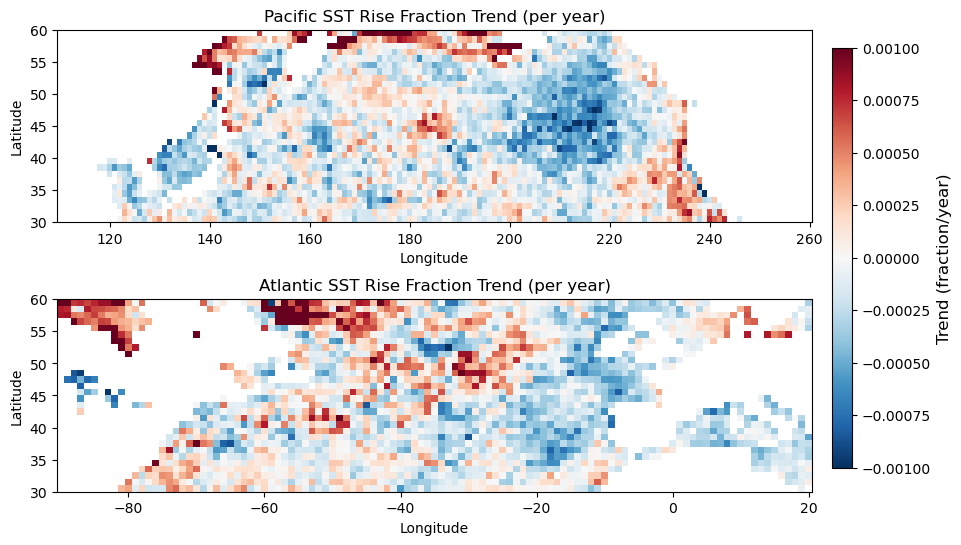

In [108]:
import matplotlib.pyplot as plt
import xarray as xr

# ---------------- Settings ----------------
vmin, vmax = -0.001, 0.001
cmap = 'RdBu_r'
lat_min, lat_max = 30, 60
title1 = 'Pacific SST Rise Fraction Trend (per year)'
title2 = 'Atlantic SST Rise Fraction Trend (per year)'

# ---------------- Prepare Pacific Data ----------------
rise_trend_raw2 = rise_trend_raw.copy()
rise_trend_raw2['lon'] = xr.where(rise_trend_raw2.lon < 0, rise_trend_raw2.lon + 360, rise_trend_raw2.lon)
rise_trend_raw2 = rise_trend_raw2.sortby('lon')
pacific = rise_trend_raw2.sel(lon=slice(110, 260), lat=slice(lat_min, lat_max))

# ---------------- Prepare Atlantic Data ----------------
atlantic = rise_trend_raw.sel(lon=slice(-90, 20), lat=slice(lat_min, lat_max))

# ---------------- Create Subplots ----------------
fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 6), dpi=100,
    gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.4, 'right': 0.88}  # <- hspace 추가!
)

# -------- Pacific Panel --------
im1 = pacific.plot.pcolormesh(
    ax=axes[0],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
    add_labels=False
)
axes[0].set_title(title1, fontsize=12)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# -------- Atlantic Panel --------
im2 = atlantic.plot.pcolormesh(
    ax=axes[1],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
    add_labels=False
)
axes[1].set_title(title2, fontsize=12)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# ---------------- Colorbar (Vertical, Right Side) ----------------
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend (fraction/year)', fontsize=12)

# Adjust layout to avoid colorbar overlap
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()


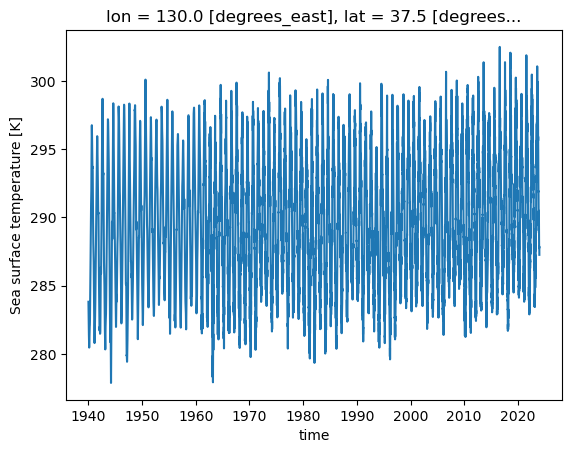

In [106]:
DA_ds_raw['sst'].sel(lon=130,lat=37,method='nearest').plot()

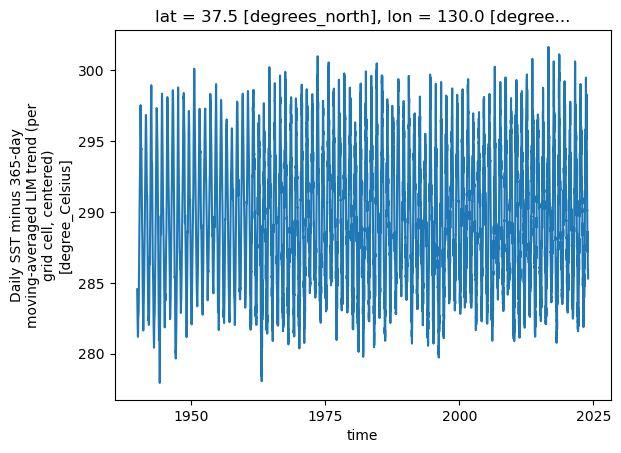

In [107]:
DA_ds['sst_LIM'].sel(lon=130,lat=37,method='nearest').plot()

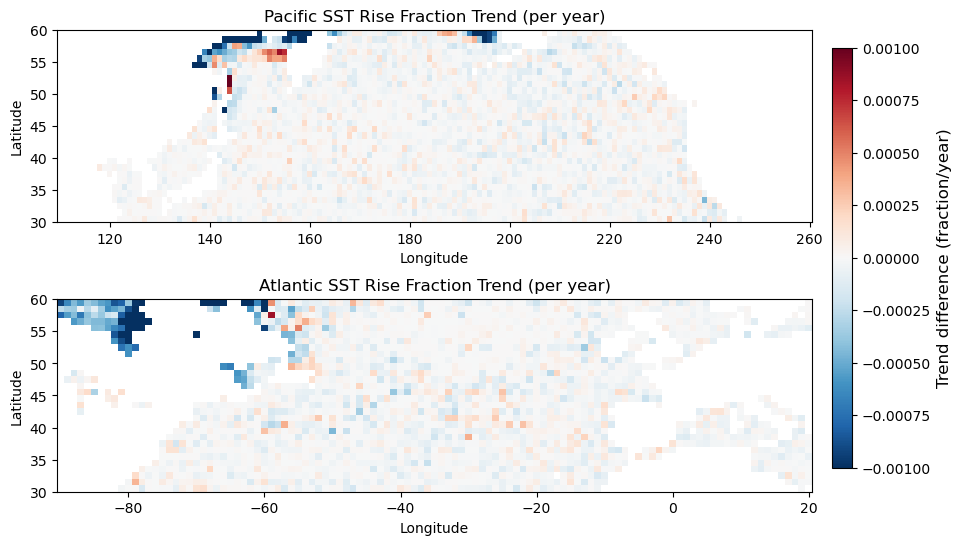

In [110]:
import matplotlib.pyplot as plt
import xarray as xr

# ---------------- Settings ----------------
vmin, vmax = -0.001, 0.001
cmap = 'RdBu_r'
lat_min, lat_max = 30, 60
title1 = 'Pacific SST Rise Fraction Trend (per year)'
title2 = 'Atlantic SST Rise Fraction Trend (per year)'

# ---------------- Prepare Pacific Data ----------------
rise_trend_raw2 = rise_trend_raw.copy()
rise_trend_raw2['lon'] = xr.where(rise_trend_raw2.lon < 0, rise_trend_raw2.lon + 360, rise_trend_raw2.lon)
rise_trend_raw2 = rise_trend_raw2.sortby('lon')
pacific = rise_trend2.sel(lon=slice(110, 260), lat=slice(lat_min, lat_max)) - rise_trend_raw2.sel(lon=slice(110, 260), lat=slice(lat_min, lat_max))

# ---------------- Prepare Atlantic Data ----------------
atlantic = rise_trend.sel(lon=slice(-90, 20), lat=slice(lat_min, lat_max)) - rise_trend_raw.sel(lon=slice(-90, 20), lat=slice(lat_min, lat_max))

# ---------------- Create Subplots ----------------
fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 6), dpi=100,
    gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.4, 'right': 0.88}  # <- hspace 추가!
)

# -------- Pacific Panel --------
im1 = pacific.plot.pcolormesh(
    ax=axes[0],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
    add_labels=False
)
axes[0].set_title(title1, fontsize=12)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# -------- Atlantic Panel --------
im2 = atlantic.plot.pcolormesh(
    ax=axes[1],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
    add_labels=False
)
axes[1].set_title(title2, fontsize=12)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# ---------------- Colorbar (Vertical, Right Side) ----------------
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend difference (fraction/year)', fontsize=12)

# Adjust layout to avoid colorbar overlap
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()


In [175]:
# Getting MHW v1

import xarray as xr
import numpy as np

def detect_mhw(sst, clim, threshold, min_duration=5):
    """
    Detect marine heatwaves (MHWs) where SST > threshold for at least `min_duration` consecutive days.

    Parameters
    ----------
    sst : xr.DataArray
        SST data with dims ('time', 'lat', 'lon')
    clim : xr.DataArray
        Climatological mean SST with dims ('lat', 'lon', 'doy')
    threshold : xr.DataArray
        90th percentile threshold with dims ('lat', 'lon', 'doy')
    min_duration : int
        Minimum duration in days to define a MHW

    Returns
    -------
    mhw_mask : xr.DataArray
        Boolean mask with same shape as sst: True where MHW occurs
    """

    # Step 1: Compute day of year index for each time
    doy = sst['time'].dt.dayofyear  # ✅ FIXED: use .dt directly on the coordinate
    doy = doy.where(doy <= 365, 365)  # not strictly necessary since no leap year

    # Step 2: Broadcast clim and threshold to (time, lat, lon)
    clim_broadcasted = clim.transpose('lat', 'lon', 'doy').sel(doy=doy).transpose('time', 'lat', 'lon')
    thresh_broadcasted = threshold.transpose('lat', 'lon', 'doy').sel(doy=doy).transpose('time', 'lat', 'lon')

    # Step 3: Identify exceedances
    exceedance = sst > thresh_broadcasted
    
    # Step 4: Initialize MHW mask correctly
    mhw_mask = xr.full_like(exceedance, False, dtype=bool)  # ✅ fixed
    
    # Step 5: Loop through lat/lon and apply duration filter
    for i in range(exceedance.shape[1]):  # lat
        for j in range(exceedance.shape[2]):  # lon
            condition = exceedance[:, i, j].values
            if np.any(condition):
                labeled, num = label_consecutive(condition)
                valid = np.isin(labeled, [n for n in range(1, num+1) if np.sum(labeled == n) >= min_duration])
                mhw_mask[:, i, j] = valid
    return mhw_mask

def label_consecutive(condition):
    """
    Label consecutive True values in a 1D boolean array.
    Returns: array of same length, with 0 = False and 1,2,... = group labels
    """
    from itertools import groupby
    from operator import itemgetter

    labels = np.zeros_like(condition, dtype=int)
    group_id = 1
    i = 0
    while i < len(condition):
        if condition[i]:
            j = i
            while j < len(condition) and condition[j]:
                j += 1
            labels[i:j] = group_id
            group_id += 1
            i = j
        else:
            i += 1
    return labels, group_id - 1


In [276]:
# MHW v2

import xarray as xr
import numpy as np

def detect_mhw_with_metrics(sst, clim, threshold, min_duration=5):
    """
    Detect marine heatwaves and compute metrics: mask, intensity, duration, cumulative intensity.

    Parameters
    ----------
    sst : xr.DataArray
        SST with dims ('time', 'lat', 'lon')
    clim : xr.DataArray
        Climatological mean SST ('lat', 'lon', 'doy')
    threshold : xr.DataArray
        90th percentile SST ('lat', 'lon', 'doy')
    min_duration : int
        Minimum duration of event in days

    Returns
    -------
    mhw_mask : xr.DataArray (bool)
        True where MHWs occur
    mhw_intensity : xr.DataArray (float)
        Daily intensity (sst - clim), NaN where not MHW
    mhw_duration : xr.DataArray (float)
        Mean duration of MHW events at each grid point
    mhw_cum_intensity : xr.DataArray (float)
        Mean cumulative intensity of MHW events at each grid point
    """

    # Step 1: Broadcast doy → (time, lat, lon)
    doy = sst['time'].dt.dayofyear
    doy = doy.where(doy <= 365, 365)

    clim_bc = clim.transpose('lat', 'lon', 'doy').sel(doy=doy).transpose('time', 'lat', 'lon')
    thresh_bc = threshold.transpose('lat', 'lon', 'doy').sel(doy=doy).transpose('time', 'lat', 'lon')

    # Step 2: Exceedance and intensity
    exceedance = sst > thresh_bc
    intensity_all = (sst - clim_bc).where(exceedance)  # NaN outside MHW

    # Step 3: Initialize outputs
    mhw_mask = xr.full_like(sst, False, dtype=bool)
    mhw_intensity = xr.full_like(sst, np.nan)
    duration_arr = np.full((sst.lat.size, sst.lon.size), np.nan)
    cumint_arr = np.full((sst.lat.size, sst.lon.size), np.nan)

    for i in range(sst.lat.size):
        for j in range(sst.lon.size):
            cond = exceedance[:, i, j].values
            inten = intensity_all[:, i, j].values

            if np.any(cond):
                labels, num = label_consecutive(cond)
                durations = []
                cum_intensities = []

                for k in range(1, num + 1):
                    idx = (labels == k)
                    if np.sum(idx) >= min_duration:
                        mhw_mask[:, i, j][idx] = True
                        mhw_intensity[:, i, j][idx] = inten[idx]
                        durations.append(np.sum(idx))
                        cum_intensities.append(np.nansum(inten[idx]))

                if durations:
                    duration_arr[i, j] = np.mean(durations)
                    cumint_arr[i, j] = np.mean(cum_intensities)

    mhw_duration = xr.DataArray(duration_arr, coords=[sst.lat, sst.lon], dims=['lat', 'lon'])
    mhw_cumintensity = xr.DataArray(cumint_arr, coords=[sst.lat, sst.lon], dims=['lat', 'lon'])

    return mhw_mask, mhw_intensity, mhw_duration, mhw_cumintensity


def label_consecutive(condition):
    """
    Label consecutive True segments in 1D array.
    Returns labeled array and number of segments.
    """
    labels = np.zeros_like(condition, dtype=int)
    group_id = 1
    i = 0
    while i < len(condition):
        if condition[i]:
            j = i
            while j < len(condition) and condition[j]:
                j += 1
            labels[i:j] = group_id
            group_id += 1
            i = j
        else:
            i += 1
    return labels, group_id - 1


In [ ]:
# MHW v3, simplified

def detect_mhw_mask_intensity(sst, clim, threshold, min_duration=5):
    """
    Detect marine heatwaves and compute:
    - Binary mask
    - Daily intensity (sst - clim), NaN where not MHW

    Parameters
    ----------
    sst : xr.DataArray
        SST with dims ('time', 'lat', 'lon')
    clim : xr.DataArray
        Climatological mean SST ('lat', 'lon', 'doy')
    threshold : xr.DataArray
        90th percentile SST ('lat', 'lon', 'doy')
    min_duration : int
        Minimum duration of event in days

    Returns
    -------
    mhw_mask : xr.DataArray (bool)
        True where MHWs occur
    mhw_intensity : xr.DataArray (float)
        Daily intensity (sst - clim), NaN where not MHW
    """

    # Step 1: Broadcast doy → (time, lat, lon)
    doy = sst['time'].dt.dayofyear
    doy = doy.where(doy <= 365, 365)

    clim_bc = clim.transpose('lat', 'lon', 'doy').sel(doy=doy).transpose('time', 'lat', 'lon')
    thresh_bc = threshold.transpose('lat', 'lon', 'doy').sel(doy=doy).transpose('time', 'lat', 'lon')

    # Step 2: Exceedance and intensity
    exceedance = sst > thresh_bc
    intensity_all = (sst - clim_bc).where(exceedance)

    # Step 3: Initialize outputs
    mhw_mask = xr.full_like(sst, False, dtype=bool)
    mhw_intensity = xr.full_like(sst, np.nan)

    for i in range(sst.lat.size):
        for j in range(sst.lon.size):
            cond = exceedance[:, i, j].values
            inten = intensity_all[:, i, j].values

            if np.any(cond):
                labels, num = label_consecutive(cond)

                for k in range(1, num + 1):
                    idx = (labels == k)
                    if np.sum(idx) >= min_duration:
                        mhw_mask[:, i, j][idx] = True
                        mhw_intensity[:, i, j][idx] = inten[idx]

    return mhw_mask, mhw_intensity


def label_consecutive(condition):
    """
    Label consecutive True segments in 1D array.
    Returns labeled array and number of segments.
    """
    labels = np.zeros_like(condition, dtype=int)
    group_id = 1
    i = 0
    while i < len(condition):
        if condition[i]:
            j = i
            while j < len(condition) and condition[j]:
                j += 1
            labels[i:j] = group_id
            group_id += 1
            i = j
        else:
            i += 1
    return labels, group_id - 1


In [278]:
# sst = DA_ds['sst_LIM'].isel(time=slice(0, 730))
sst = DA_ds['sst_LIM']
clim = DA_ds_mclim
threshold = DA_ds_m90

# Detect MHW mask (True where MHW occurs)
# mhw_mask = detect_mhw(sst, clim, threshold, min_duration=5)
# mhw_mask, mhw_intensity = detect_mhw(sst, clim, threshold, min_duration=5)
mhw_mask, mhw_intensity, mhw_duration, mhw_cumintensity = detect_mhw_with_metrics(
    sst, clim, threshold, min_duration=5
)


In [299]:
import xarray as xr

def adjust_sst_to_full_climatology(ds_sst, periods):
    """
    주어진 SST 데이터에서 전체 climatology 기준으로 지정된 기간을 보정합니다.

    Parameters:
    ----------
    ds_sst : xarray.DataArray
        전체 SST (dims: time, lat, lon)
    periods : list of tuples
        보정할 기간들, 예: [(1940, 1970), (1991, 2020)]

    Returns:
    -------
    adjusted_combined : xarray.DataArray
        보정된 SST (time, lat, lon)
    """
    # ▶ 전체 climatology 먼저 계산
    ds_sst['doy'] = ds_sst['time'].dt.dayofyear
    ds_sst['doy'] = ds_sst['doy'].where(ds_sst['doy'] <= 365, 365)  # 윤년 통일
    clim_all = ds_sst.groupby('doy').mean('time', skipna=True)

    # ▶ 각 기간별 보정
    adjusted_list = []

    for start, end in periods:
        sst_sel = ds_sst.sel(time=slice(f'{start}-01-01', f'{end}-12-31')).copy()
        sst_sel['doy'] = sst_sel['time'].dt.dayofyear
        sst_sel['doy'] = sst_sel['doy'].where(sst_sel['doy'] <= 365, 365)

        clim_30yr = sst_sel.groupby('doy').mean('time', skipna=True)

        doy_vals = sst_sel['doy'].values
        time_vals = sst_sel['time'].values
        lat_vals = sst_sel['lat'].values
        lon_vals = sst_sel['lon'].values

        clim_30_bcast = xr.DataArray(
            clim_30yr.sel(doy=doy_vals).values,
            coords={'time': time_vals, 'lat': lat_vals, 'lon': lon_vals},
            dims=('time', 'lat', 'lon')
        )

        clim_all_bcast = xr.DataArray(
            clim_all.sel(doy=doy_vals).values,
            coords={'time': time_vals, 'lat': lat_vals, 'lon': lon_vals},
            dims=('time', 'lat', 'lon')
        )

        adjusted_sst = (sst_sel.drop_vars('doy') - clim_30_bcast) + clim_all_bcast
        adjusted_list.append(adjusted_sst)

    # ▶ 하나로 합치기
    adjusted_combined = xr.concat(adjusted_list, dim='time').sortby('time')

    return adjusted_combined


# 전체 SST DataArray: sst (dims: time, lat, lon)
# 보정할 기간 정의
periods = [(1940, 1969), (1991, 2020)]

# 보정 실행
sst_adj_combined = adjust_sst_to_full_climatology(sst, periods)

In [304]:
import xarray as xr

def monthly_diff_between_periods(data, period1, period2):
    """
    월별 평균을 계산한 뒤, 각 월별로 (period2 - period1)을 반환.

    Parameters
    ----------
    data : xr.DataArray
        시계열 데이터 (time, lat, lon)
    period1 : tuple
        예: (1940, 1969)
    period2 : tuple
        예: (1991, 2020)

    Returns
    -------
    diff : xr.DataArray
        월별 (period2 - period1) 차이 (month, lat, lon)
    """
    # 월 정보 붙이기
    data = data.assign_coords(month=data['time'].dt.month)

    # 시기 선택
    data_p1 = data.sel(time=slice(f"{period1[0]}-01-01", f"{period1[1]}-12-31"))
    data_p2 = data.sel(time=slice(f"{period2[0]}-01-01", f"{period2[1]}-12-31"))

    # 월별 평균 계산
    monthly_p1 = data_p1.groupby('month').mean(dim='time', skipna=True)
    monthly_p2 = data_p2.groupby('month').mean(dim='time', skipna=True)

    # 차이 계산
    diff = monthly_p2 - monthly_p1
    return diff


# 월별 평균 mask 차이 (1991–2020 - 1940–1969)
mhw_mask_monthly_diff = monthly_diff_between_periods(mhw_mask_adj.astype(float), (1940, 1969), (1991, 2020))

# 월별 평균 intensity 차이
mhw_intensity_monthly_diff = monthly_diff_between_periods(mhw_intensity_adj, (1940, 1969), (1991, 2020))



In [301]:


sst = sst_adj_combined 
clim = DA_ds_mclim
threshold = DA_ds_m90

# Detect MHW mask (True where MHW occurs)
# mhw_mask = detect_mhw(sst, clim, threshold, min_duration=5)
# mhw_mask, mhw_intensity = detect_mhw(sst, clim, threshold, min_duration=5)
mhw_mask_adj, mhw_intensity_adj, mhw_duration_adj, mhw_cumintensity_adj = detect_mhw_with_metrics(
    sst_adj_combined, clim, threshold, min_duration=5
)


In [115]:
DA_ds_raw_mclim, DA_ds_raw_m90 = calculate_mhw_climatology_noleap(
    DA_ds_raw['sst'],
    vWindowHalfWidth=11,
    vThreshold=90,
    vsmoothPercentileWidth=11
)

In [279]:
# MHW for raw data

sst = DA_ds_raw['sst']
clim = DA_ds_raw_mclim
threshold = DA_ds_raw_m90

# Detect MHW mask (True where MHW occurs)
# mhw_mask_raw = detect_mhw(sst, clim, threshold, min_duration=5)
# mhw_mask_raw.to_netcdf("/mnt/lustre/proj/kimyy/Observation/ERA5/tak/era5_daily_sst_30N-60N/regridded_1x1_30N-60N/era5_sst_1x1_1940-2023_30N-60N_MHW_mask_raw.nc")

mhw_mask_raw, mhw_intensity_raw, mhw_duration_raw, mhw_cumintensity_raw = detect_mhw_with_metrics(
    sst, clim, threshold, min_duration=5
)

mhw_mask_raw.to_netcdf("/mnt/lustre/proj/kimyy/Observation/ERA5/tak/era5_daily_sst_30N-60N/regridded_1x1_30N-60N/era5_sst_1x1_1940-2023_30N-60N_MHW_mask_raw.nc")
mhw_intensity_raw.to_netcdf("/mnt/lustre/proj/kimyy/Observation/ERA5/tak/era5_daily_sst_30N-60N/regridded_1x1_30N-60N/era5_sst_1x1_1940-2023_30N-60N_MHW_intensity_raw.nc")
mhw_duration_raw.to_netcdf("/mnt/lustre/proj/kimyy/Observation/ERA5/tak/era5_daily_sst_30N-60N/regridded_1x1_30N-60N/era5_sst_1x1_1940-2023_30N-60N_MHW_duration_raw.nc")
mhw_cumintensity_raw.to_netcdf("/mnt/lustre/proj/kimyy/Observation/ERA5/tak/era5_daily_sst_30N-60N/regridded_1x1_30N-60N/era5_sst_1x1_1940-2023_30N-60N_MHW_cumintensity_raw.nc")


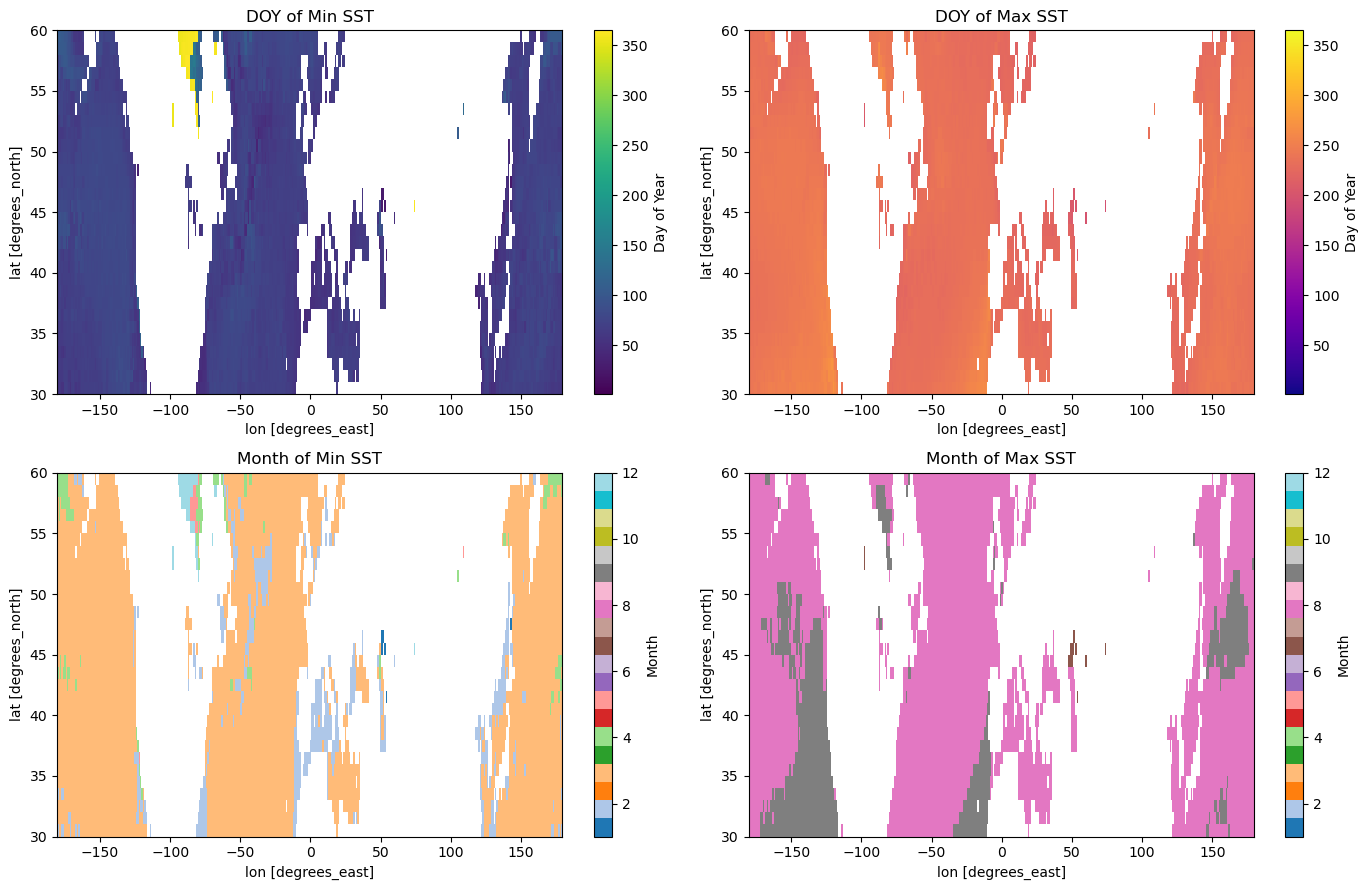

In [197]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# ---------- Step 1: min/max doy 계산 (NaN 안전하게) ----------
min_doy = DA_ds_mclim.idxmin(dim='doy')
max_doy = DA_ds_mclim.idxmax(dim='doy')

min_doy.name = 'Min SST Day'
max_doy.name = 'Max SST Day'

# ---------- Step 2: DOY → Month 변환 ----------
# 월 경계 (누적 일수) – 윤년 아님
month_bounds = np.array([0, 31, 59, 90, 120, 151, 181,
                         212, 243, 273, 304, 334, 365])

# DOY → 월 매핑 테이블 (1~365 → 1~12)
doy_to_month = np.zeros(366, dtype=int)
for m in range(1, 13):
    doy_to_month[month_bounds[m - 1] + 1: month_bounds[m] + 1] = m

# 안전한 변환 함수 (NaN 유지)
def safe_doy_to_month(doy):
    if np.isnan(doy):
        return np.nan
    else:
        return doy_to_month[int(doy)]

# xarray에서 적용
min_month = xr.apply_ufunc(safe_doy_to_month, min_doy,
                           vectorize=True, output_dtypes=[float])
max_month = xr.apply_ufunc(safe_doy_to_month, max_doy,
                           vectorize=True, output_dtypes=[float])

min_month.name = 'Month of Min SST'
max_month.name = 'Month of Max SST'

# ---------- Step 3: 2x2 Panel Plot ----------
fig, axs = plt.subplots(2, 2, figsize=(14, 9))

# Panel 1: DOY of Min SST
p0 = min_doy.plot(ax=axs[0, 0], cmap="viridis", vmin=1, vmax=365, add_colorbar=False)
axs[0, 0].set_title("DOY of Min SST")
fig.colorbar(p0, ax=axs[0, 0], orientation="vertical", label="Day of Year")

# Panel 2: DOY of Max SST
p1 = max_doy.plot(ax=axs[0, 1], cmap="plasma", vmin=1, vmax=365, add_colorbar=False)
axs[0, 1].set_title("DOY of Max SST")
fig.colorbar(p1, ax=axs[0, 1], orientation="vertical", label="Day of Year")

# Panel 3: Month of Min SST
p2 = min_month.plot(ax=axs[1, 0], cmap="tab20", vmin=1, vmax=12, add_colorbar=False)
axs[1, 0].set_title("Month of Min SST")
fig.colorbar(p2, ax=axs[1, 0], orientation="vertical", label="Month")

# Panel 4: Month of Max SST
p3 = max_month.plot(ax=axs[1, 1], cmap="tab20", vmin=1, vmax=12, add_colorbar=False)
axs[1, 1].set_title("Month of Max SST")
fig.colorbar(p3, ax=axs[1, 1], orientation="vertical", label="Month")

plt.tight_layout()
plt.show()


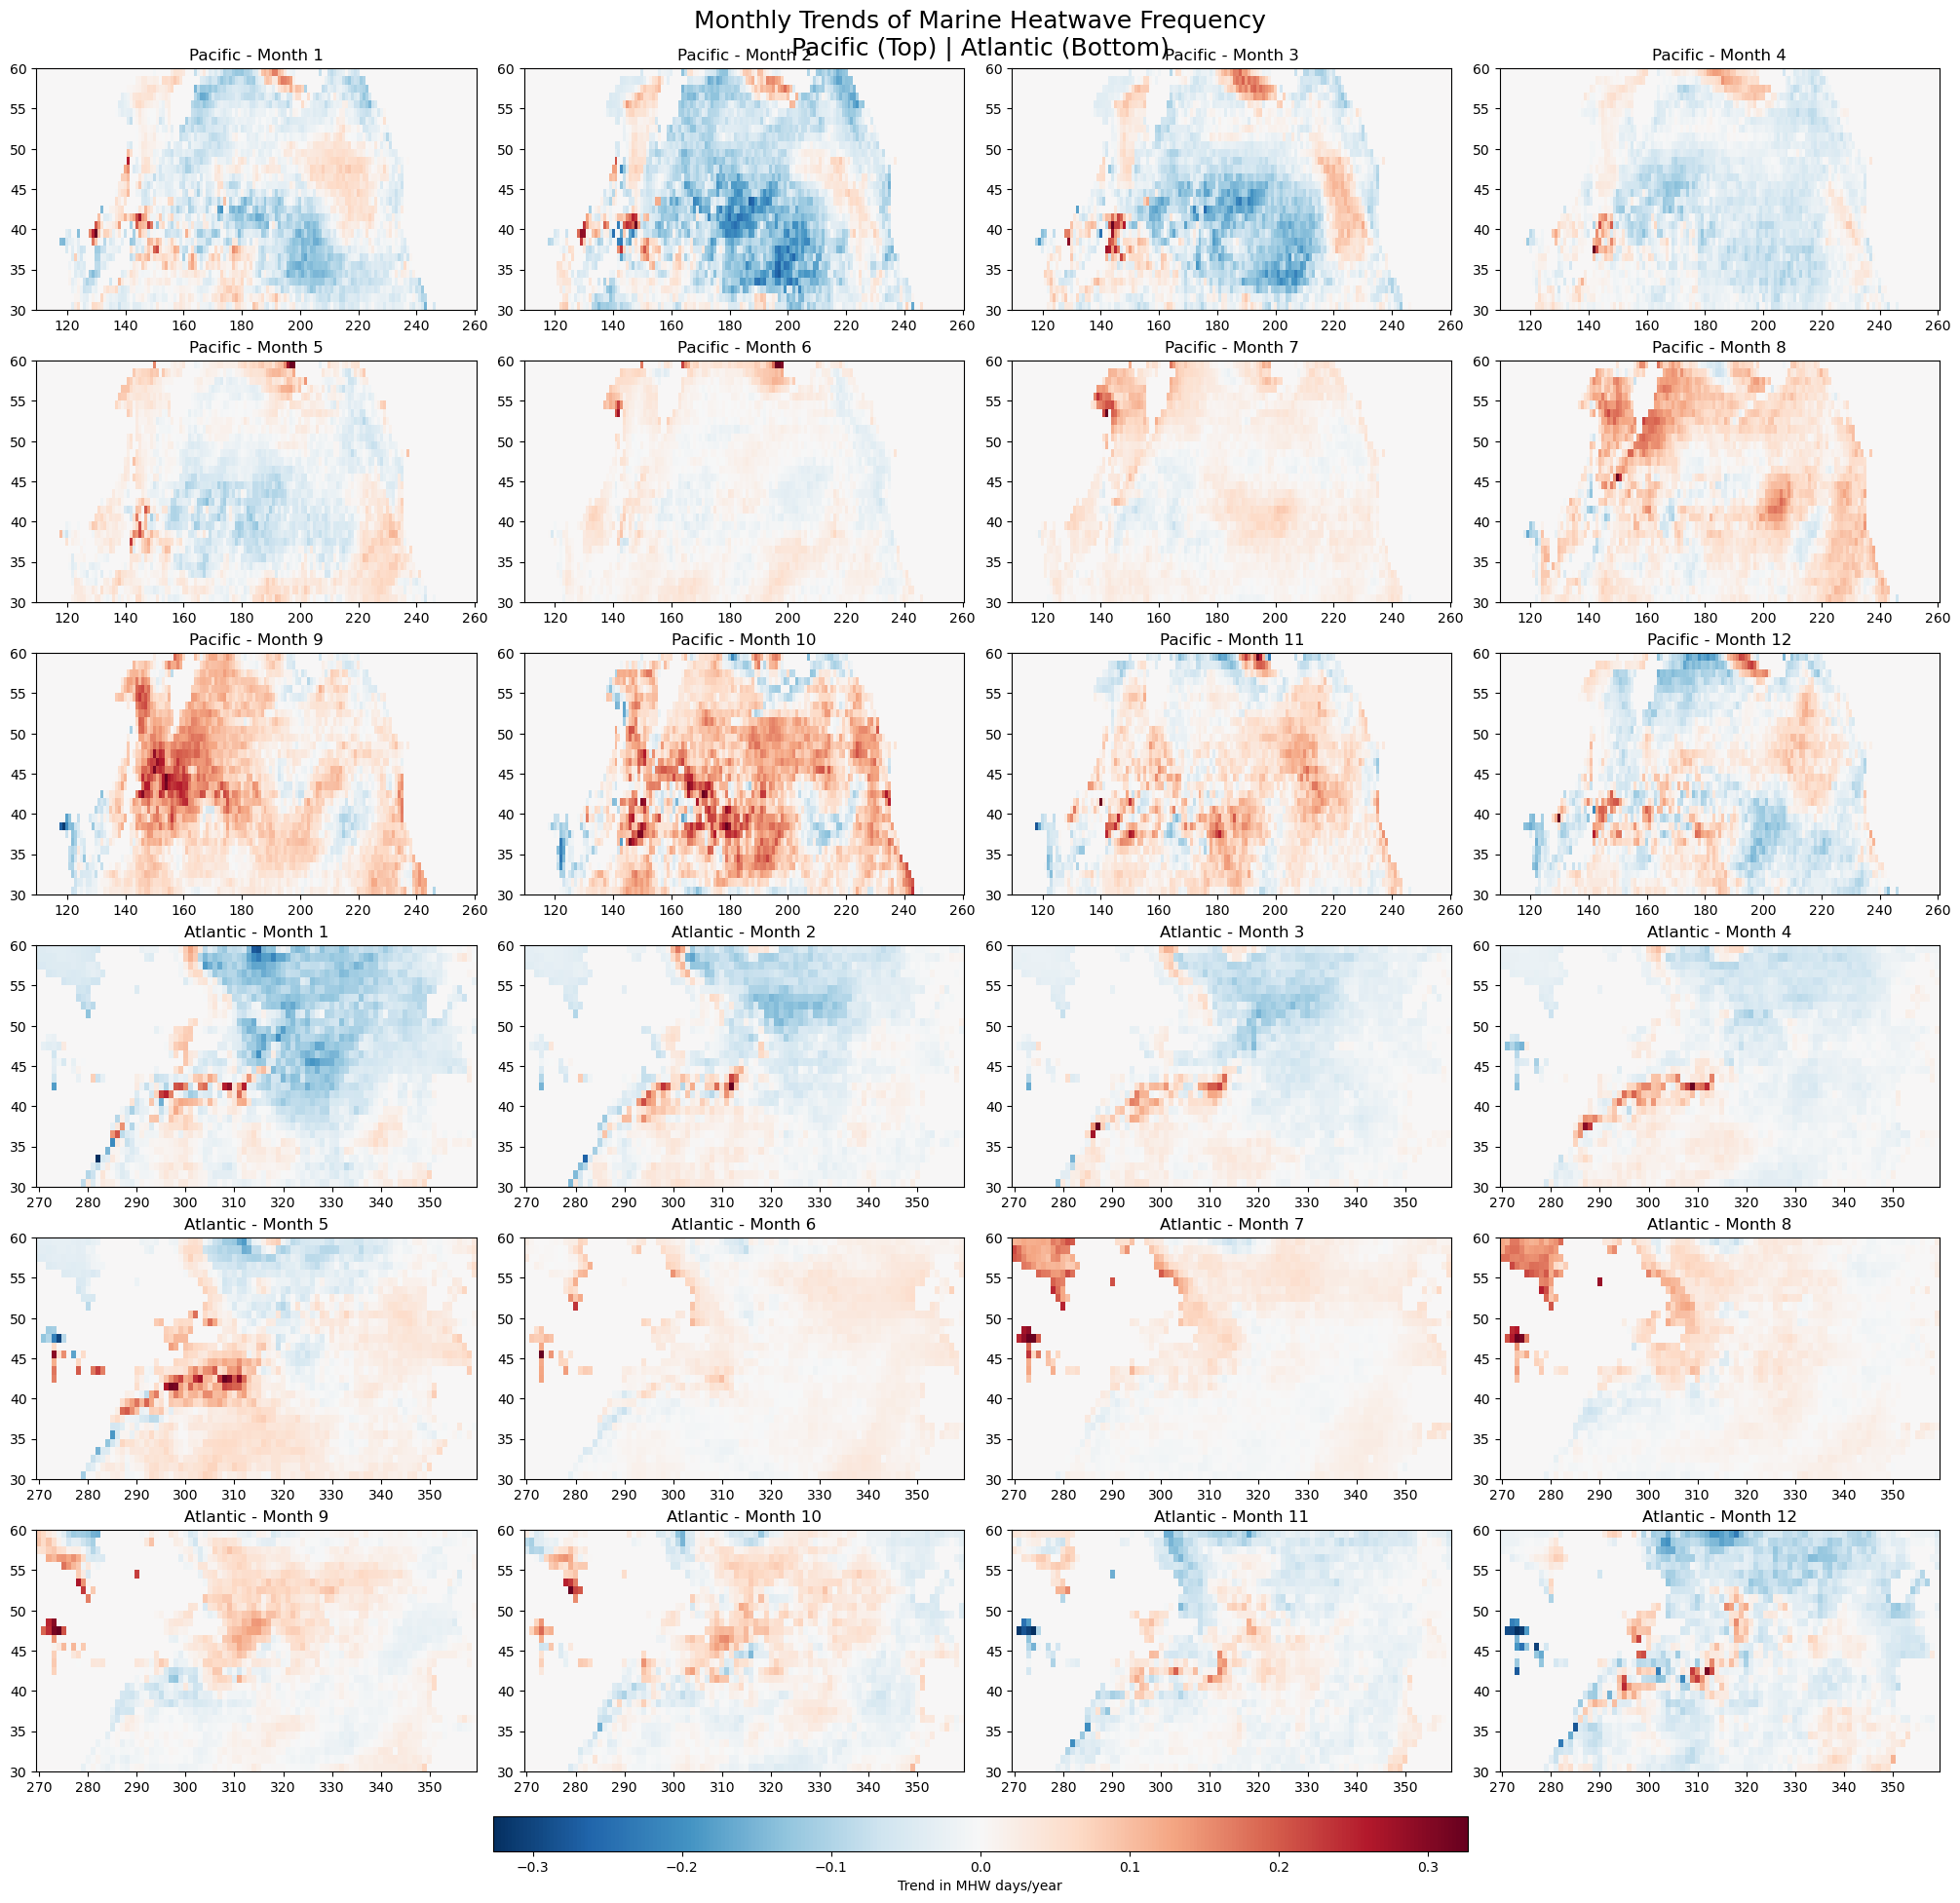

In [283]:
# For intensity

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# ---------- [1] 월/년 정보 추출 ----------
month = mhw_intensity['time'].dt.month
year = mhw_intensity['time'].dt.year

# ---------- [2] 연도-월별 MHW 발생 일수 계산 ----------
# 결과 shape: (year, month, lat, lon)
mhw_monthly = (
    mhw_intensity
    .groupby('time.year')
    .map(lambda x: x.groupby('time.month').sum(dim='time'))
)

# ---------- [3] 선형 추세 계산 함수 ----------
def linear_trend(y, x):
    """간단한 선형 회귀: y = a*x + b → a만 추출"""
    valid = ~np.isnan(y)
    if np.sum(valid) < 2:
        return np.nan
    return np.polyfit(x[valid], y[valid], 1)[0]

# 중심화된 연도 (수치 안정성 위해)
years = mhw_monthly['year']
X = years - years.mean()

# ---------- [4] 월별 trend 계산 ----------
trend_maps = []
for m in range(1, 13):
    y = mhw_monthly.sel(month=m)
    slope = xr.apply_ufunc(
        linear_trend,
        y,
        X,
        input_core_dims=[['year'], ['year']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    slope.name = f"trend_month_{m}"
    trend_maps.append(slope)

# (month, lat, lon)
trend_all_months = xr.concat(trend_maps, dim='month')
trend_all_months['month'] = np.arange(1, 13)


# ---------- [1] lon 0–360 변환 ----------
trend_all_months_360 = trend_all_months.copy()
trend_all_months_360['lon'] = xr.where(
    trend_all_months_360.lon < 0,
    trend_all_months_360.lon + 360,
    trend_all_months_360.lon
)
trend_all_months_360 = trend_all_months_360.sortby('lon')

# ---------- [2] Pacific & Atlantic 영역 ----------
lat_min, lat_max = -60, 60  # 필요시 조절
pacific = trend_all_months_360.sel(lon=slice(110, 260), lat=slice(lat_min, lat_max))
atlantic = trend_all_months_360.sel(lon=slice(270, 380), lat=slice(lat_min, lat_max))



#fig
fig, axs = plt.subplots(6, 4, figsize=(20, 18), constrained_layout=True)

# Pacific (top 3 rows)
for i in range(12):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    da = pacific.sel(month=i + 1)
    p = da.plot(ax=ax, cmap='RdBu_r', center=0, add_colorbar=False)
    ax.set_title(f"Pacific - Month {i+1}")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Atlantic (bottom 3 rows)
for i in range(12):
    row = 3 + (i // 4)
    col = i % 4
    ax = axs[row, col]
    da = atlantic.sel(month=i + 1)
    p = da.plot(ax=ax, cmap='RdBu_r', center=0, add_colorbar=False)
    ax.set_title(f"Atlantic - Month {i+1}")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Colorbar: horizontal, much lower to avoid overlap
cbar_ax = fig.add_axes([0.25, -0.03, 0.5, 0.02])  # ⬅ bottom = 0.015 로 낮춤
fig.colorbar(p, cax=cbar_ax, orientation='horizontal', label="Trend in MHW days/year")

# Title
plt.suptitle("Monthly Trends of Marine Heatwave Frequency\nPacific (Top) | Atlantic (Bottom)",
             fontsize=18, y=1.02)

plt.show()


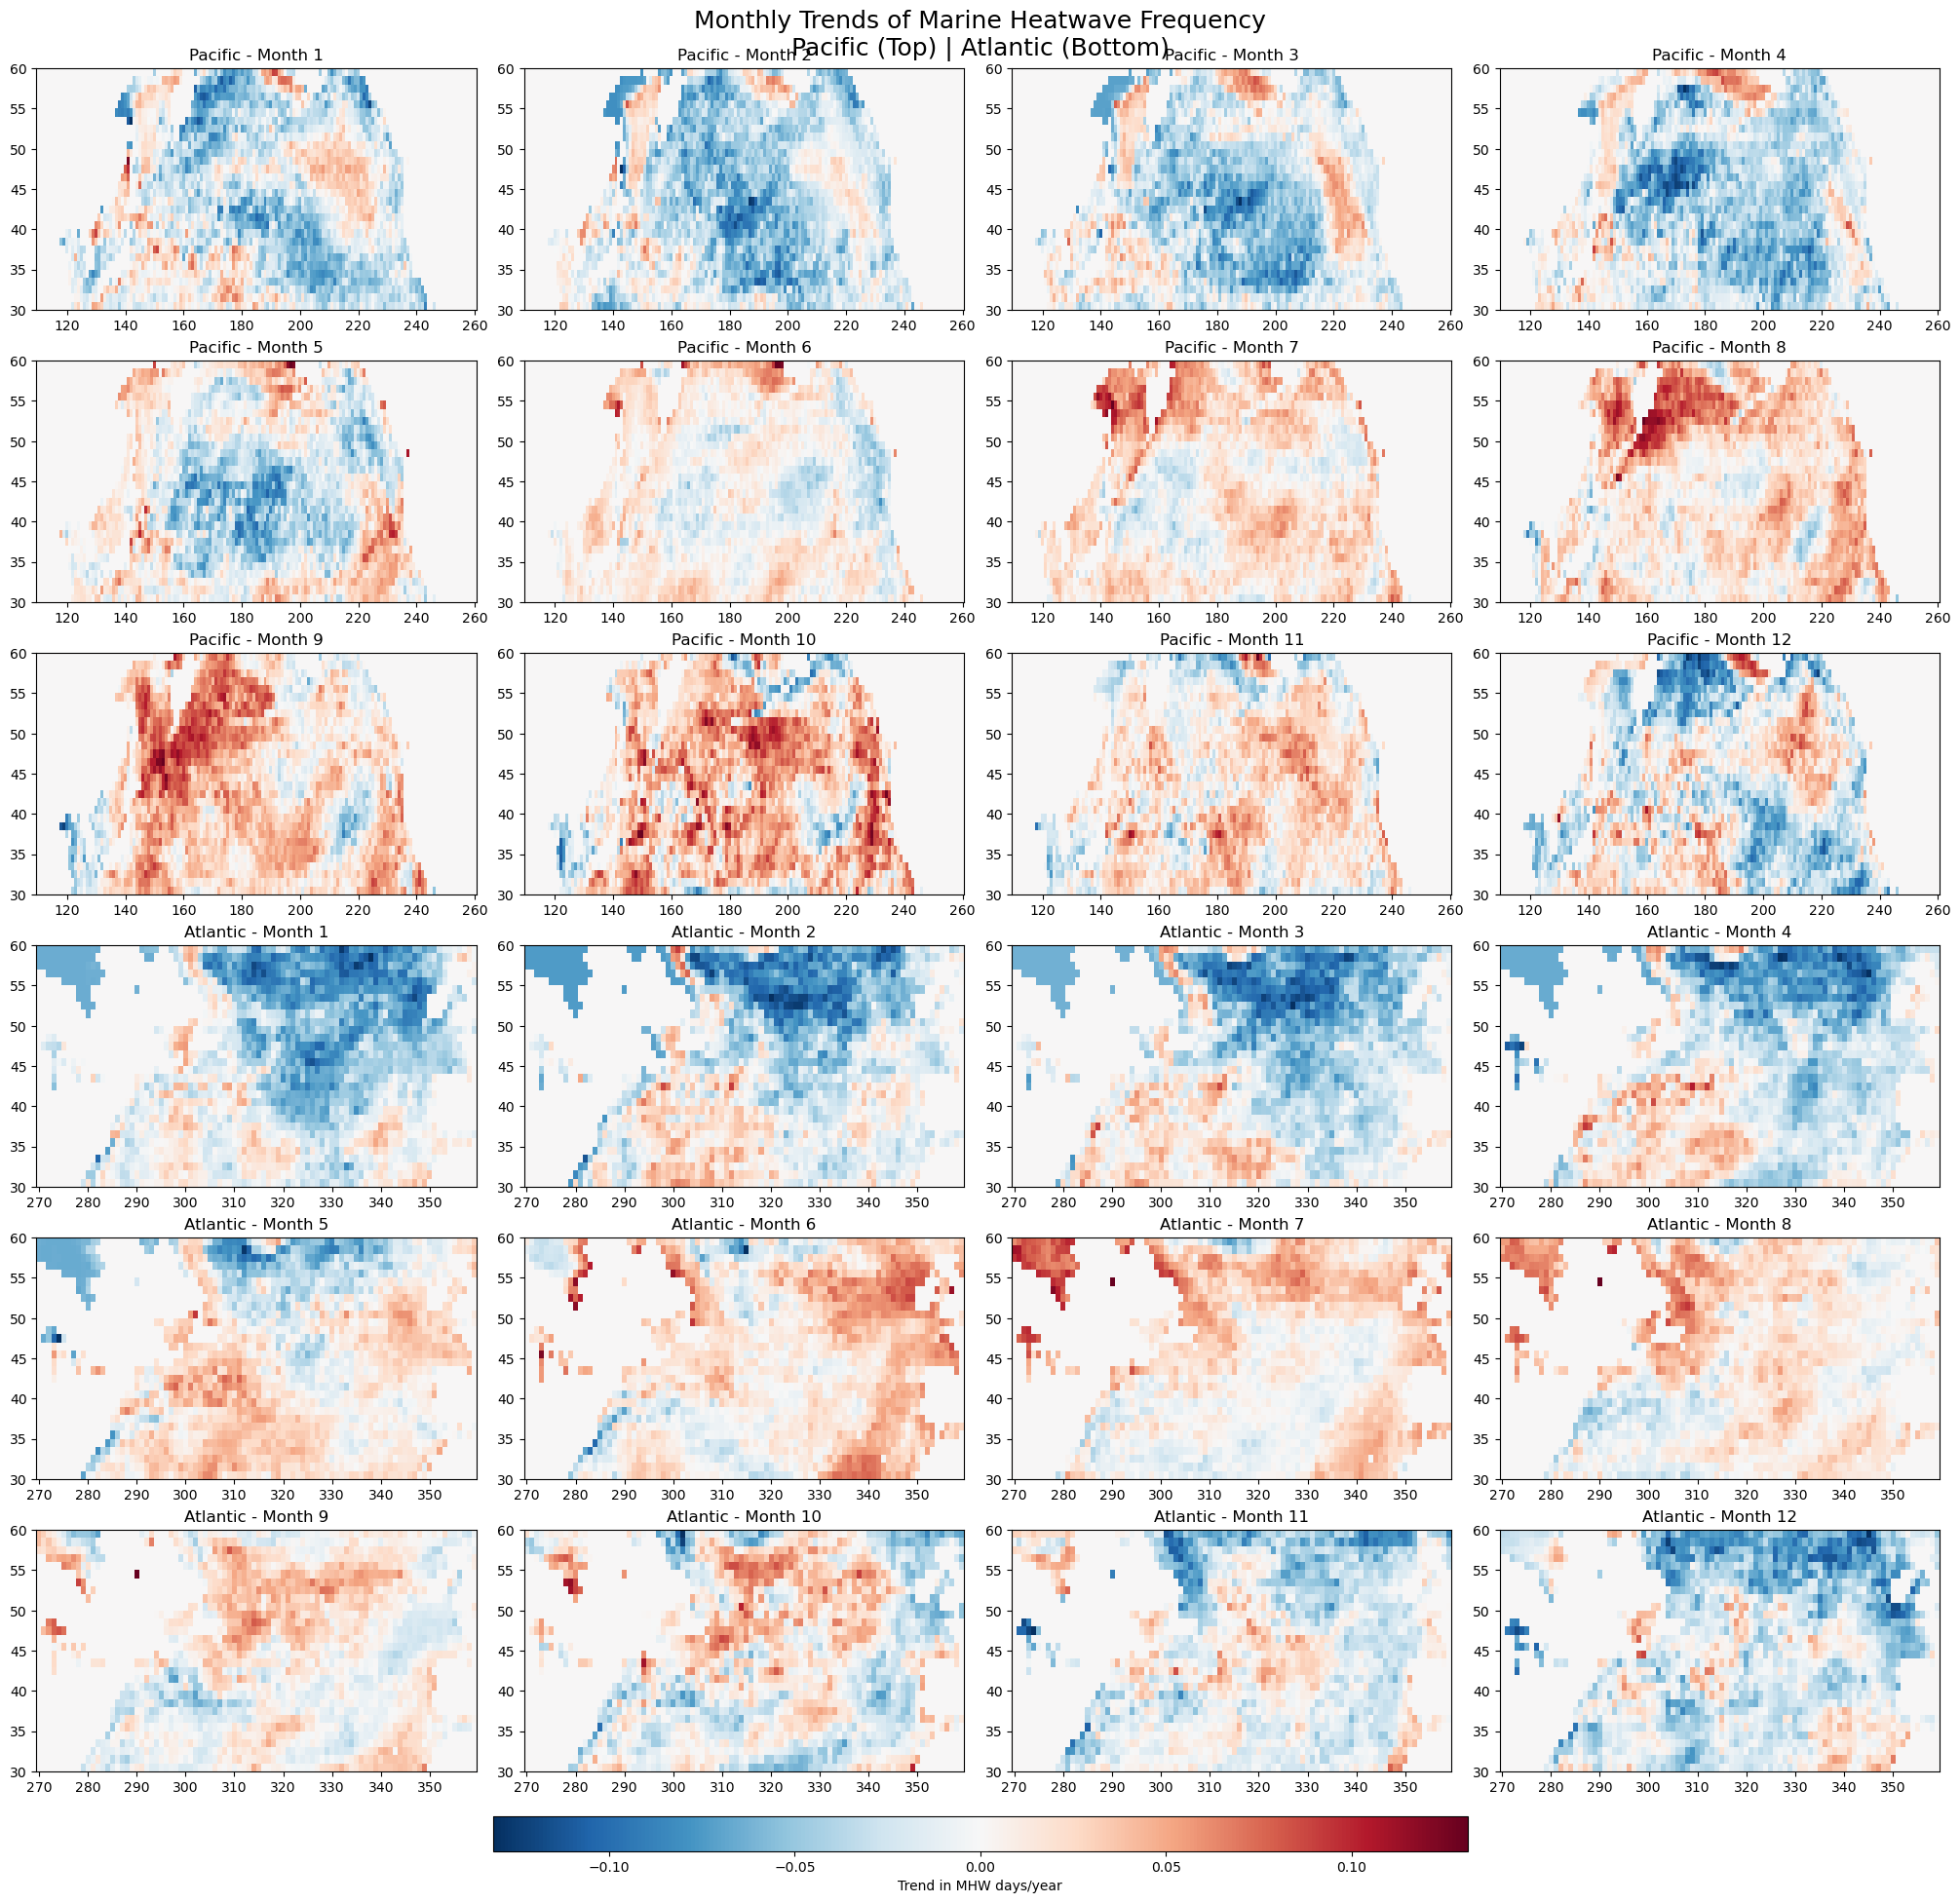

In [205]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# ---------- [1] 월/년 정보 추출 ----------
month = mhw_mask['time'].dt.month
year = mhw_mask['time'].dt.year

# ---------- [2] 연도-월별 MHW 발생 일수 계산 ----------
# 결과 shape: (year, month, lat, lon)
mhw_monthly = (
    mhw_mask
    .groupby('time.year')
    .map(lambda x: x.groupby('time.month').sum(dim='time'))
)

# ---------- [3] 선형 추세 계산 함수 ----------
def linear_trend(y, x):
    """간단한 선형 회귀: y = a*x + b → a만 추출"""
    valid = ~np.isnan(y)
    if np.sum(valid) < 2:
        return np.nan
    return np.polyfit(x[valid], y[valid], 1)[0]

# 중심화된 연도 (수치 안정성 위해)
years = mhw_monthly['year']
X = years - years.mean()

# ---------- [4] 월별 trend 계산 ----------
trend_maps = []
for m in range(1, 13):
    y = mhw_monthly.sel(month=m)
    slope = xr.apply_ufunc(
        linear_trend,
        y,
        X,
        input_core_dims=[['year'], ['year']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    slope.name = f"trend_month_{m}"
    trend_maps.append(slope)

# (month, lat, lon)
trend_all_months = xr.concat(trend_maps, dim='month')
trend_all_months['month'] = np.arange(1, 13)


# ---------- [1] lon 0–360 변환 ----------
trend_all_months_360 = trend_all_months.copy()
trend_all_months_360['lon'] = xr.where(
    trend_all_months_360.lon < 0,
    trend_all_months_360.lon + 360,
    trend_all_months_360.lon
)
trend_all_months_360 = trend_all_months_360.sortby('lon')

# ---------- [2] Pacific & Atlantic 영역 ----------
lat_min, lat_max = -60, 60  # 필요시 조절
pacific = trend_all_months_360.sel(lon=slice(110, 260), lat=slice(lat_min, lat_max))
atlantic = trend_all_months_360.sel(lon=slice(270, 380), lat=slice(lat_min, lat_max))



#fig
fig, axs = plt.subplots(6, 4, figsize=(20, 18), constrained_layout=True)

# Pacific (top 3 rows)
for i in range(12):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    da = pacific.sel(month=i + 1)
    p = da.plot(ax=ax, cmap='RdBu_r', center=0, add_colorbar=False)
    ax.set_title(f"Pacific - Month {i+1}")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Atlantic (bottom 3 rows)
for i in range(12):
    row = 3 + (i // 4)
    col = i % 4
    ax = axs[row, col]
    da = atlantic.sel(month=i + 1)
    p = da.plot(ax=ax, cmap='RdBu_r', center=0, add_colorbar=False)
    ax.set_title(f"Atlantic - Month {i+1}")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Colorbar: horizontal, much lower to avoid overlap
cbar_ax = fig.add_axes([0.25, -0.03, 0.5, 0.02])  # ⬅ bottom = 0.015 로 낮춤
fig.colorbar(p, cax=cbar_ax, orientation='horizontal', label="Trend in MHW days/year")

# Title
plt.suptitle("Monthly Trends of Marine Heatwave Frequency\nPacific (Top) | Atlantic (Bottom)",
             fontsize=18, y=1.02)

plt.show()


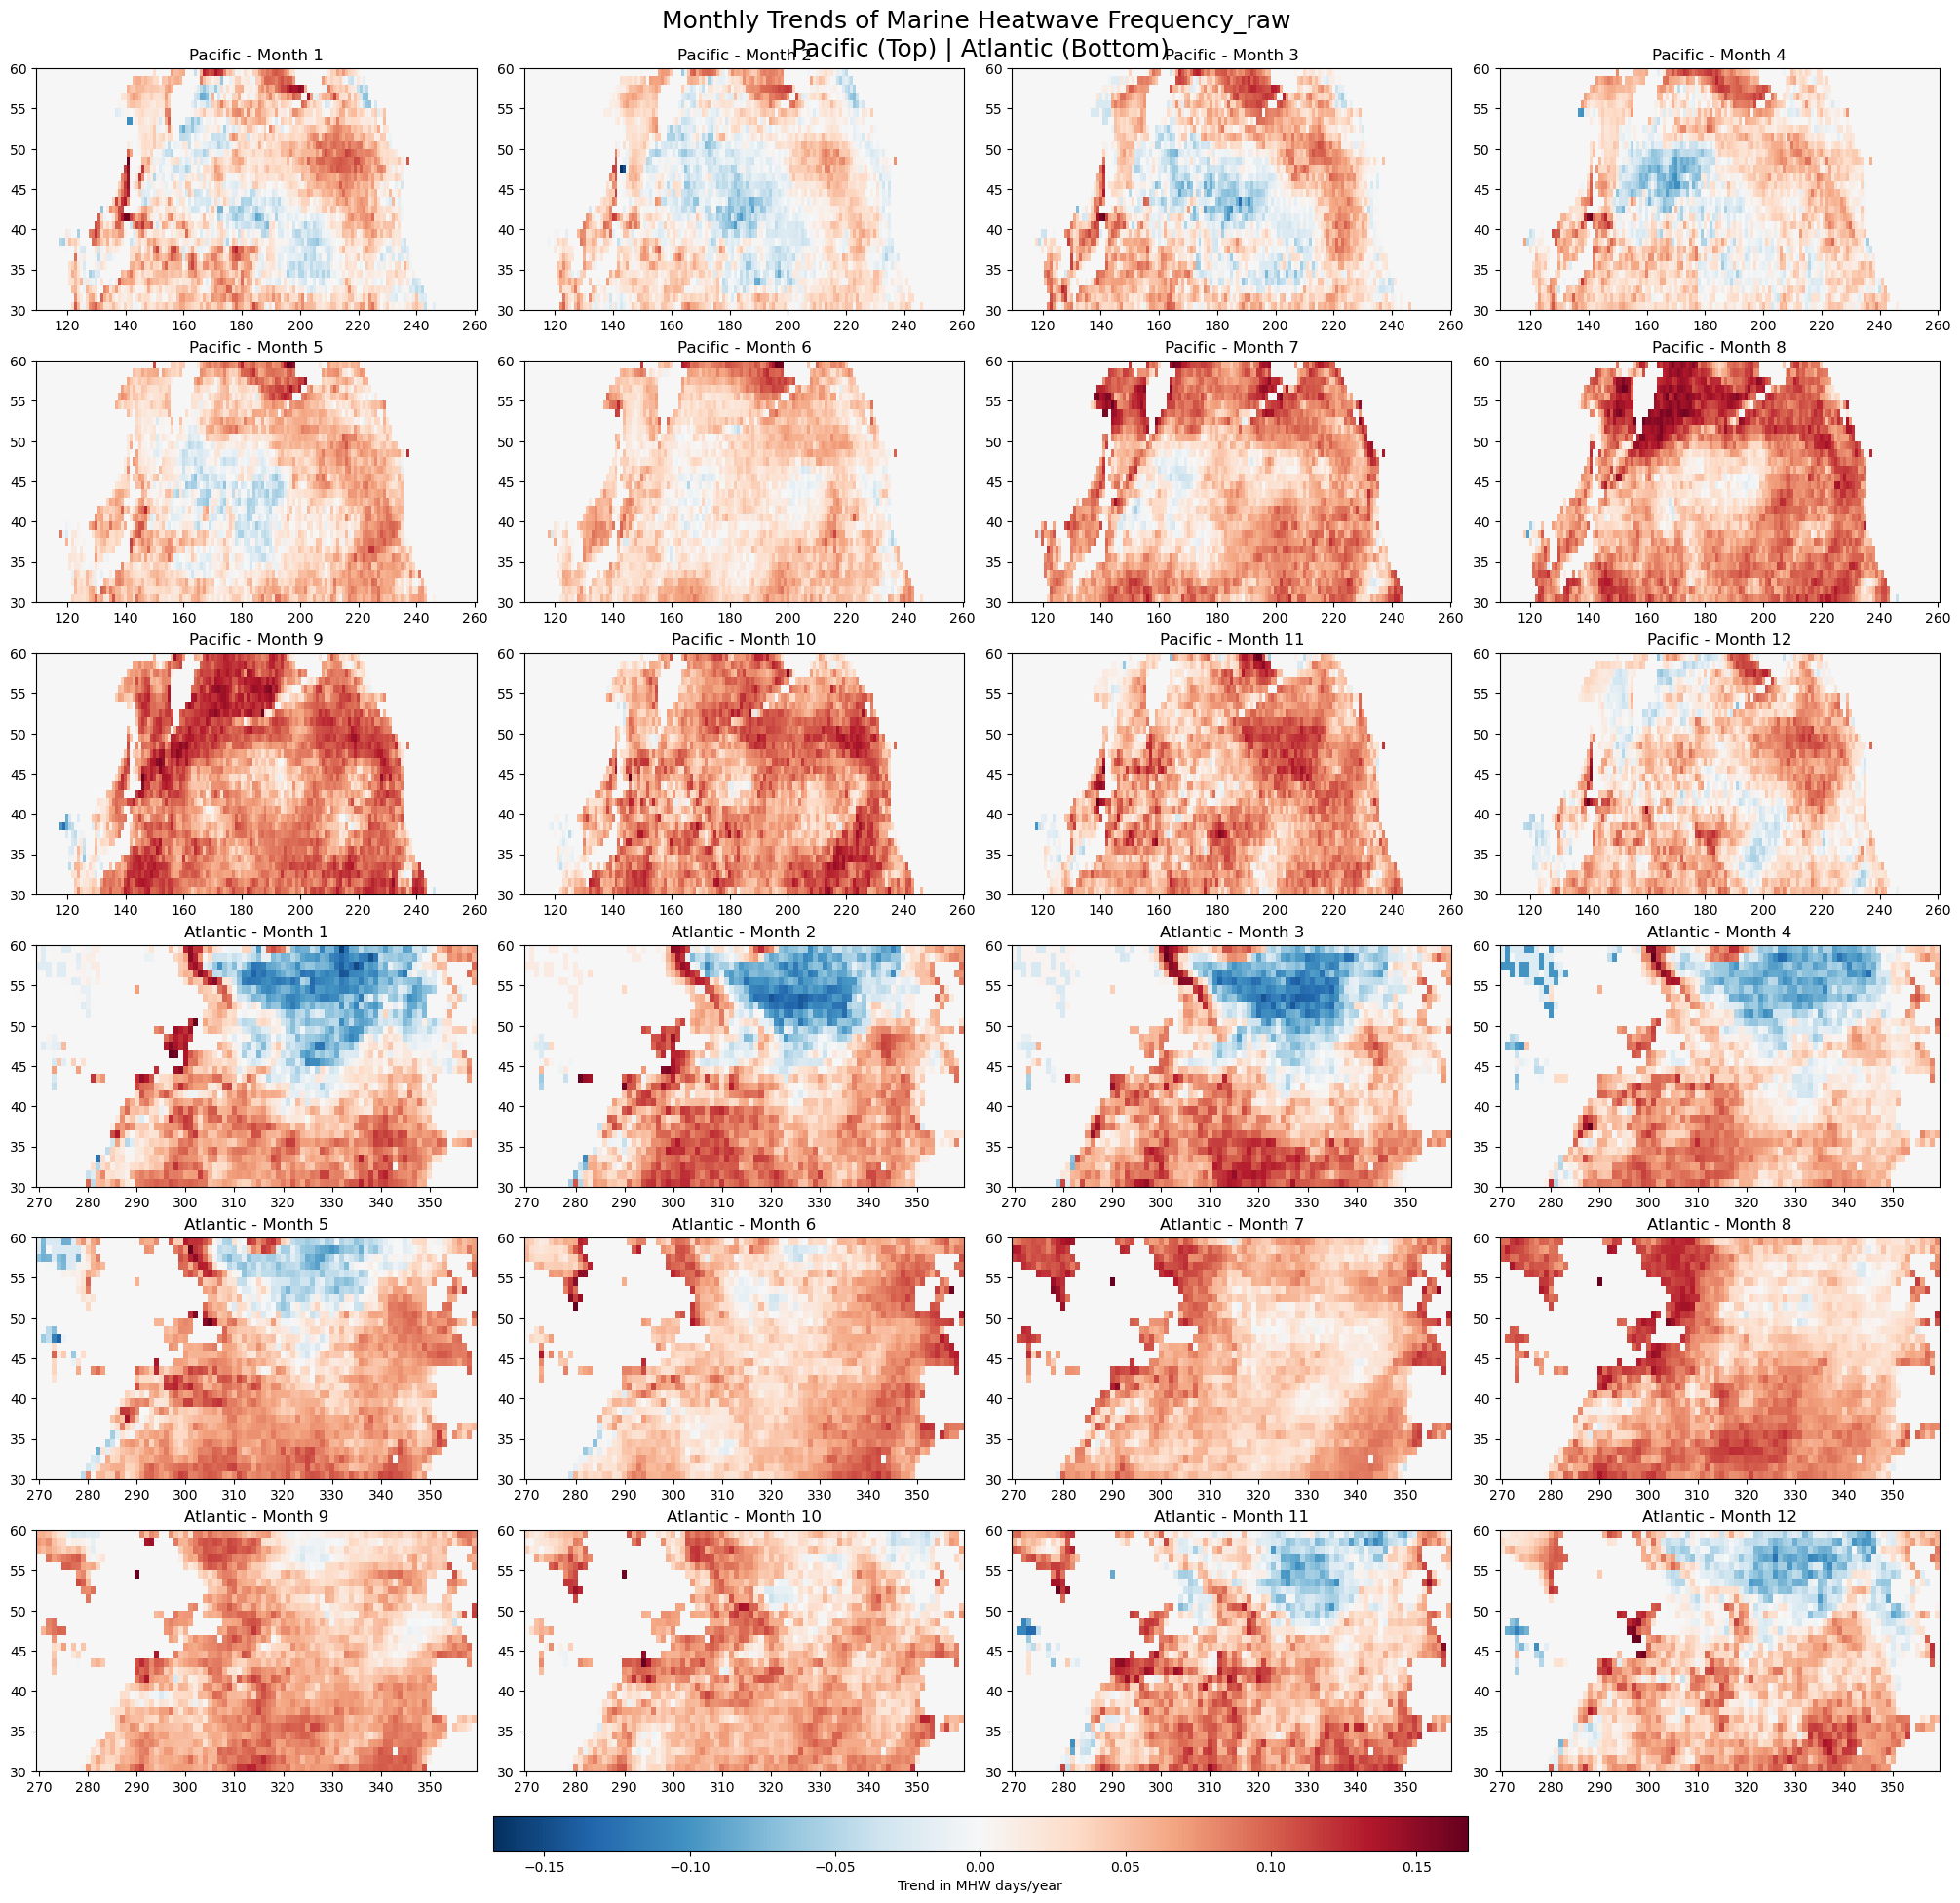

In [223]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# ---------- [1] 월/년 정보 추출 ----------
month = mhw_mask_raw['time'].dt.month
year = mhw_mask_raw['time'].dt.year

# ---------- [2] 연도-월별 MHW 발생 일수 계산 ----------
# 결과 shape: (year, month, lat, lon)
mhw_monthly_raw = (
    mhw_mask_raw
    .groupby('time.year')
    .map(lambda x: x.groupby('time.month').sum(dim='time'))
)

# 중심화된 연도 (수치 안정성 위해)
years = mhw_monthly_raw['year']
X = years - years.mean()

# ---------- [4] 월별 trend 계산 ----------
trend_maps = []
for m in range(1, 13):
    y = mhw_monthly_raw.sel(month=m)
    slope = xr.apply_ufunc(
        linear_trend,
        y,
        X,
        input_core_dims=[['year'], ['year']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    slope.name = f"trend_month_{m}"
    trend_maps.append(slope)

# (month, lat, lon)
trend_all_months_raw = xr.concat(trend_maps, dim='month')
trend_all_months_raw['month'] = np.arange(1, 13)


# ---------- [1] lon 0–360 변환 ----------
trend_all_months_360_raw = trend_all_months_raw.copy()
trend_all_months_360_raw['lon'] = xr.where(
    trend_all_months_360_raw.lon < 0,
    trend_all_months_360_raw.lon + 360,
    trend_all_months_360_raw.lon
)
trend_all_months_360_raw = trend_all_months_360_raw.sortby('lon')

# ---------- [2] Pacific & Atlantic 영역 ----------
lat_min, lat_max = -60, 60  # 필요시 조절
pacific = trend_all_months_360_raw.sel(lon=slice(110, 260), lat=slice(lat_min, lat_max))
atlantic = trend_all_months_360_raw.sel(lon=slice(270, 380), lat=slice(lat_min, lat_max))



#fig
fig, axs = plt.subplots(6, 4, figsize=(20, 18), constrained_layout=True)

# Pacific (top 3 rows)
for i in range(12):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    da = pacific.sel(month=i + 1)
    p = da.plot(ax=ax, cmap='RdBu_r', center=0, add_colorbar=False)
    ax.set_title(f"Pacific - Month {i+1}")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Atlantic (bottom 3 rows)
for i in range(12):
    row = 3 + (i // 4)
    col = i % 4
    ax = axs[row, col]
    da = atlantic.sel(month=i + 1)
    p = da.plot(ax=ax, cmap='RdBu_r', center=0, add_colorbar=False)
    ax.set_title(f"Atlantic - Month {i+1}")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Colorbar: horizontal, much lower to avoid overlap
cbar_ax = fig.add_axes([0.25, -0.03, 0.5, 0.02])  # ⬅ bottom = 0.015 로 낮춤
fig.colorbar(p, cax=cbar_ax, orientation='horizontal', label="Trend in MHW days/year")

# Title
plt.suptitle("Monthly Trends of Marine Heatwave Frequency_raw \nPacific (Top) | Atlantic (Bottom)",
             fontsize=18, y=1.02)

plt.show()


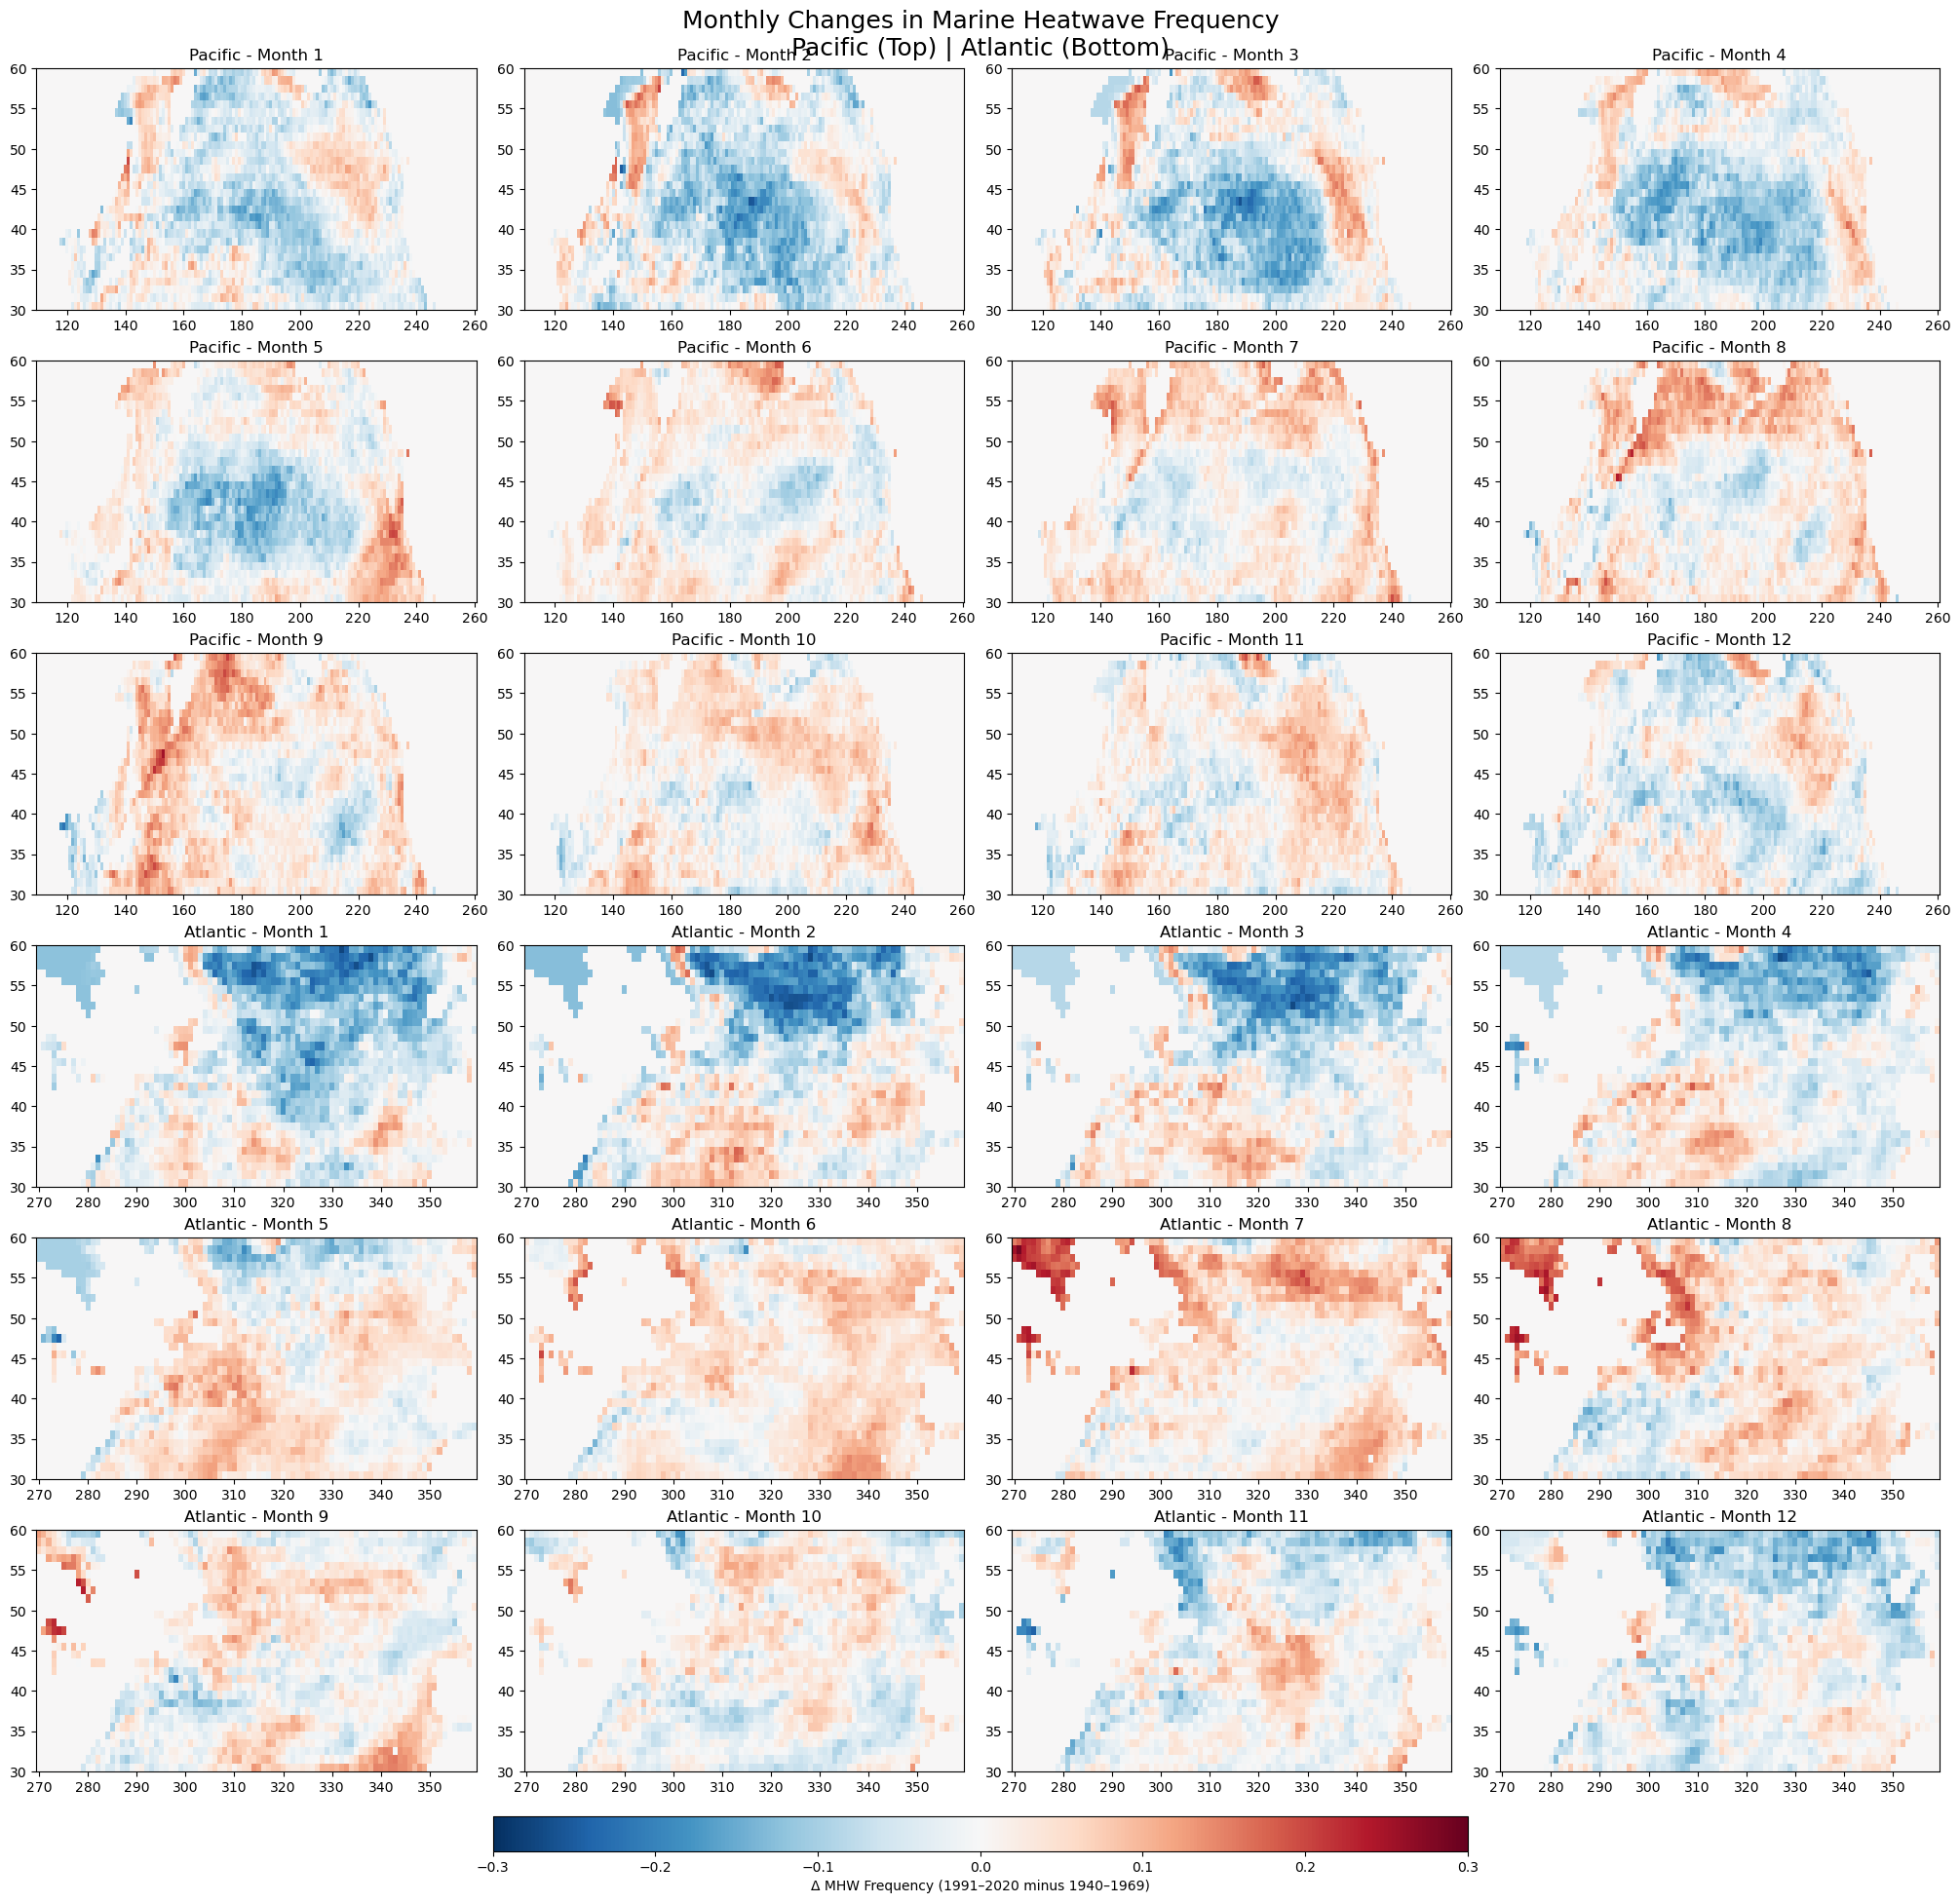

In [312]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 1. mask → float (1=heatwave, 0=not)
mhw_mask_float = mhw_mask.astype(float)

# 2. 월 정보 추가
mhw_mask_float = mhw_mask_float.assign_coords(month=mhw_mask_float['time'].dt.month)

# 3. 시기별 선택 및 월 평균 계산
def monthly_avg(data, start, end):
    subset = data.sel(time=slice(f"{start}-01-01", f"{end}-12-31"))
    return subset.groupby('month').mean(dim='time', skipna=True)

mask_40_69 = monthly_avg(mhw_mask_float, 1940, 1969)
mask_91_20 = monthly_avg(mhw_mask_float, 1991, 2020)

# 4. 차이 계산 (1991–2020 minus 1940–1969)
mask_diff = mask_91_20 - mask_40_69  # shape: (month, lat, lon)

# 5. lon → 0–360 변환
mask_diff_360 = mask_diff.copy()
mask_diff_360['lon'] = xr.where(mask_diff_360.lon < 0, mask_diff_360.lon + 360, mask_diff_360.lon)
mask_diff_360 = mask_diff_360.sortby('lon')

# 6. Pacific & Atlantic 나누기
lat_min, lat_max = -60, 60  # 조정 가능
pacific = mask_diff_360.sel(lon=slice(110, 260), lat=slice(lat_min, lat_max))
atlantic = mask_diff_360.sel(lon=slice(270, 380), lat=slice(lat_min, lat_max))

# 7. 시각화 (6x4 panel: 12달 x 2영역)
fig, axs = plt.subplots(6, 4, figsize=(20, 18), constrained_layout=True)

# Pacific (Top 3 rows)
for i in range(12):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    da = pacific.sel(month=i + 1)
    p = da.plot(ax=ax, cmap='RdBu_r', center=0, add_colorbar=False, vmin=-0.3, vmax=0.3)
    ax.set_title(f"Pacific - Month {i+1}")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Atlantic (Bottom 3 rows)
for i in range(12):
    row = 3 + (i // 4)
    col = i % 4
    ax = axs[row, col]
    da = atlantic.sel(month=i + 1)
    p = da.plot(ax=ax, cmap='RdBu_r', center=0, add_colorbar=False, vmin=-0.3, vmax=0.3)
    ax.set_title(f"Atlantic - Month {i+1}")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Colorbar: 아래 수평
cbar_ax = fig.add_axes([0.25, -0.03, 0.5, 0.02])
fig.colorbar(p, cax=cbar_ax, orientation='horizontal', label="Δ MHW Frequency (1991–2020 minus 1940–1969)")

# 전체 제목
plt.suptitle("Monthly Changes in Marine Heatwave Frequency\nPacific (Top) | Atlantic (Bottom)",
             fontsize=18, y=1.02)

plt.show()


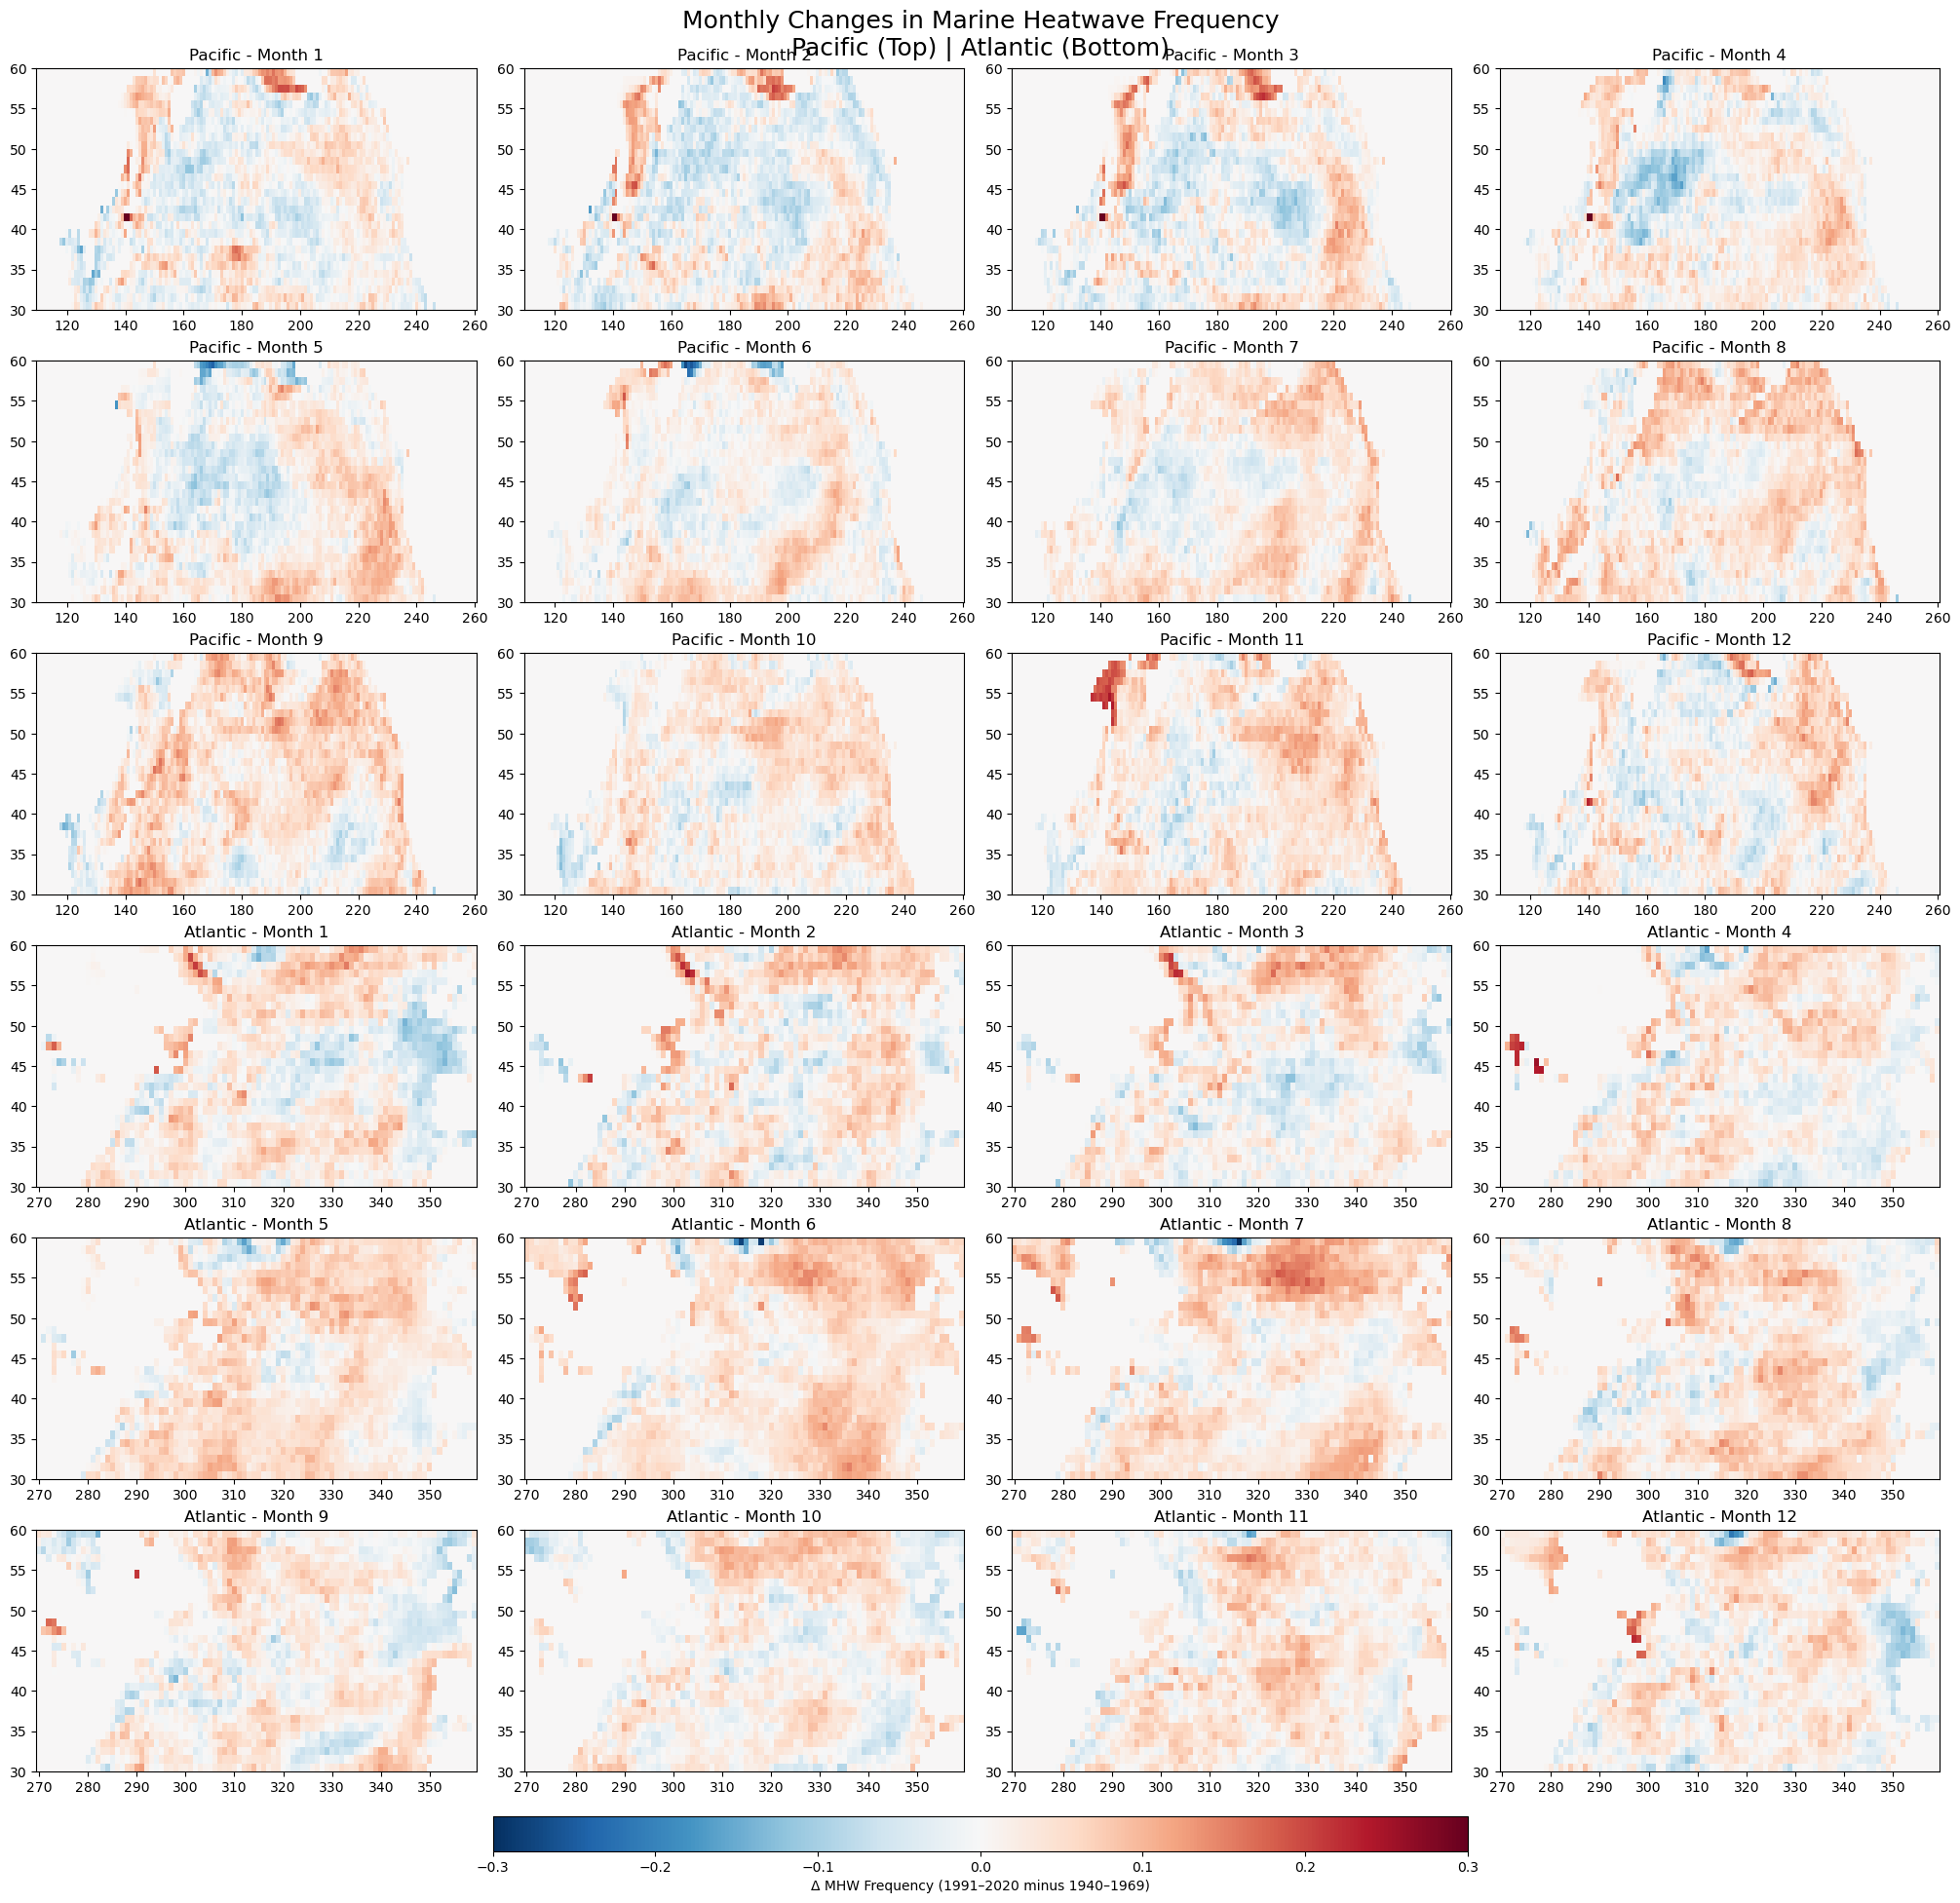

In [307]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 1. mask → float (1=heatwave, 0=not)
mhw_mask_float = mhw_mask_adj.astype(float)

# 2. 월 정보 추가
mhw_mask_float = mhw_mask_float.assign_coords(month=mhw_mask_float['time'].dt.month)

# 3. 시기별 선택 및 월 평균 계산
def monthly_avg(data, start, end):
    subset = data.sel(time=slice(f"{start}-01-01", f"{end}-12-31"))
    return subset.groupby('month').mean(dim='time', skipna=True)

mask_40_69 = monthly_avg(mhw_mask_float, 1940, 1969)
mask_91_20 = monthly_avg(mhw_mask_float, 1991, 2020)

# 4. 차이 계산 (1991–2020 minus 1940–1969)
mask_diff = mask_91_20 - mask_40_69  # shape: (month, lat, lon)

# 5. lon → 0–360 변환
mask_diff_360 = mask_diff.copy()
mask_diff_360['lon'] = xr.where(mask_diff_360.lon < 0, mask_diff_360.lon + 360, mask_diff_360.lon)
mask_diff_360 = mask_diff_360.sortby('lon')

# 6. Pacific & Atlantic 나누기
lat_min, lat_max = -60, 60  # 조정 가능
pacific = mask_diff_360.sel(lon=slice(110, 260), lat=slice(lat_min, lat_max))
atlantic = mask_diff_360.sel(lon=slice(270, 380), lat=slice(lat_min, lat_max))

# 7. 시각화 (6x4 panel: 12달 x 2영역)
fig, axs = plt.subplots(6, 4, figsize=(20, 18), constrained_layout=True)

# Pacific (Top 3 rows)
for i in range(12):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    da = pacific.sel(month=i + 1)
    p = da.plot(ax=ax, cmap='RdBu_r', center=0, add_colorbar=False, vmin=-0.3, vmax=0.3)
    ax.set_title(f"Pacific - Month {i+1}")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Atlantic (Bottom 3 rows)
for i in range(12):
    row = 3 + (i // 4)
    col = i % 4
    ax = axs[row, col]
    da = atlantic.sel(month=i + 1)
    p = da.plot(ax=ax, cmap='RdBu_r', center=0, add_colorbar=False, vmin=-0.3, vmax=0.3)
    ax.set_title(f"Atlantic - Month {i+1}")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Colorbar: 아래 수평
cbar_ax = fig.add_axes([0.25, -0.03, 0.5, 0.02])
fig.colorbar(p, cax=cbar_ax, orientation='horizontal', label="Δ MHW Frequency (1991–2020 minus 1940–1969)")

# 전체 제목
plt.suptitle("Monthly Changes in Marine Heatwave Frequency\nPacific (Top) | Atlantic (Bottom)",
             fontsize=18, y=1.02)

plt.show()


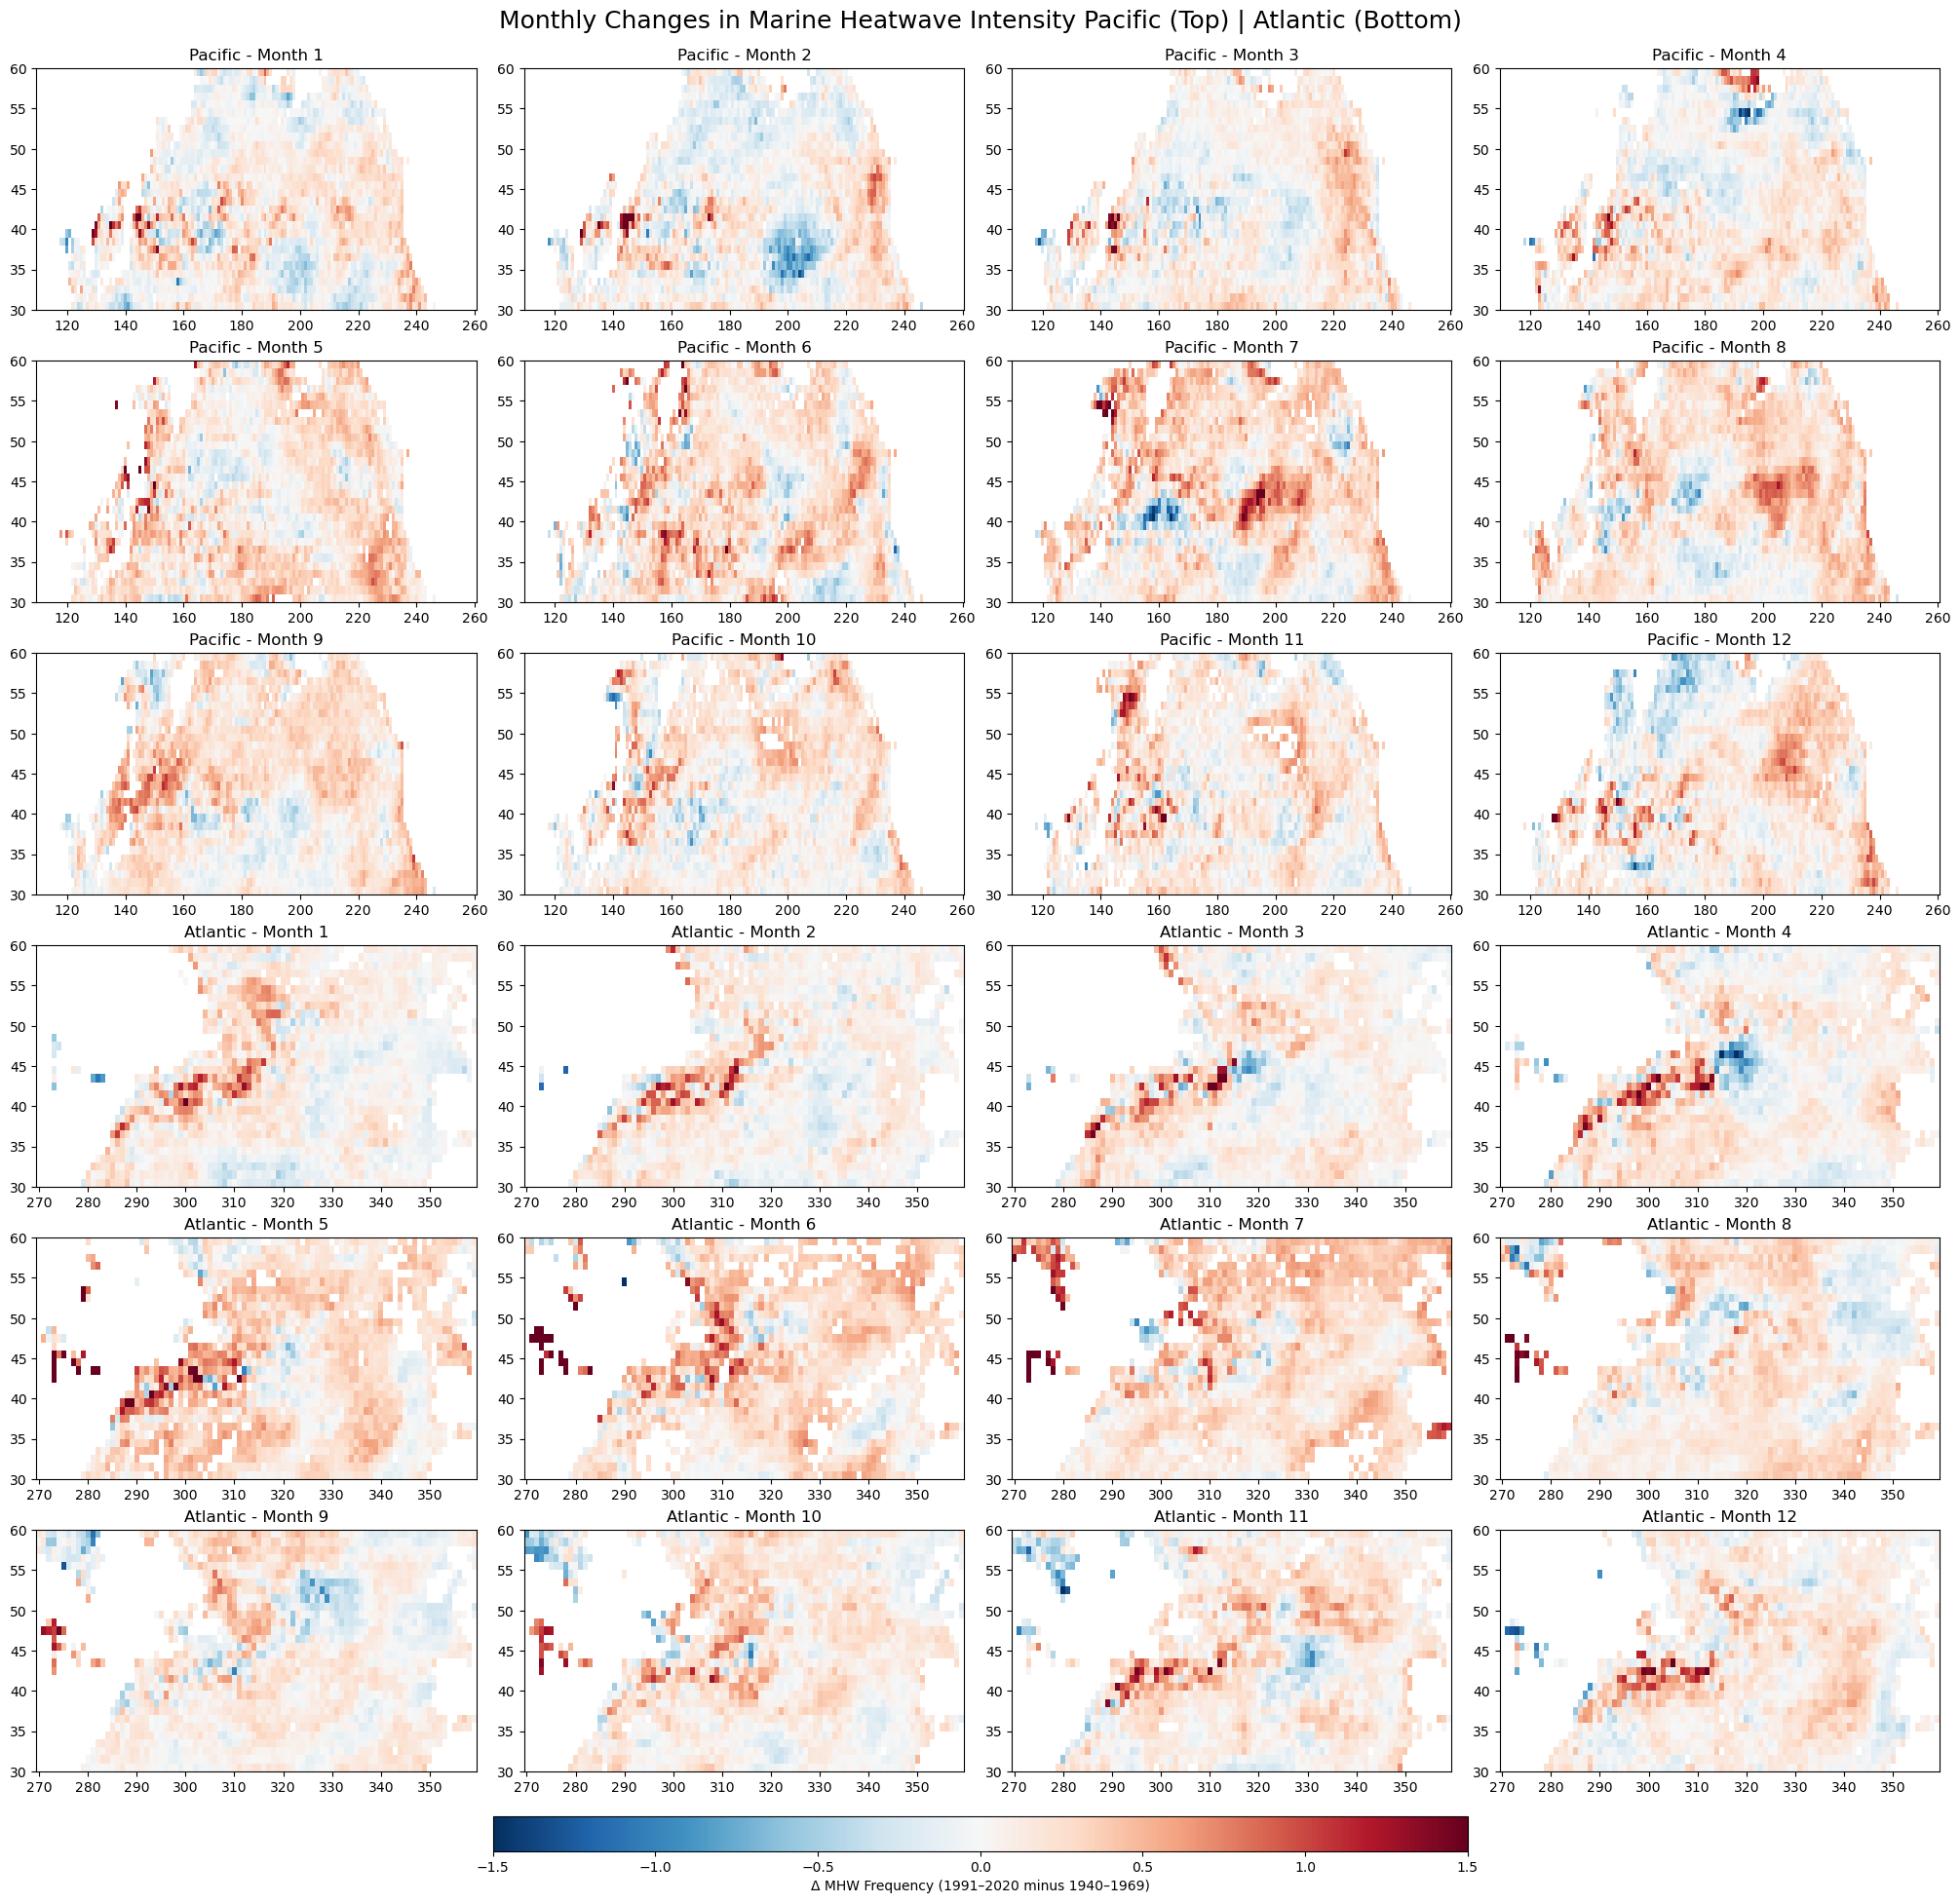

In [315]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 1. mask → float (1=heatwave, 0=not)
mhw_mask_float = mhw_intensity_adj.astype(float)

# 2. 월 정보 추가
mhw_mask_float = mhw_mask_float.assign_coords(month=mhw_mask_float['time'].dt.month)

# 3. 시기별 선택 및 월 평균 계산
def monthly_avg(data, start, end):
    subset = data.sel(time=slice(f"{start}-01-01", f"{end}-12-31"))
    return subset.groupby('month').mean(dim='time', skipna=True)

mask_40_69 = monthly_avg(mhw_mask_float, 1940, 1969)
mask_91_20 = monthly_avg(mhw_mask_float, 1991, 2020)

# 4. 차이 계산 (1991–2020 minus 1940–1969)
mask_diff = mask_91_20 - mask_40_69  # shape: (month, lat, lon)

# 5. lon → 0–360 변환
mask_diff_360 = mask_diff.copy()
mask_diff_360['lon'] = xr.where(mask_diff_360.lon < 0, mask_diff_360.lon + 360, mask_diff_360.lon)
mask_diff_360 = mask_diff_360.sortby('lon')

# 6. Pacific & Atlantic 나누기
lat_min, lat_max = -60, 60  # 조정 가능
pacific = mask_diff_360.sel(lon=slice(110, 260), lat=slice(lat_min, lat_max))
atlantic = mask_diff_360.sel(lon=slice(270, 380), lat=slice(lat_min, lat_max))

# 7. 시각화 (6x4 panel: 12달 x 2영역)
fig, axs = plt.subplots(6, 4, figsize=(20, 18), constrained_layout=True)

# Pacific (Top 3 rows)
for i in range(12):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    da = pacific.sel(month=i + 1)
    p = da.plot(ax=ax, cmap='RdBu_r', center=0, add_colorbar=False, vmin=-1.5, vmax=1.5)
    ax.set_title(f"Pacific - Month {i+1}")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Atlantic (Bottom 3 rows)
for i in range(12):
    row = 3 + (i // 4)
    col = i % 4
    ax = axs[row, col]
    da = atlantic.sel(month=i + 1)
    p = da.plot(ax=ax, cmap='RdBu_r', center=0, add_colorbar=False, vmin=-1.5, vmax=1.5)
    ax.set_title(f"Atlantic - Month {i+1}")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Colorbar: 아래 수평
cbar_ax = fig.add_axes([0.25, -0.03, 0.5, 0.02])
fig.colorbar(p, cax=cbar_ax, orientation='horizontal', label="Δ MHW Frequency (1991–2020 minus 1940–1969)")

# 전체 제목
plt.suptitle("Monthly Changes in Marine Heatwave Intensity Pacific (Top) | Atlantic (Bottom)",
             fontsize=18, y=1.02)

plt.show()


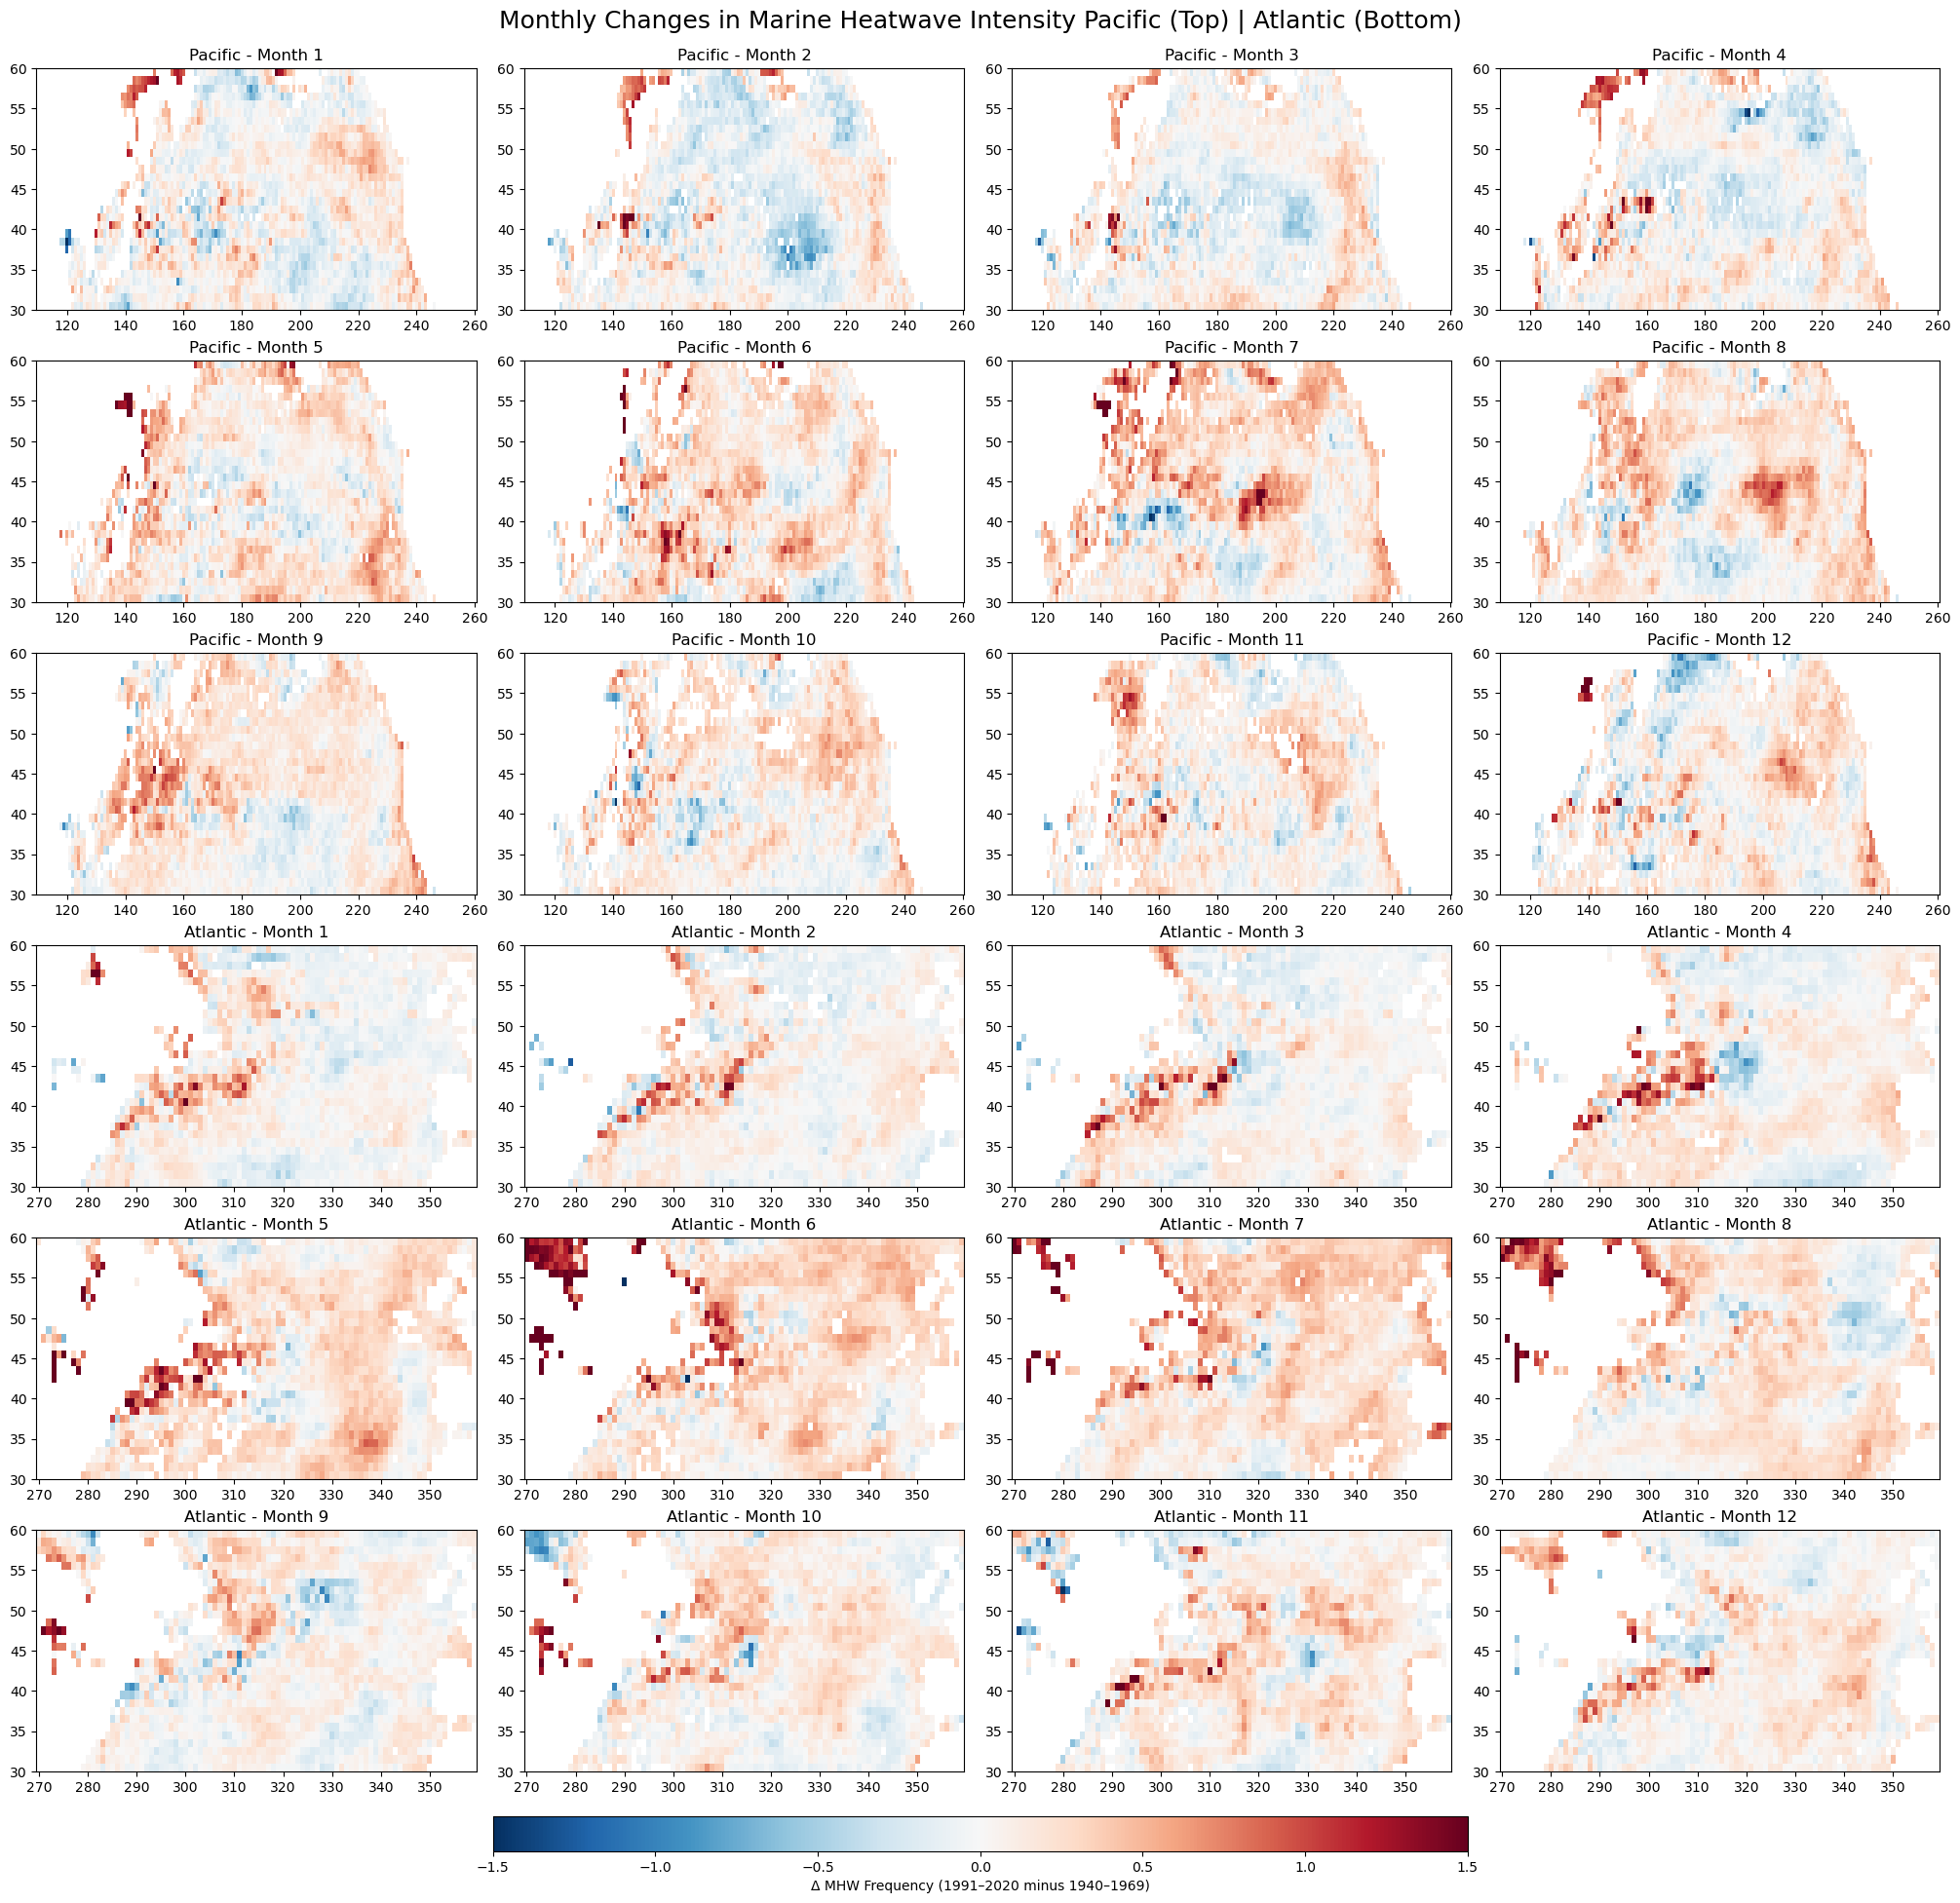

In [316]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 1. mask → float (1=heatwave, 0=not)
mhw_mask_float = mhw_intensity.astype(float)

# 2. 월 정보 추가
mhw_mask_float = mhw_mask_float.assign_coords(month=mhw_mask_float['time'].dt.month)

# 3. 시기별 선택 및 월 평균 계산
def monthly_avg(data, start, end):
    subset = data.sel(time=slice(f"{start}-01-01", f"{end}-12-31"))
    return subset.groupby('month').mean(dim='time', skipna=True)

mask_40_69 = monthly_avg(mhw_mask_float, 1940, 1969)
mask_91_20 = monthly_avg(mhw_mask_float, 1991, 2020)

# 4. 차이 계산 (1991–2020 minus 1940–1969)
mask_diff = mask_91_20 - mask_40_69  # shape: (month, lat, lon)

# 5. lon → 0–360 변환
mask_diff_360 = mask_diff.copy()
mask_diff_360['lon'] = xr.where(mask_diff_360.lon < 0, mask_diff_360.lon + 360, mask_diff_360.lon)
mask_diff_360 = mask_diff_360.sortby('lon')

# 6. Pacific & Atlantic 나누기
lat_min, lat_max = -60, 60  # 조정 가능
pacific = mask_diff_360.sel(lon=slice(110, 260), lat=slice(lat_min, lat_max))
atlantic = mask_diff_360.sel(lon=slice(270, 380), lat=slice(lat_min, lat_max))

# 7. 시각화 (6x4 panel: 12달 x 2영역)
fig, axs = plt.subplots(6, 4, figsize=(20, 18), constrained_layout=True)

# Pacific (Top 3 rows)
for i in range(12):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    da = pacific.sel(month=i + 1)
    p = da.plot(ax=ax, cmap='RdBu_r', center=0, add_colorbar=False, vmin=-1.5, vmax=1.5)
    ax.set_title(f"Pacific - Month {i+1}")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Atlantic (Bottom 3 rows)
for i in range(12):
    row = 3 + (i // 4)
    col = i % 4
    ax = axs[row, col]
    da = atlantic.sel(month=i + 1)
    p = da.plot(ax=ax, cmap='RdBu_r', center=0, add_colorbar=False, vmin=-1.5, vmax=1.5)
    ax.set_title(f"Atlantic - Month {i+1}")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Colorbar: 아래 수평
cbar_ax = fig.add_axes([0.25, -0.03, 0.5, 0.02])
fig.colorbar(p, cax=cbar_ax, orientation='horizontal', label="Δ MHW Frequency (1991–2020 minus 1940–1969)")

# 전체 제목
plt.suptitle("Monthly Changes in Marine Heatwave Intensity Pacific (Top) | Atlantic (Bottom)",
             fontsize=18, y=1.02)

plt.show()


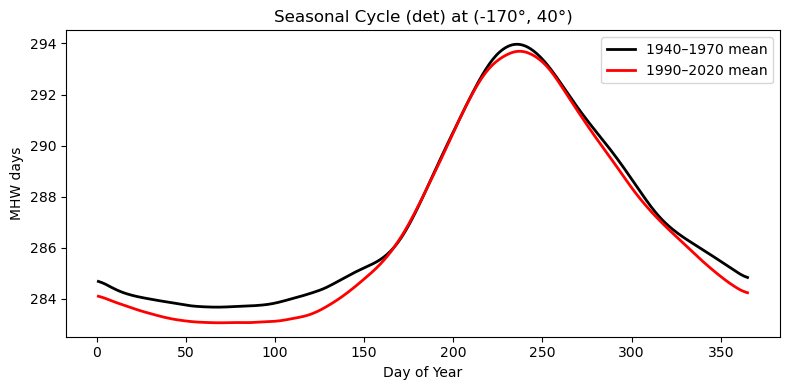

In [270]:
import matplotlib.pyplot as plt

lona = -170
lata = 40

# 1. 평균 seasonal cycle 계산
mean_40_70 = DA_ds_filtered_yearly_clim.sel(year=slice(1940, 1970)).mean(dim='year')
mean_90_20 = DA_ds_filtered_yearly_clim.sel(year=slice(1990, 2020)).mean(dim='year')

# 2. 특정 지점 선택
ts_40_70 = mean_40_70.sel(lon=lona, lat=lata, method='nearest')
ts_90_20 = mean_90_20.sel(lon=lona, lat=lata, method='nearest')

# 3. Plot with legend
fig, ax = plt.subplots(figsize=(8, 4))
ts_40_70.plot(ax=ax, label='1940–1970 mean', color='black', linewidth=2)
ts_90_20.plot(ax=ax, label='1990–2020 mean', color='red', linewidth=2)

# Optional formatting
ax.set_title(f'Seasonal Cycle (det) at ({lona}°, {lata}°)')
ax.set_xlabel('Day of Year')
ax.set_ylabel('MHW days')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

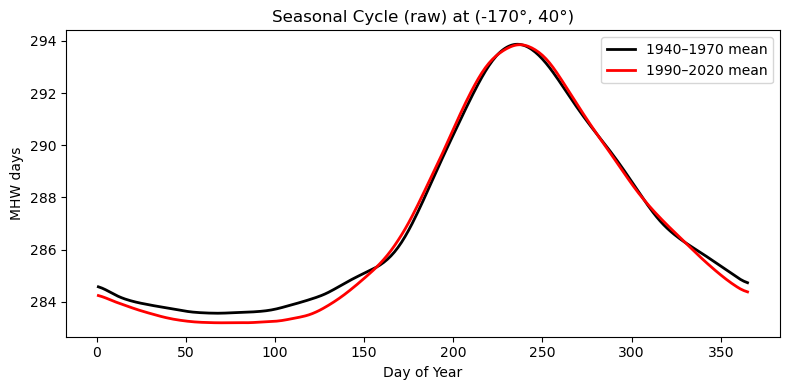

In [271]:
import matplotlib.pyplot as plt

lona = -170
lata = 40

# 1. 평균 seasonal cycle 계산
mean_40_70 = DA_ds_raw_filtered_yearly_clim.sel(year=slice(1940, 1970)).mean(dim='year')
mean_90_20 = DA_ds_raw_filtered_yearly_clim.sel(year=slice(1990, 2020)).mean(dim='year')

# 2. 특정 지점 선택
ts_40_70 = mean_40_70.sel(lon=lona, lat=lata, method='nearest')
ts_90_20 = mean_90_20.sel(lon=lona, lat=lata, method='nearest')

# 3. Plot with legend
fig, ax = plt.subplots(figsize=(8, 4))
ts_40_70.plot(ax=ax, label='1940–1970 mean', color='black', linewidth=2)
ts_90_20.plot(ax=ax, label='1990–2020 mean', color='red', linewidth=2)

# Optional formatting
ax.set_title(f'Seasonal Cycle (raw) at ({lona}°, {lata}°)')
ax.set_xlabel('Day of Year')
ax.set_ylabel('MHW days')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


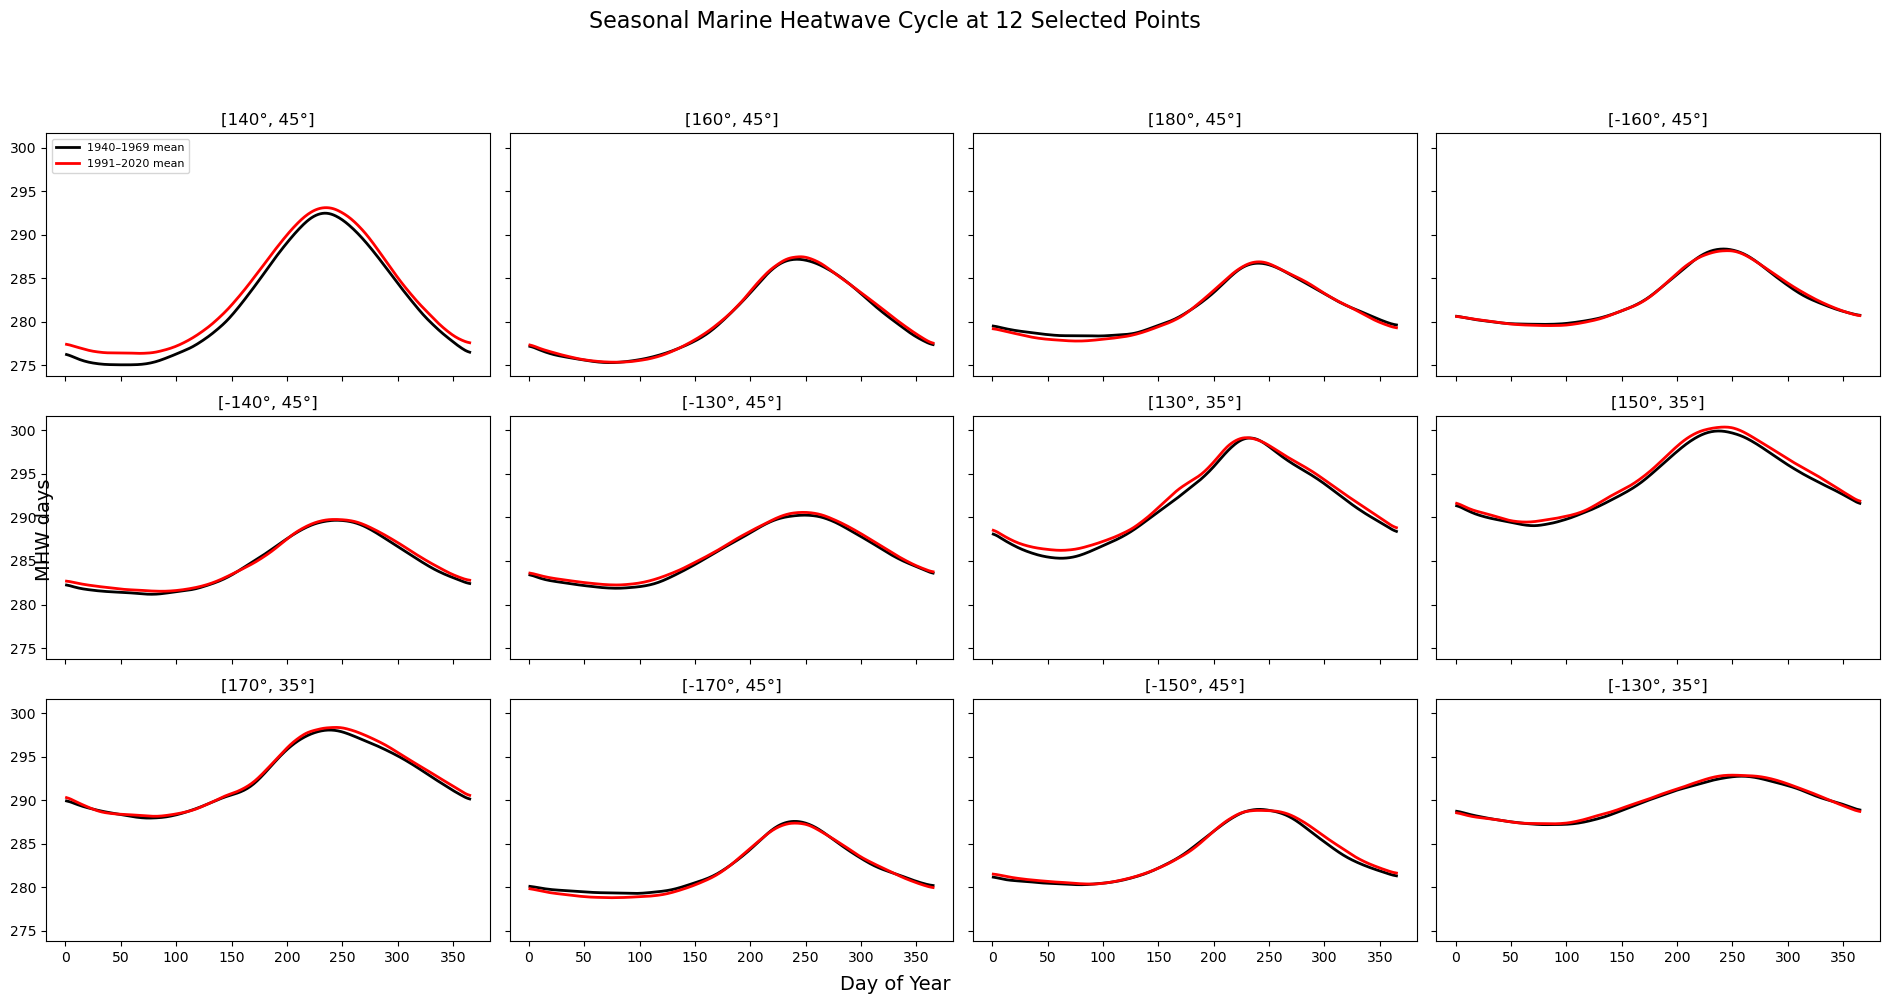

In [242]:
import matplotlib.pyplot as plt

points = [
    [140, 45], [160, 45], [180, 45], [-160, 45],
    [-140, 45], [-130, 45], [130, 35], [150, 35],
    [170, 35], [-170, 45], [-150, 45], [-130, 35],
]

# 전체 범위 계산을 위해 빈 리스트 생성
all_values = []

# 먼저 모든 패널의 y값(두 구간 seasonal cycle) 저장
for lon, lat in points:
    arr = DA_ds_raw_filtered_yearly_clim.sel(lon=lon, lat=lat, method='nearest')
    mean_40_69 = arr.sel(year=slice(1940, 1969)).mean(dim='year')
    mean_91_20 = arr.sel(year=slice(1991, 2020)).mean(dim='year')
    all_values.append(mean_40_69.values)
    all_values.append(mean_91_20.values)

# 전체 값에서 y축 범위 계산 (조금 여유 두기)
global_min = min(map(np.min, all_values))
global_max = max(map(np.max, all_values))
buffer = (global_max - global_min) * 0.05
ylim = (global_min - buffer, global_max + buffer)

fig, axs = plt.subplots(3, 4, figsize=(20, 10), sharex=True, sharey=True)

for i, (lon, lat) in enumerate(points):
    ax = axs[i // 4, i % 4]
    arr = DA_ds_raw_filtered_yearly_clim.sel(lon=lon, lat=lat, method='nearest')

    mean_40_69 = arr.sel(year=slice(1940, 1969)).mean(dim='year')
    mean_91_20 = arr.sel(year=slice(1991, 2020)).mean(dim='year')

    ax.plot(mean_40_69['doy'], mean_40_69, color='black', linewidth=2, label='1940–1969 mean' if i == 0 else "")
    ax.plot(mean_91_20['doy'], mean_91_20, color='red', linewidth=2, label='1991–2020 mean' if i == 0 else "")
    ax.set_title(f"[{lon}°, {lat}°]")
    ax.set_ylim(ylim)
    ax.set_xlabel('')
    ax.set_ylabel('')

axs[0, 0].legend(loc='upper left', fontsize=8)
fig.text(0.5, 0.04, 'Day of Year', ha='center', fontsize=14)
fig.text(0.07, 0.5, 'MHW days', va='center', rotation='vertical', fontsize=14)
plt.suptitle("Seasonal Marine Heatwave Cycle at 12 Selected Points", fontsize=16, y=1.02)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.97])
plt.show()



In [246]:
threshold

<xarray.DataArray (lat: 30, lon: 360, doy: 365)> Size: 32MB
array([[[293.96226918, 293.90311141, 293.84400801, ..., 294.13733715,
         294.08044045, 294.02140031],
        [293.85795676, 293.80458596, 293.75135886, ..., 294.0124373 ,
         293.96143993, 293.91006525],
        [293.85535445, 293.80183966, 293.74967291, ..., 294.01334672,
         293.96265841, 293.90897966],
        ...,
        [294.14172058, 294.0779566 , 294.01127097, ..., 294.32502552,
         294.26512174, 294.20383384],
        [294.24284252, 294.16740362, 294.09189342, ..., 294.45112582,
         294.3825961 , 294.31476524],
        [294.04433427, 293.98074535, 293.91603671, ..., 294.22966392,
         294.16796015, 294.10592513]],

       [[293.13631536, 293.06360279, 292.99306363, ..., 293.35419755,
         293.28202515, 293.20848389],
        [293.10491694, 293.05233071, 292.99520097, ..., 293.25254822,
         293.20306535, 293.15452492],
        [293.08528692, 293.02703885, 292.96744662, ..., 293.26112421,
         293.20199363, 293.14233815],
...
        [276.07011108, 276.04778109, 276.0255962 , ..., 276.1408278 ,
         276.11541498, 276.09191145],
        [276.16328097, 276.13723061, 276.11168379, ..., 276.24488942,
         276.21667175, 276.1899464 ],
        [276.33389033, 276.3062267 , 276.27765725, ..., 276.41269753,
         276.38560597, 276.3596885 ]],

       [[276.58560264, 276.56865845, 276.55203774, ..., 276.63982877,
         276.62060269, 276.60266585],
        [276.83206565, 276.81822371, 276.80215926, ..., 276.87493231,
         276.8604495 , 276.84618835],
        [276.73335072, 276.71646756, 276.69943848, ..., 276.77591303,
         276.76242315, 276.74854154],
        ...,
        [275.8438754 , 275.8232863 , 275.802943  , ..., 275.9154824 ,
         275.88953053, 275.86582031],
        [276.0651825 , 276.04077537, 276.01909069, ..., 276.14437034,
         276.11758062, 276.09072793],
        [276.29018471, 276.26925881, 276.24786072, ..., 276.36192377,
         276.33602656, 276.31252441]]])
Coordinates:
  * lat      (lat) float32 120B 30.5 31.5 32.5 33.5 34.5 ... 56.5 57.5 58.5 59.5
  * lon      (lon) float32 1kB -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * doy      (doy) int64 3kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365

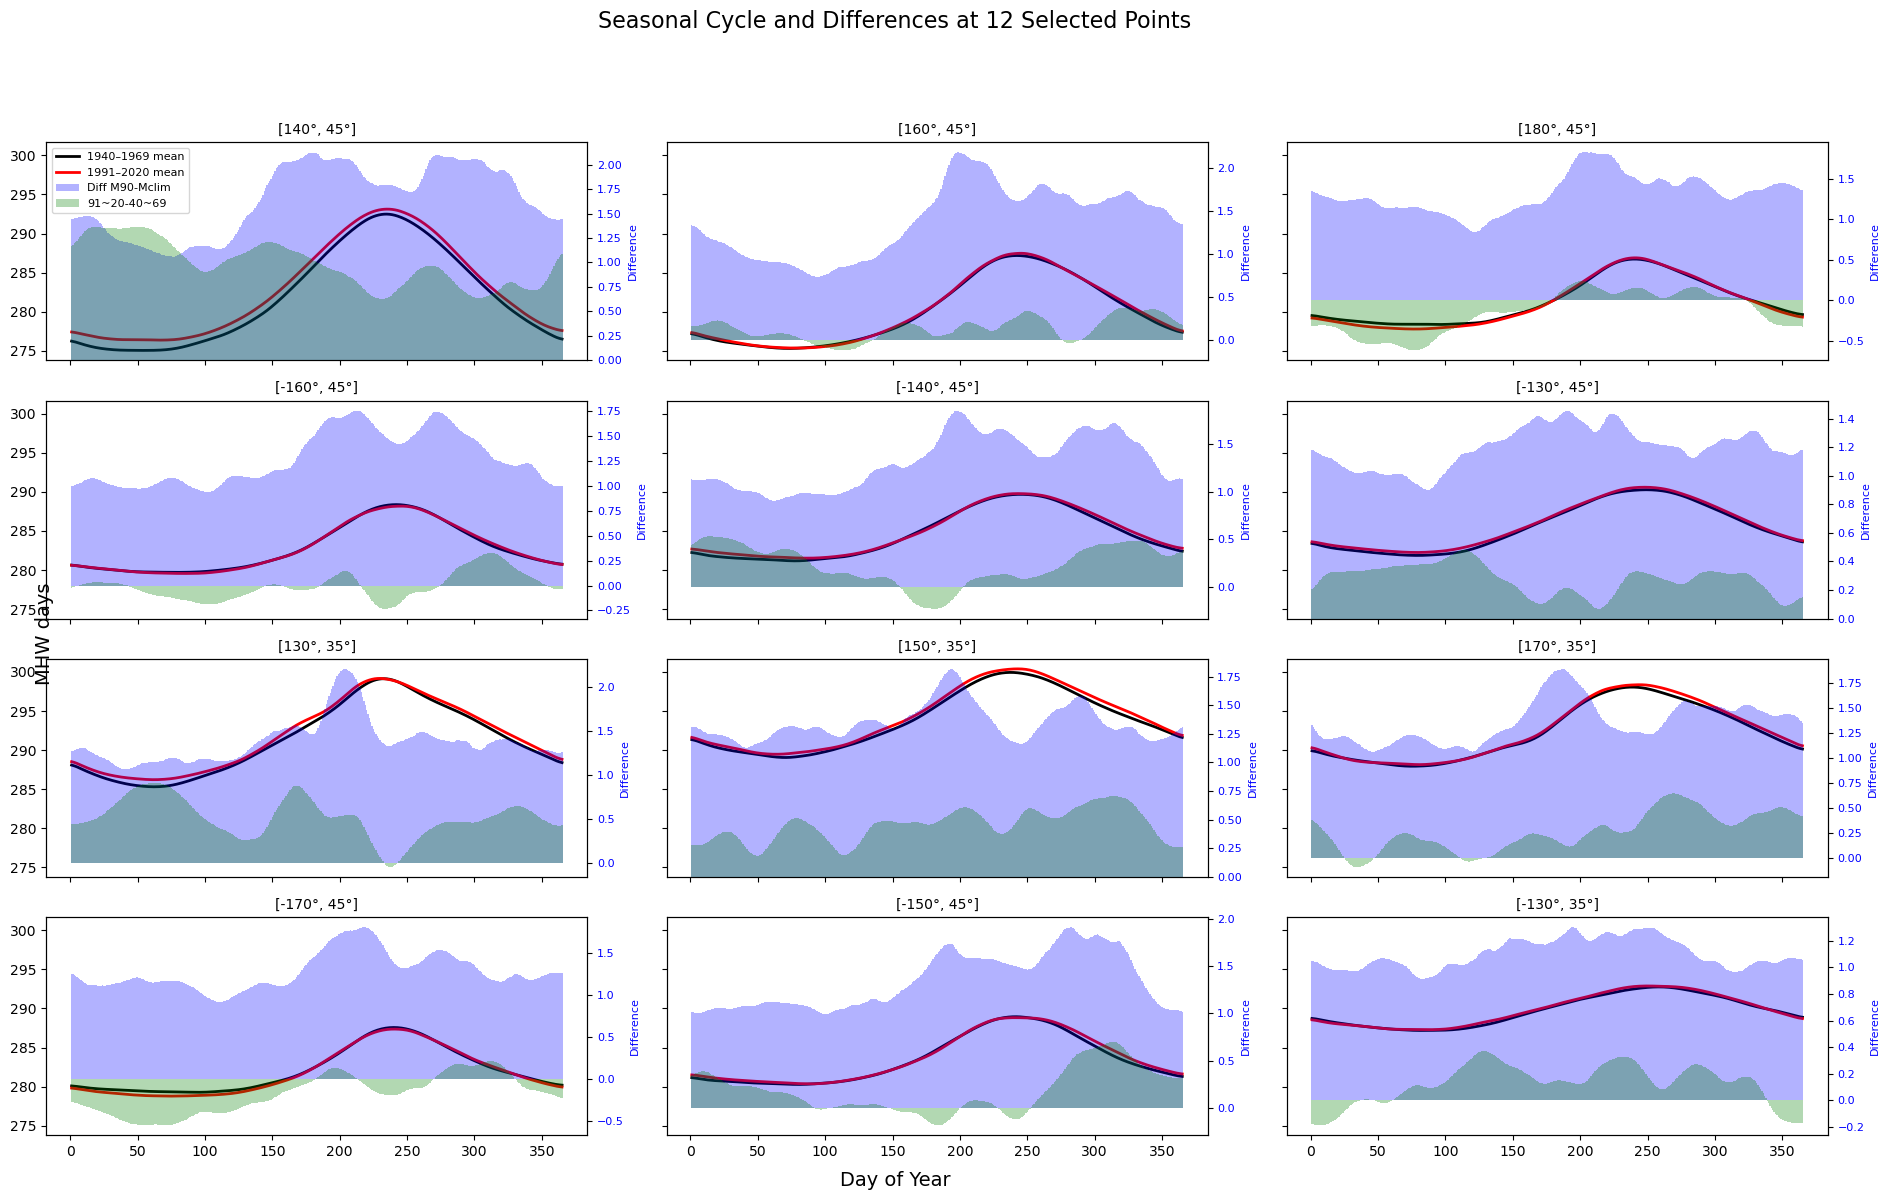

In [257]:
import matplotlib.pyplot as plt
import xarray as xr

# 분석할 지점 리스트
points = [
    [140, 45], [160, 45], [180, 45], [-160, 45],
    [-140, 45], [-130, 45], [130, 35], [150, 35],
    [170, 35], [-170, 45], [-150, 45], [-130, 35],
]

# subplot 준비
fig, axs = plt.subplots(4, 3, figsize=(20, 12), sharex=True, sharey=True)

first_ax2 = None  # 첫 번째 twin axis 저장용 (범례 가져오기 위해)

for i, (lon, lat) in enumerate(points):
    ax = axs[i // 3, i % 3]  # 3열 구성

    # 연도별 평균 seasonal cycle 추출
    arr = DA_ds_raw_filtered_yearly_clim.sel(lon=lon, lat=lat, method='nearest')
    mean_40_69 = arr.sel(year=slice(1940, 1969)).mean(dim='year')
    mean_91_20 = arr.sel(year=slice(1991, 2020)).mean(dim='year')

    # 선 그래프: 두 시기 평균 seasonal cycle
    ax.plot(mean_40_69['doy'], mean_40_69, color='black', linewidth=2,
            label='1940–1969 mean' if i == 0 else "")
    ax.plot(mean_91_20['doy'], mean_91_20, color='red', linewidth=2,
            label='1991–2020 mean' if i == 0 else "")
    ax.set_title(f"[{lon}°, {lat}°]", fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # 차이 시각화를 위한 twin axis
    ax2 = ax.twinx()
    if i == 0:
        first_ax2 = ax2  # 첫 번째 twin axis 저장

    # bar 1: M90 - climatology
    diff_bar1 = (DA_ds_raw_m90 - DA_ds_raw_mclim).sel(lon=lon, lat=lat, method='nearest')

    # bar 2: seasonal mean diff (후기 - 전기)
    diff_bar2 = (mean_91_20 - mean_40_69)

    width = 1  # bar 너비
    ax2.bar(diff_bar1['doy'], diff_bar1, width=width, alpha=0.3, color='blue',
            label='Diff M90-Mclim' if i == 0 else "")
    ax2.bar(diff_bar2['doy'], diff_bar2, width=width, alpha=0.3, color='green',
            label='91~20-40~69' if i == 0 else "")
    ax2.set_ylabel('Difference', color='blue', fontsize=8)
    ax2.tick_params(axis='y', labelcolor='blue', labelsize=8)

# 범례: 첫 번째 subplot에 선/막대 모두 표시
lines1, labels1 = axs[0, 0].get_legend_handles_labels()
lines2, labels2 = first_ax2.get_legend_handles_labels()
axs[0, 0].legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

# 공통 레이블 및 제목
fig.text(0.5, 0.04, 'Day of Year', ha='center', fontsize=14)
fig.text(0.07, 0.5, 'MHW days', va='center', rotation='vertical', fontsize=14)
plt.suptitle("Seasonal Cycle and Differences at 12 Selected Points (raw)", fontsize=16, y=1.02)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.97])
plt.show()



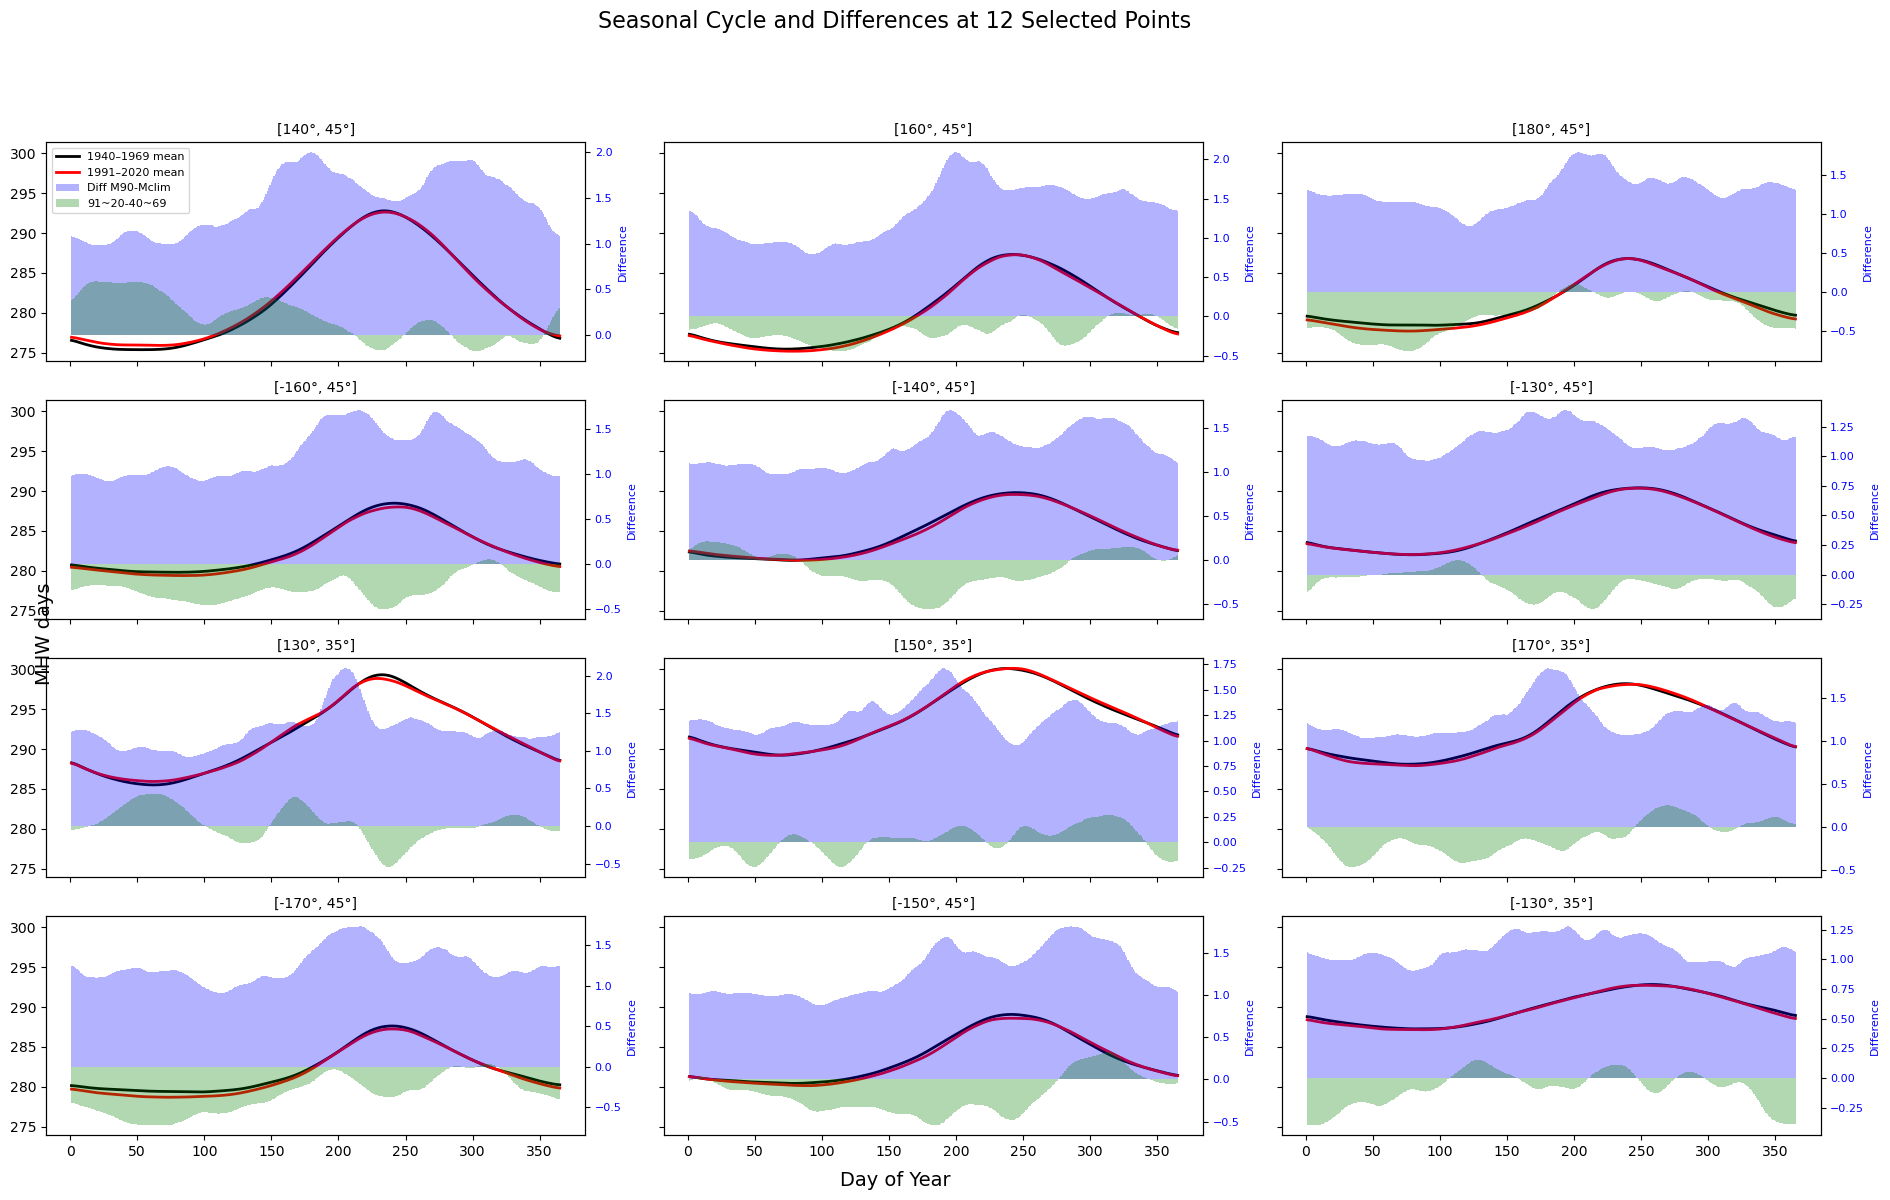

In [258]:
import matplotlib.pyplot as plt
import xarray as xr

# 분석할 지점 리스트
points = [
    [140, 45], [160, 45], [180, 45], [-160, 45],
    [-140, 45], [-130, 45], [130, 35], [150, 35],
    [170, 35], [-170, 45], [-150, 45], [-130, 35],
]

# subplot 준비
fig, axs = plt.subplots(4, 3, figsize=(20, 12), sharex=True, sharey=True)

first_ax2 = None  # 첫 번째 twin axis 저장용 (범례 가져오기 위해)

for i, (lon, lat) in enumerate(points):
    ax = axs[i // 3, i % 3]  # 3열 구성

    # 연도별 평균 seasonal cycle 추출
    arr = DA_ds_filtered_yearly_clim.sel(lon=lon, lat=lat, method='nearest')
    mean_40_69 = arr.sel(year=slice(1940, 1969)).mean(dim='year')
    mean_91_20 = arr.sel(year=slice(1991, 2020)).mean(dim='year')

    # 선 그래프: 두 시기 평균 seasonal cycle
    ax.plot(mean_40_69['doy'], mean_40_69, color='black', linewidth=2,
            label='1940–1969 mean' if i == 0 else "")
    ax.plot(mean_91_20['doy'], mean_91_20, color='red', linewidth=2,
            label='1991–2020 mean' if i == 0 else "")
    ax.set_title(f"[{lon}°, {lat}°]", fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # 차이 시각화를 위한 twin axis
    ax2 = ax.twinx()
    if i == 0:
        first_ax2 = ax2  # 첫 번째 twin axis 저장

    # bar 1: M90 - climatology
    diff_bar1 = (DA_ds_m90 - DA_ds_mclim).sel(lon=lon, lat=lat, method='nearest')

    # bar 2: seasonal mean diff (후기 - 전기)
    diff_bar2 = (mean_91_20 - mean_40_69)

    width = 1  # bar 너비
    ax2.bar(diff_bar1['doy'], diff_bar1, width=width, alpha=0.3, color='blue',
            label='Diff M90-Mclim' if i == 0 else "")
    ax2.bar(diff_bar2['doy'], diff_bar2, width=width, alpha=0.3, color='green',
            label='91~20-40~69' if i == 0 else "")
    ax2.set_ylabel('Difference', color='blue', fontsize=8)
    ax2.tick_params(axis='y', labelcolor='blue', labelsize=8)

# 범례: 첫 번째 subplot에 선/막대 모두 표시
lines1, labels1 = axs[0, 0].get_legend_handles_labels()
lines2, labels2 = first_ax2.get_legend_handles_labels()
axs[0, 0].legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

# 공통 레이블 및 제목
fig.text(0.5, 0.04, 'Day of Year', ha='center', fontsize=14)
fig.text(0.07, 0.5, 'MHW days', va='center', rotation='vertical', fontsize=14)
plt.suptitle("Seasonal Cycle and Differences at 12 Selected Points (det)", fontsize=16, y=1.02)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.97])
plt.show()



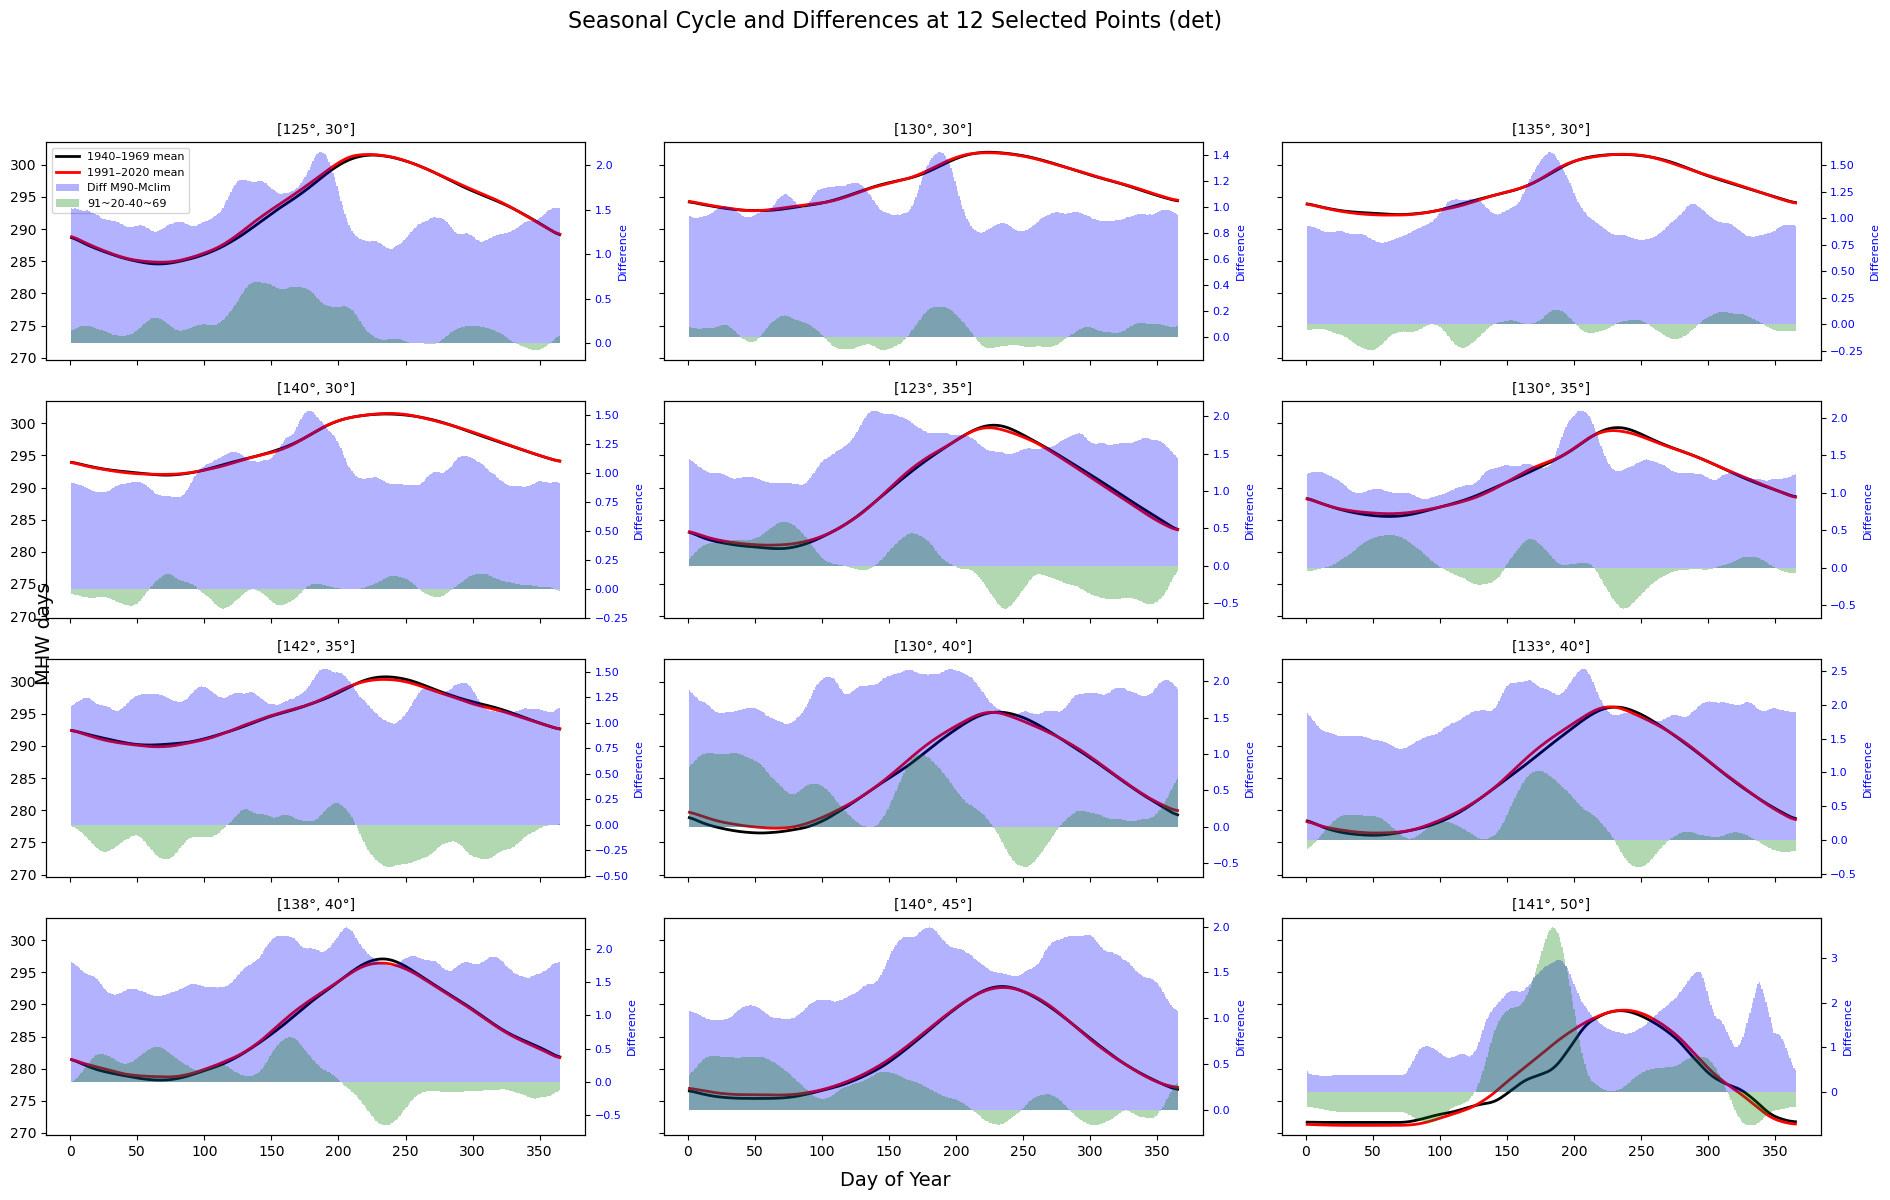

In [281]:
import matplotlib.pyplot as plt
import xarray as xr

# 분석할 지점 리스트
points = [
    [125, 30], [130, 30], [135, 30], [140, 30],
    [123, 35], [130, 35], [142, 35], [130, 40],
    [133, 40], [138, 40], [140, 45], [141, 50],
]

# subplot 준비
fig, axs = plt.subplots(4, 3, figsize=(20, 12), sharex=True, sharey=True)

first_ax2 = None  # 첫 번째 twin axis 저장용 (범례 가져오기 위해)

for i, (lon, lat) in enumerate(points):
    ax = axs[i // 3, i % 3]  # 3열 구성

    # 연도별 평균 seasonal cycle 추출
    arr = DA_ds_filtered_yearly_clim.sel(lon=lon, lat=lat, method='nearest')
    mean_40_69 = arr.sel(year=slice(1940, 1969)).mean(dim='year')
    mean_91_20 = arr.sel(year=slice(1991, 2020)).mean(dim='year')

    # 선 그래프: 두 시기 평균 seasonal cycle
    ax.plot(mean_40_69['doy'], mean_40_69, color='black', linewidth=2,
            label='1940–1969 mean' if i == 0 else "")
    ax.plot(mean_91_20['doy'], mean_91_20, color='red', linewidth=2,
            label='1991–2020 mean' if i == 0 else "")
    ax.set_title(f"[{lon}°, {lat}°]", fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # 차이 시각화를 위한 twin axis
    ax2 = ax.twinx()
    if i == 0:
        first_ax2 = ax2  # 첫 번째 twin axis 저장

    # bar 1: M90 - climatology
    diff_bar1 = (DA_ds_m90 - DA_ds_mclim).sel(lon=lon, lat=lat, method='nearest')

    # bar 2: seasonal mean diff (후기 - 전기)
    diff_bar2 = (mean_91_20 - mean_40_69)

    width = 1  # bar 너비
    ax2.bar(diff_bar1['doy'], diff_bar1, width=width, alpha=0.3, color='blue',
            label='Diff M90-Mclim' if i == 0 else "")
    ax2.bar(diff_bar2['doy'], diff_bar2, width=width, alpha=0.3, color='green',
            label='91~20-40~69' if i == 0 else "")
    ax2.set_ylabel('Difference', color='blue', fontsize=8)
    ax2.tick_params(axis='y', labelcolor='blue', labelsize=8)

# 범례: 첫 번째 subplot에 선/막대 모두 표시
lines1, labels1 = axs[0, 0].get_legend_handles_labels()
lines2, labels2 = first_ax2.get_legend_handles_labels()
axs[0, 0].legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

# 공통 레이블 및 제목
fig.text(0.5, 0.04, 'Day of Year', ha='center', fontsize=14)
fig.text(0.07, 0.5, 'MHW days', va='center', rotation='vertical', fontsize=14)
plt.suptitle("Seasonal Cycle and Differences at 12 Selected Points (det)", fontsize=16, y=1.02)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.97])
plt.show()



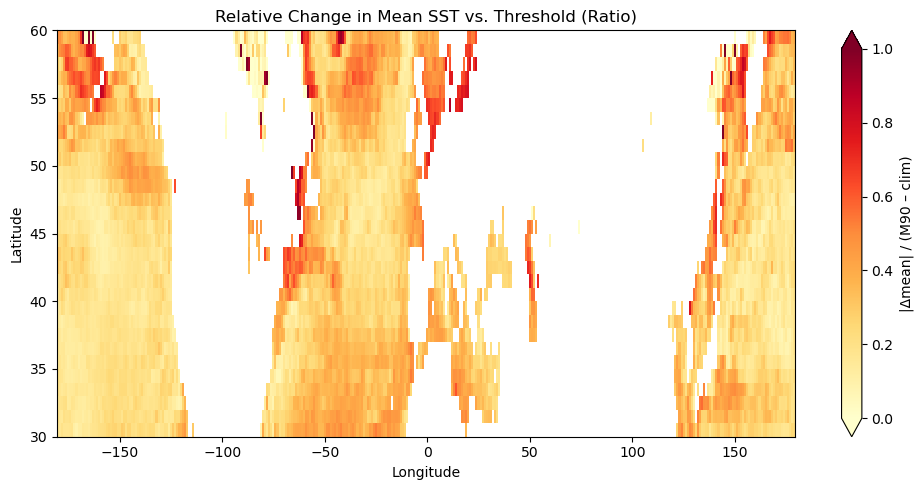

In [260]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 1. 평균 seasonal cycle 계산
mean_40_69 = DA_ds_raw_filtered_yearly_clim.sel(year=slice(1940, 1969)).mean(dim='year')
mean_91_20 = DA_ds_raw_filtered_yearly_clim.sel(year=slice(1991, 2020)).mean(dim='year')

# 2. 차이 계산
diff_bar1 = DA_ds_raw_m90 - DA_ds_raw_mclim           # 극값 - 평년
diff_bar2 = mean_91_20 - mean_40_69                   # 최근평년 - 과거평년

# 3. 비율 계산 (abs diff / threshold)
ratio = np.abs(diff_bar2) / diff_bar1

# 4. doy 평균 → 연평균 비율
ratio_mean = ratio.mean(dim='doy', skipna=True)

# 5. 시각화
plt.figure(figsize=(10, 5))
p = ratio_mean.plot(
    cmap='YlOrRd',
    vmin=0, vmax=1,  # 필요시 조정
    cbar_kwargs={'label': '|Δmean| / (M90 – clim)'}
)
plt.title('Relative Change in Mean SST vs. Threshold (Ratio)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()


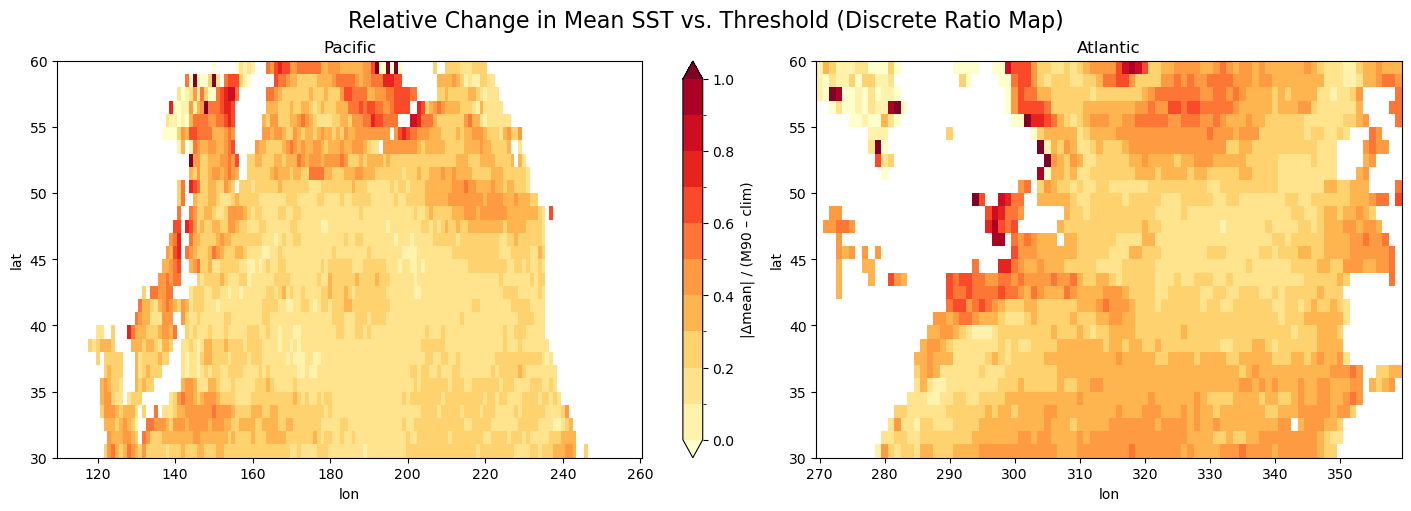

In [262]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# ---------- [1] 평균 seasonal cycle 계산 ----------
mean_40_69 = DA_ds_raw_filtered_yearly_clim.sel(year=slice(1940, 1969)).mean(dim='year')
mean_91_20 = DA_ds_raw_filtered_yearly_clim.sel(year=slice(1991, 2020)).mean(dim='year')

# ---------- [2] 차이 계산 ----------
diff_bar1 = DA_ds_raw_m90 - DA_ds_raw_mclim           # threshold = M90 - clim
diff_bar2 = mean_91_20 - mean_40_69                   # recent - past

# ---------- [3] 비율 계산: 안전 처리 포함 ----------
safe_ratio = xr.where(diff_bar1 == 0, np.nan, np.abs(diff_bar2) / diff_bar1)

# ---------- [4] doy 평균값 ----------
ratio_mean = safe_ratio.mean(dim='doy', skipna=True)

# ---------- [5] lon 0–360 변환 ----------
ratio_360 = ratio_mean.copy()
ratio_360['lon'] = xr.where(
    ratio_360.lon < 0,
    ratio_360.lon + 360,
    ratio_360.lon
)
ratio_360 = ratio_360.sortby('lon')

# ---------- [6] Pacific & Atlantic 분리 ----------
lat_min, lat_max = -60, 60
pacific = ratio_360.sel(lon=slice(110, 260), lat=slice(lat_min, lat_max))
atlantic = ratio_360.sel(lon=slice(270, 380), lat=slice(lat_min, lat_max))

# ---------- Discrete color levels ----------
levels = np.arange(0, 1.01, 0.1)  # 0.0 ~ 1.0, 총 11개 단계

fig, axs = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# Pacific
p1 = pacific.plot(
    ax=axs[0],
    cmap='YlOrRd',
    levels=levels,
    cbar_kwargs={'label': '|Δmean| / (M90 – clim)'}
)
axs[0].set_title('Pacific')

# Atlantic
p2 = atlantic.plot(
    ax=axs[1],
    cmap='YlOrRd',
    levels=levels,
    add_colorbar=False  # 두 번째는 colorbar 생략
)
axs[1].set_title('Atlantic')

plt.suptitle('Relative Change in Mean SST vs. Threshold (Discrete Ratio Map)', fontsize=16)
plt.show()

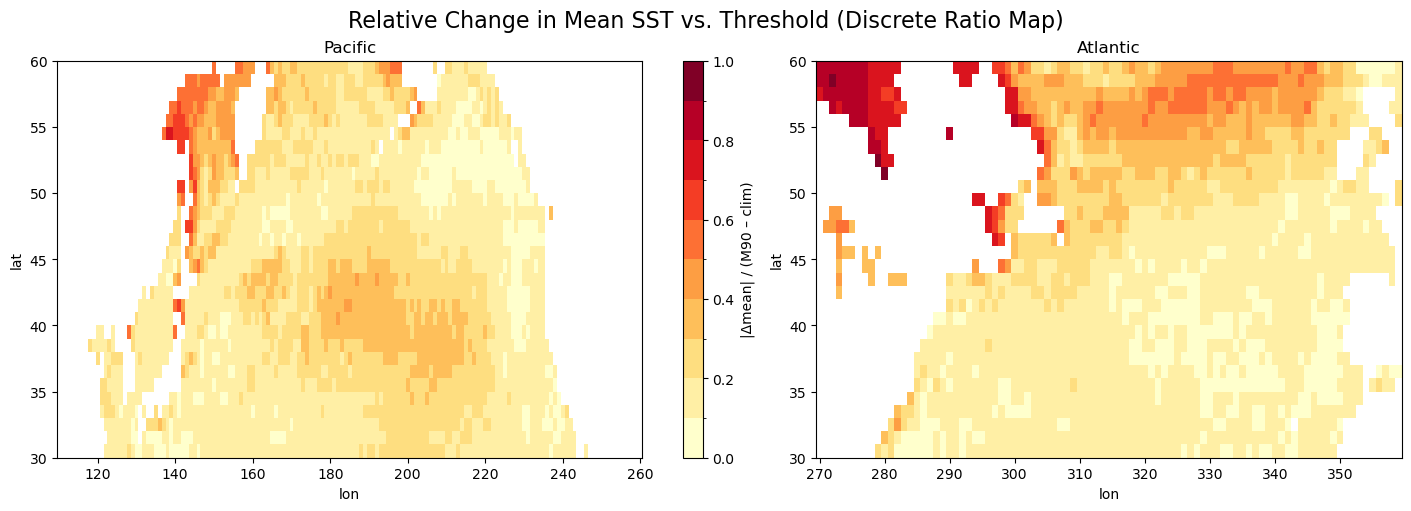

In [263]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# ---------- [1] 평균 seasonal cycle 계산 ----------
mean_40_69 = DA_ds_filtered_yearly_clim.sel(year=slice(1940, 1969)).mean(dim='year')
mean_91_20 = DA_ds_filtered_yearly_clim.sel(year=slice(1991, 2020)).mean(dim='year')

# ---------- [2] 차이 계산 ----------
diff_bar1 = DA_ds_m90 - DA_ds_mclim           # threshold = M90 - clim
diff_bar2 = mean_91_20 - mean_40_69                   # recent - past

# ---------- [3] 비율 계산: 안전 처리 포함 ----------
safe_ratio = xr.where(diff_bar1 == 0, np.nan, np.abs(diff_bar2) / diff_bar1)

# ---------- [4] doy 평균값 ----------
ratio_mean = safe_ratio.mean(dim='doy', skipna=True)

# ---------- [5] lon 0–360 변환 ----------
ratio_360 = ratio_mean.copy()
ratio_360['lon'] = xr.where(
    ratio_360.lon < 0,
    ratio_360.lon + 360,
    ratio_360.lon
)
ratio_360 = ratio_360.sortby('lon')

# ---------- [6] Pacific & Atlantic 분리 ----------
lat_min, lat_max = -60, 60
pacific = ratio_360.sel(lon=slice(110, 260), lat=slice(lat_min, lat_max))
atlantic = ratio_360.sel(lon=slice(270, 380), lat=slice(lat_min, lat_max))

# ---------- Discrete color levels ----------
levels = np.arange(0, 1.01, 0.1)  # 0.0 ~ 1.0, 총 11개 단계

fig, axs = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# Pacific
p1 = pacific.plot(
    ax=axs[0],
    cmap='YlOrRd',
    levels=levels,
    cbar_kwargs={'label': '|Δmean| / (M90 – clim)'}
)
axs[0].set_title('Pacific')

# Atlantic
p2 = atlantic.plot(
    ax=axs[1],
    cmap='YlOrRd',
    levels=levels,
    add_colorbar=False  # 두 번째는 colorbar 생략
)
axs[1].set_title('Atlantic')

plt.suptitle('Relative Change in Mean SST vs. Threshold (Discrete Ratio Map)', fontsize=16)
plt.show()